In [2]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-87egxf1y/nemo-toolkit_67709ecfbc834a00a63e1581b2c6b1f7
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-87egxf1y/nemo-toolkit_67709ecfbc834a00a63e1581b2c6b1f7
  Re

'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
from pydub import AudioSegment
import os
from multiprocessing import Pool, cpu_count

# Define the path to your MP3 files and where to save WAV files
mp3_folder = '/content/drive/My Drive/hy-AM/clips'
wav_folder = '/content/drive/My Drive/hy-AM/clips_wav'

# Ensure the WAV folder exists
os.makedirs(wav_folder, exist_ok=True)

# Gather all MP3 files recursively
mp3_files = []
for root, _, files in os.walk(mp3_folder):
    for file in files:
        if file.endswith('.mp3'):
            mp3_files.append(os.path.join(root, file))

# Define the conversion logic
def convert_file(mp3_path):
    wav_path = os.path.join(wav_folder, os.path.basename(mp3_path)[:-4] + '.wav')
    audio = AudioSegment.from_mp3(mp3_path)

    # Set to mono and export with 16 kHz sample rate
    audio = audio.set_channels(1)  # Mono channel
    audio = audio.set_frame_rate(16000)  # 16 kHz sampling rate
    audio.export(wav_path, format='wav')

    print(f'Converted {os.path.basename(mp3_path)} to {wav_path}')

# Use parallel processing to convert files
if mp3_files:
    with Pool(processes=cpu_count()) as pool:
        pool.map(convert_file, mp3_files)
else:
    print("No MP3 files found for conversion.")
'''

Streaming output truncated to the last 5000 lines.
Converted common_voice_hy-AM_39471540.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39471540.wav
Converted common_voice_hy-AM_26540326.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_26540326.wav
Converted common_voice_hy-AM_39474343.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39474343.wav
Converted common_voice_hy-AM_39315608.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39315608.wavConverted common_voice_hy-AM_26256213.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_26256213.wav

Converted common_voice_hy-AM_39447412.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39447412.wav
Converted common_voice_hy-AM_27605099.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_27605099.wav
Converted common_voice_hy-AM_26540354.mp3 to /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_26540354.wav
Converted com

In [22]:
import pandas as pd
import os
import json
import string
from sklearn.model_selection import train_test_split

# Paths to the TSV files
validated_path = '/content/drive/My Drive/hy-AM/validated.tsv'
durations_path = '/content/drive/My Drive/hy-AM/clip_durations.tsv'

# Load the TSV files
validated_df = pd.read_csv(validated_path, sep='\t', encoding='utf-8')
durations_df = pd.read_csv(durations_path, sep='\t', encoding='utf-8')

# Merge the two DataFrames on the 'path' column
merged_df = pd.merge(validated_df, durations_df, left_on='path', right_on='clip')
merged_df_final = merged_df[['path', 'duration[ms]', 'sentence']]

# Define the base directory for the audio files and the folder for WAV files
base_audio_dir = '/content/drive/My Drive/hy-AM'
wav_folder = os.path.join(base_audio_dir, 'clips_wav')

# Ensure WAV folder exists
os.makedirs(wav_folder, exist_ok=True)

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    return text

# Function to create the manifest file
def create_manifest(df, file):
    if df.empty:
        print("DataFrame is empty. No manifest file created.")
        return

    with open(file, 'w', encoding='utf-8') as fout:
        for _, row in df.iterrows():
            audio_path = os.path.join(wav_folder, os.path.basename(row['path']).replace('.mp3', '.wav'))

            # Check if the audio file exists
            if not os.path.exists(audio_path):
                # check if the mentioned audio file exists
                continue

            duration = row['duration[ms]']
            transcription = clean_text(row['sentence'])

            # Build the manifest entry
            entry = {
                'audio_filepath': audio_path,
                'duration': duration/1000,
                'text': transcription
            }

            json.dump(entry, fout, ensure_ascii=False)
            fout.write('\n')

    print(f"Manifest file created at: {file}")

# Split the data into train (80%) and test (20%)
train_df, test_df = train_test_split(merged_df_final, test_size=0.2, random_state=42)

# Create separate manifest files for train and test sets
train_manifest_file = os.path.join(base_audio_dir, 'train_manifest.json')
test_manifest_file = os.path.join(base_audio_dir, 'test_manifest.json')

# Create the manifests
create_manifest(train_df, train_manifest_file)
create_manifest(test_df, test_manifest_file)

Manifest file created at: /content/drive/My Drive/hy-AM/train_manifest.json
Manifest file created at: /content/drive/My Drive/hy-AM/test_manifest.json


In [23]:
!head /content/drive/My\ Drive/hy-AM/train_manifest.json

{"audio_filepath": "/content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39377412.wav", "duration": 3.456, "text": "շենքը ժամանակակից արվեստի նմուշ է։"}
{"audio_filepath": "/content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39276562.wav", "duration": 5.22, "text": "լիմանի ափերին են գտնվում մանկական հանգստի ճամբարներ։"}
{"audio_filepath": "/content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39471073.wav", "duration": 7.38, "text": "նրանց բերում են արքայական պալատ, իսկ թագավորը երկու հարսանիք է կազմակերպում։"}
{"audio_filepath": "/content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39543514.wav", "duration": 5.58, "text": "տեղի ունեցան կատաղի ընդհարումներ հայերի և ադրբեջանցիների միջև։"}
{"audio_filepath": "/content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39440400.wav", "duration": 4.14, "text": "բժիշկ, ով դավաճանում էր իր կնոջը կրտսեր տիրուհու հետ։"}
{"audio_filepath": "/content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39543032.wav", "duratio

In [ ]:
import librosa
import IPython.display as ipd

# Load and listen to one of the audio files
example_file = base_audio_dir + '/clips_wav/common_voice_hy-AM_39810275.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

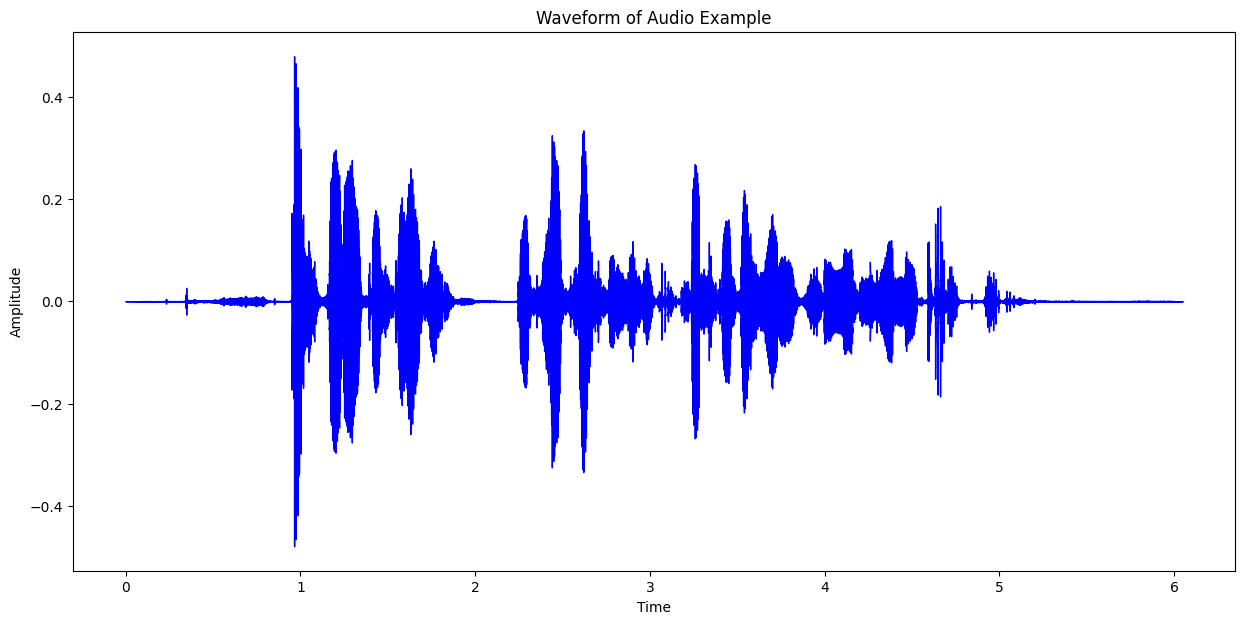

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

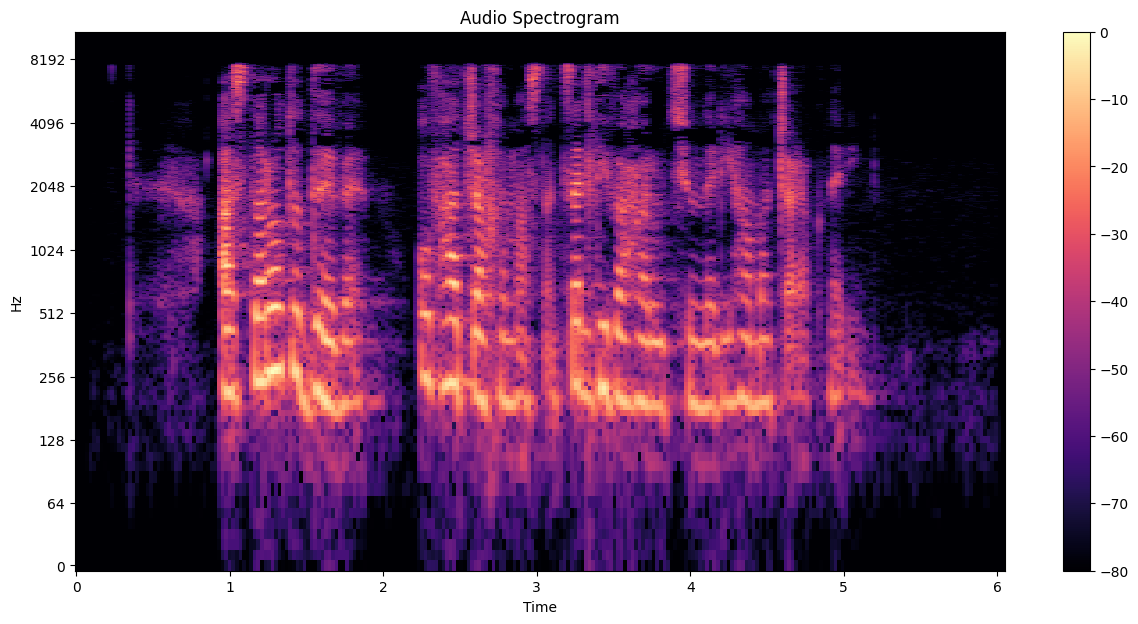

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

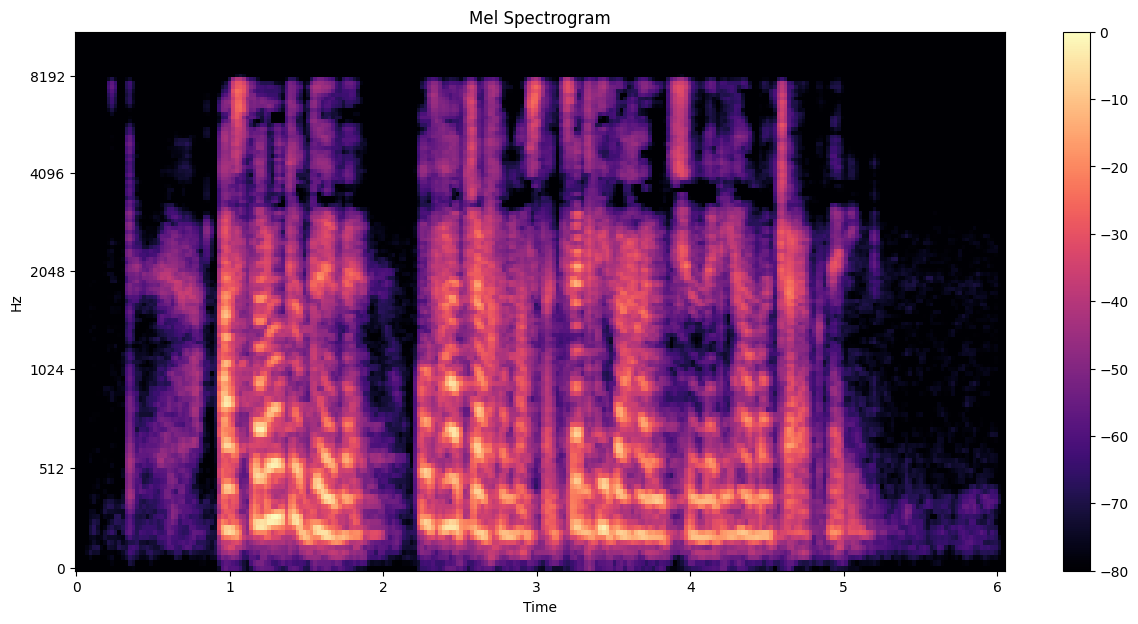

In [ ]:
import matplotlib.pyplot as plt

# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [5]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

In [6]:
from collections import defaultdict
from tqdm.auto import tqdm
from nemo.collections.asr.parts.utils.manifest_utils import read_manifest, write_manifest
import json

def get_charset(manifest_data):
    charset = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing character set"):
        text = row['text']
        for character in text:
            charset[character] += 1
    return charset

train_manifest_data = read_manifest(train_manifest_file)
test_manifest_data = read_manifest(test_manifest_file)

train_charset = get_charset(train_manifest_data)
test_charset = get_charset(test_manifest_data)

train_set = set(train_charset.keys())
test_set = set(test_charset.keys())

print(f"Number of tokens in train set : {len(train_set)}")
print(f"Number of tokens in test set : {len(test_set)}")

print(f"Train set : {train_set}")
print(f"Test set : {test_set}")

Computing character set:   0%|          | 0/9717 [00:00<?, ?it/s]

Computing character set:   0%|          | 0/2468 [00:00<?, ?it/s]

Number of tokens in train set : 59
Number of tokens in test set : 57
Train set : {'…', 'և', 'յ', 'ջ', 'ա', 'ճ', '։', ' ', 'տ', 'ը', '՜', '«', 'գ', '`', 'է', 'ե', 'դ', '՛', 'կ', 'օ', 'ձ', '-', 'պ', '.', '(', 'ծ', '՝', 'ռ', 'ն', 'ժ', 'զ', 'փ', 'շ', '՞', 'ր', 'ո', 'մ', 'ս', 'բ', 'խ', '֊', 'ց', '՚', '´', 'ւ', 'չ', ')', '»', 'ֆ', 'հ', ',', 'ք', ':', '’', 'վ', 'ղ', 'թ', 'ի', 'լ'}
Test set : {'…', 'և', 'յ', 'ջ', 'ա', 'ճ', '։', ' ', 'տ', 'ը', '՜', '«', 'գ', '`', 'ե', 'է', 'դ', '՛', 'կ', 'օ', 'ձ', '-', 'պ', '(', '.', 'ծ', '՝', 'ռ', 'ն', 'ժ', 'զ', 'փ', '՞', 'շ', 'ր', 'ո', 'խ', 'ս', 'բ', 'մ', '֊', 'ց', '՚', 'ւ', 'չ', '»', ')', 'ֆ', 'հ', ',', 'ք', ':', 'ղ', 'վ', 'թ', 'ի', 'լ'}


In [7]:
import re
import unicodedata
chars_to_ignore_regex = '[\\՞\«\՛\֊\՝\՜\…\»\՚\:\։\(\)\-\,\`\.]'  # remove special character tokens

def remove_special_characters(data):
    data["text"] = re.sub(chars_to_ignore_regex, '', data["text"]).lower().strip()
    return data

In [8]:
set_cleaned = set(' ')
# Iterate through each item in the original set
for item in test_set:
    # Apply re.sub to each item, then add to the cleaned set
    cleaned_item = re.sub(chars_to_ignore_regex, '', item).lower().strip()
    set_cleaned.add(cleaned_item)

In [9]:
def apply_preprocessors(manifest, preprocessors):
    for processor in preprocessors:
        for idx in tqdm(range(len(manifest)), desc=f"Applying {processor.__name__}"):
            manifest[idx] = processor(manifest[idx])

    print("Finished processing manifest !")
    return manifest

PREPROCESSORS = [
    remove_special_characters
]

train_data_processed = apply_preprocessors(train_manifest_data, PREPROCESSORS)
test_data_processed = apply_preprocessors(test_manifest_data, PREPROCESSORS)

Applying remove_special_characters:   0%|          | 0/9717 [00:00<?, ?it/s]

Finished processing manifest !


Applying remove_special_characters:   0%|          | 0/2468 [00:00<?, ?it/s]

Finished processing manifest !


In [10]:
import json
import os

def write_manifest(filepath, data):
    # Write each item in the data list as a separate line in the manifest file
    with open(filepath, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

def write_processed_manifest(data, original_path):
    # Get the original manifest name and create a new name for the processed manifest
    original_manifest_name = os.path.basename(original_path)
    new_manifest_name = original_manifest_name.replace(".json", "_processed.json")

    # Extract the directory of the original manifest file
    manifest_dir = os.path.dirname(original_path)
    filepath = os.path.join(manifest_dir, new_manifest_name)

    # Write the processed data to the new manifest file
    write_manifest(filepath, data)
    print(f"Finished writing manifest: {filepath}")
    return filepath

train_manifest_cleaned = write_processed_manifest(train_data_processed, train_manifest_file)
test_manifest_cleaned = write_processed_manifest(test_data_processed, test_manifest_file)

Finished writing manifest: /content/drive/My Drive/hy-AM/train_manifest_processed.json
Finished writing manifest: /content/drive/My Drive/hy-AM/test_manifest_processed.json


In [11]:
import torch
import pytorch_lightning as ptl
from torch.utils.data import DataLoader
from nemo.collections.asr.data.audio_to_text import AudioToCharDataset
from nemo.collections.asr.metrics.wer import word_error_rate
from nemo.collections.asr.models import EncDecCTCModel
from omegaconf import OmegaConf, open_dict
import json

class CustomAudioToCharDataset(AudioToCharDataset):
    def __init__(self, manifest_filepath, labels, sample_rate):
        super().__init__(manifest_filepath=manifest_filepath, labels=labels, sample_rate=sample_rate)

        # Load manifest data from file
        with open(manifest_filepath, 'r') as f:
            self.manifest_data = [json.loads(line) for line in f]

    def get_audio_filepaths(self):
        return [sample['audio_filepath'] for sample in self.manifest_data]

class CustomEncDecCTCModel(EncDecCTCModel):

    def train_dataloader(self):
        train_dataset = CustomAudioToCharDataset(  # Use CustomAudioToCharDataset
            manifest_filepath=self.cfg.train_ds.manifest_filepath,
            labels=self.cfg.train_ds.labels,
            sample_rate=self.cfg.train_ds.sample_rate,
        )

        return DataLoader(
            dataset=train_dataset,
            batch_size=self.cfg.train_ds.batch_size,
            num_workers=self.cfg.train_ds.num_workers,
            pin_memory=self.cfg.train_ds.pin_memory,
            shuffle=True,
        )

    def evaluate_on_wav_files(self, manifest_filepath, predictions_filepath):
        """
        Evaluates the model on a dataset specified by a manifest file and writes predictions to a file.

        Args:
            manifest_filepath: Path to the manifest file containing the evaluation data.
            predictions_filepath: Path to the file where predictions will be written.
        """
        eval_dataset = CustomAudioToCharDataset(
            manifest_filepath=manifest_filepath,
            labels=self.cfg.validation_ds.labels,
            sample_rate=self.cfg.validation_ds.sample_rate,
        )
        eval_dataloader = DataLoader(
            dataset=eval_dataset,
            batch_size=self.cfg.validation_ds.batch_size,
            num_workers=self.cfg.validation_ds.num_workers,
            pin_memory=self.cfg.validation_ds.pin_memory,
            shuffle=False,
        )

        # Move the model to the correct device (GPU if available)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        # Get audio file paths
        audio_filepaths = eval_dataset.get_audio_filepaths()

        # Get predictions using self.transcribe()
        predictions_text = self.transcribe(audio_filepaths,
                                           self.cfg.validation_ds.batch_size,
                                           False)

        # Adapt predictions to the expected format
        with open(manifest_filepath, 'r') as f:
            manifest_data = [json.loads(line) for line in f]

        predictions = [{'file': sample['audio_filepath'], 'pred_text': pred}
                        for sample, pred in zip(manifest_data, predictions_text)]

        # Write predictions to a file
        with open(predictions_filepath, 'w') as f:
            for pred in predictions:
                f.write(f"File: {pred['file']}, Prediction: {pred['pred_text']}\n")

        # Calculate Word Error Rate (WER)
        references = [sample['text'] for sample in manifest_data]
        hypotheses = [pred['pred_text'] for pred in predictions]
        wer = word_error_rate(hypotheses=hypotheses, references=references)

        print(f"Word Error Rate (WER): {wer}")

        for p in predictions:
            print(f"File: {p['file']}, Prediction: {p['pred_text']}")

In [12]:
# Create an instance of your custom model
char_model = CustomEncDecCTCModel.from_pretrained("QuartzNet15x5Base-En")
char_model.change_vocabulary(new_vocabulary=list(set_cleaned))

[NeMo I 2024-10-21 15:49:03 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_2.1.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-10-21 15:49:04 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-10-21 15:49:05 features:305] PADDING: 16


[NeMo W 2024-10-21 15:49:06 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:682: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-10-21 15:49:07 save_restore_connector:275] Model CustomEncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.1.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2024-10-21 15:49:07 ctc_models:235] Changed decoder to output to ['', 'և', 'յ', 'ջ', 'ա', 'ճ', ' ', 'տ', 'լ', 'ը', 'գ', 'ե', 'է', 'դ', 'կ', 'օ', 'պ', 'ծ', 'ռ', 'ն', 'ժ', 'զ', 'փ', 'շ', 'ր', 'ո', 'խ', 'ս', 'բ', 'մ', 'ց', 'ւ', 'չ', 'ֆ', 'հ', 'ք', 'ղ', 'վ', 'թ', 'ի', 'ձ'] vocabulary.


In [13]:
from omegaconf import OmegaConf, open_dict

# Create a new configuration for train_ds
new_train_ds = OmegaConf.create({
    "manifest_filepath": train_manifest_cleaned,
    "labels": list(train_set),
    "normalize_transcripts": False,
    "batch_size": 32,
    "num_workers": 8,
    "pin_memory": True,
    "trim_silence": True,
})

# Use open_dict to dynamically add or update train_ds
with open_dict(char_model.cfg):
    char_model.cfg.train_ds = new_train_ds  # Directly assign if not present

# Create a new configuration for validation_ds if it doesn't exist
# Use open_dict to dynamically add or update validation_ds
with open_dict(char_model.cfg):
    char_model.cfg.validation_ds = OmegaConf.create({ # Directly assign if not present
        "manifest_filepath": test_manifest_cleaned,
        "labels": list(train_set),
        "normalize_transcripts": False,
        "batch_size": 8,
        "num_workers": 8,
        "pin_memory": True,
        "trim_silence": True,
    })

In [14]:
with open_dict(char_model.cfg):
    char_model.cfg.train_ds = OmegaConf.create({
        "manifest_filepath": train_manifest_cleaned,
        "labels": list(train_set),
        "normalize_transcripts": False,
        "batch_size": 32,
        "num_workers": 8,
        "pin_memory": True,
        "trim_silence": True,
        "sample_rate": 16000,  # Add sample_rate here. Change to your desired rate.
    })
    char_model.cfg.validation_ds = OmegaConf.create({
        "manifest_filepath": test_manifest_cleaned,
        "labels": list(train_set),
        "normalize_transcripts": False,
        "batch_size": 8,
        "num_workers": 8,
        "pin_memory": True,
        "trim_silence": True,
        "sample_rate": 16000,  # Add sample_rate here. Change to your desired rate.
    })

In [20]:
char_model.evaluate_on_wav_files(manifest_filepath=test_manifest_cleaned, predictions_filepath="predictions.txt")

[NeMo I 2024-10-21 17:05:01 collections:197] Dataset loaded with 2468 files totalling 3.68 hours
[NeMo I 2024-10-21 17:05:01 collections:198] 0 files were filtered totalling 0.00 hours


Transcribing: 100%|██████████| 309/309 [00:32<00:00,  9.51it/s]


Word Error Rate (WER): 1.0
File: /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39275062.wav, Prediction: շգշգմըջըշգլկլգլշժշփշրկևղժխդժգշղսշրժկդշկասբշևղխսժրըբբսգշըղշիջշևբշսշբշնժսէժշբըսշևշսիժգչլժհժչղչղձղվըքգծաէբգքխռհդղխկծդշրժղշքշբշբրցկծձչշրսխքխժժդշըշժձժխչղժրբգաէշգ
File: /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39775945.wav, Prediction: գշլլըխջխջլգըբկցբկբկգլկշկշկգաղլշլշլգփշգժշբկղշրշքալծփգլկրևղհխըլբխժըղշշկշշևշխրիշևշծնհրսլխգշբծբշժգծծշշսէիևղշֆշծշիքշղփձբէշևխշբսրբշծշկշշխշսծցշսշգշղցաբշղկքկնղշսկբկշկշէղշցըլփքսղշժշբշկխշկսըգձշխժխըսշկսծշաշժգջգէգէլէլկլկլկլխ
File: /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39995724.wav, Prediction: գշգշէլմըջըջգըկբկգկգլգլշժշշղկիշևշկասբըկխջբրչևժկշըշկիըշբաժդխղգսժշկսբշըղժչխվժգձբկբկշնշսշկժծվսդբշրևծժսշսսշքչխժքտգժբծէտկշրևէխռասկըխժխղսրշխսղգըժըտժկժժբխիլշտէասբրըխշգքշըքըղփխժգփբշժգժկգյգլկ
File: /content/drive/My Drive/hy-AM/clips_wav/common_voice_hy-AM_39532698.wav, Prediction: գշլշլշլգկգկլժլշժփշգշրփխշխգխշըխսշժխկձկժղժկշքշբշբիշշղբժսժձկ

# **Training From Scratch !!!**

In [24]:
import os
import pytorch_lightning as pl
from omegaconf import DictConfig
from ruamel.yaml import YAML
import nemo.collections.asr as nemo_asr

# Load YAML configuration file for the model
yaml = YAML(typ='safe')
config_path = './config.yaml'

# Download the config if it doesn't exist
if not os.path.exists(config_path):
    !wget -P ./ https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/config.yaml

with open(config_path) as f:
    params = yaml.load(f)

arm_vocabulary = list(set_cleaned)

# Update parameters with Armenian vocabulary and other settings
params['model']['train_ds']['labels'] = arm_vocabulary
params['model']['validation_ds']['labels'] = arm_vocabulary
params['model']['decoder']['vocabulary'] = arm_vocabulary
params['model']['decoder']['num_classes'] = len(arm_vocabulary)

# Adjust hyperparameters
params['model']['optim']['lr'] = 0.01  # Set learning rate
params['model']['train_ds']['sample_rate'] = 16000  # Set sample rate
params['model']['validation_ds']['sample_rate'] = 16000

# Update paths to manifest files
params['model']['train_ds']['manifest_filepath'] = base_audio_dir + '/train_manifest_processed.json'
params['model']['validation_ds']['manifest_filepath'] = base_audio_dir + '/test_manifest_processed.json'

# Convert params to DictConfig (which is expected by NeMo)
params = DictConfig(params)

# Initialize ASR model from scratch using the updated configuration
asr_model = nemo_asr.models.EncDecCTCModel(cfg=params.model)

[NeMo I 2024-10-21 17:26:58 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-10-21 17:26:58 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-10-21 17:26:59 collections:197] Dataset loaded with 9717 files totalling 14.46 hours
[NeMo I 2024-10-21 17:26:59 collections:198] 0 files were filtered totalling 0.00 hours


[NeMo W 2024-10-21 17:26:59 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    


[NeMo I 2024-10-21 17:26:59 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-10-21 17:26:59 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-10-21 17:26:59 collections:197] Dataset loaded with 2468 files totalling 3.68 hours
[NeMo I 2024-10-21 17:26:59 collections:198] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-10-21 17:26:59 features:305] PADDING: 16


In [25]:
# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)

# Train the model
trainer.fit(asr_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-10-21 17:27:24 modelPT:787] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2024-10-21 17:27:24 lr_scheduler:948] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f0f0eceb400>" 
    will be used during training (effective maximum steps = 3040) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 3040
    )


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                              | Params | Mode 
--------------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0      | train
1 | encoder           | ConvASREncoder                    | 1.2 M  | train
2 | decoder           | ConvASRDecoder                    | 43.1 K | train
3 | loss              | CTCLoss                           | 0      | train
4 | spec_augmentation | SpectrogramAugmentation           | 0      | train
5 | wer               | WER                               | 0      | train
--------------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.889     Total estimated model params size (MB)
135       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [26]:
# Transcribe audio files from the test manifest
print(os.getcwd())
print(test_manifest_file)
with open(os.path.join(base_audio_dir, test_manifest_file), 'r', encoding='utf-8') as f:
    test_data = [json.loads(line.strip()) for line in f]

audio_filepaths = [entry['audio_filepath'] for entry in test_data]
original_text = [entry['text'] for entry in test_data]

batch_size = 16
transcription_results = []

for i in range(0, len(audio_filepaths), batch_size):
    batch_audio_files = audio_filepaths[i:i+batch_size]
    batch_transcriptions = asr_model.transcribe(batch_audio_files, batch_size=batch_size)
    print(batch_transcriptions)  # Check transcriptions
    transcription_results.extend(batch_transcriptions)

/content
/content/drive/My Drive/hy-AM/test_manifest.json


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


['չրորղ պայրաաճաիրուցուծիներին բրությանսարում ր', 'սինչկարողամմասել աած վերչապես կաազշառոնակակերողխանարաց', 'հաճախխանդիվում են նայև երին կավ ջիցիթակնաինդոլերների շերտախոմդար', 'որացաեն կաղպետության գոությանտարի ներին աշխատել քաղագիկ կոստայգխավորբարժանմունում', 'ներա ծառանտու են հաասարանից ումակնում է աշխատակկւնգերու', 'ձրանից ամեն ահիարժնները գետրունիի հայրագան քարեսիներնե', 'նրան բնոդաումէ գորպեսնոտարաշաճանի առաջինբոշիկաներումո', 'հատաին հկածան կապաններէ վորոնի ծարխենազապենանիրիսոհային', 'ոիեային ետորների իթյդեին ածվազներող', 'ծարաղ ան կայուն բու', 'այն ը գտագորվում էն մեց տացձոնարանտենաների պարամեերի չատման համար', 'այամանակկանի ստաեցել է մի շարկներություններից արբերումներ', 'ձրեր ը մարվալագեապեր չանտարվերմում կորակողխիկիցձւներից ', 'նատերերև տարեկաներ երմաոեինմ', 'կողները կանգում են սամանների անձռմուալեության կզգուքիին առաահերթության հաշտության բայմանագեր', 'կիրապականա ամուրերն գերմաներեն իտառներենիսպանդերան դրազւմերի']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


['արաի ե աերը դսեբվ երքապաղքեննումնեէ կսկսունվվան', 'եկիև կոյան պակիրասաղում պստաիժանոյիննեն ներկարացսոցծավետական արեստեզարկացան վորր թուլերան', 'կիրապետում ենկիսանապատային և լեռրապատեստանեյին ա սավները', 'ոսունական րակիր մատատեսխանել է ամասանեկան զրաին', 'բնաջիեն մազի հաստատերեկություններչկան', 'կարորնան վորեկ գործոարմոստագեկեգիմե ե սնոմնելի մեզ նին', 'ետանանում նա տարերմիսնրմմաշխակում է որպես երգիցև կի տառահա', 'նավաեծցերուղվա ղեր ո', 'ուրաան վսցտեղծաործել հայտող մարարովց տեղծեց նմիամանագնե', 'նոի պարանիչար վածի ենե', 'աաորքըդիավորոէրթատչջի', 'աիտներնաննշանե մար սկականմրաուն', 'իրե ազնանում հասպադեագործածցեէ', 'կան ջորաղթերչուննարո', 'ինիիաանավերավաքաղտներու ետ պատնոներբարատ', 'թյուլատարաեյնածեր ըն թացա կոս տիններագկավանդոեր կիև անոնականե']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


['մարոթան նե եևը ս պոչին չպոսեց բազանիաս', 'արմմճան րիսանարության մաստատարկությունը գիտարգվում էև որպես պացեզական հոեևվիճակ', 'առաչին ոզգոնեևըեել ախվաաների կացներըրեղել են տրուկներ', 'րանծ տաե նրագաշաշաին', 'չենքիճակատպեկ քի վերականգնորի աս պաղմական բնոարինաի', 'տրվումե մարցունների աթոեն թորը կոյչվում է գավթակիր', 'պատերազմի եևանքով խախտվածեսեղերու հարվերություն', 'սեաշկոյին եբանս նավարվում էր քաքային գերեզմաատնով', 'երկուերաներ դուանեկերոմմիանցկն', 'ջողկավոն կոծաորճմմակեանաշանցձաննմանանքրար ին տելեն անթալորի', 'մենում է արե վա քարկարվարերում', 'նրան ն տանիկում ղերեինէ երեխա', 'այժամմանակատկսածեկրելեսոր', 'ատևենճանապորաանցաքաղակիկողքով ևայն դասիճանապորանկոար', 'գրողունեց ելէ աներջակատագիր', 'ներարաղացծ կարողոթյուսդեցծմեալերի պարսունախոմբաքանակ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


['ոջինևմողխոմանանեածլե աիտության հանեև նեցատմամ', 'սաղկաողակներըը մատեցացեն և կազմում են հասկանւմեն նասսսծաղկակգույր', 'գկամումես սեծծոնականիանմեր ակավարիէ', 'ներերանբողչակմծարկաումր ոան գամ գագ այինն', 'կաաքումկաոն տեցտենսսոնոնդի ծեղտիարցունապերության ձառարկություննեար', 'եկխղարռուսերեև իիշունի կնկարիսներռակիստականմեթոդին', 'տարացացենիչրատանոտիր', 'պատկերաց ենո երկուուսրասողիև արծվաքի այոողոթիպանականնակարակրերը', 'նաերար կախարտուվ աքայոզնենսական չի կարողանոմոներ', 'սեագորարակո ոզուե իմաքանբակի և հանումեն տարքանբագիբոնագավվրելում', 'միենե ատաովում են իւսաամական մակունքիզանգկասվանհամար', 'ննաի րա որողույունէև հաստաանում', 'վեվել ի տասականտեսակալ ավել եկի փառանամա', 'կառոցվածտենից ներկայացնու եոլոլտմարվերոտուտակով մասոցայիշաի չ', 'իանթայոպարեգեին կրնիննրանհառրաենություններե', 'ճան քքանքան ներբնականոմպեմս']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


['ստանում են նարենջիգեղեվէ և անվողճականկտուղներա աանստակածնելու սերմելով', 'այդ տարիներինենսկում աանատալ ռաեուն', 'եղարի միժամանա շաավգորման ինքներ ողինմասնավուսսակականությունը', 'և ր բարկացացծէ երկուկանաների ', 'շաղուխիջաում դեռավումնեէ', 'դերն ողենաումը կաորում նարվորբանիսումդեի դազներ սերենների միջոցով', 'նջյուղները մերկենհազադե մազնզոկապատ կանաջավոն կամ մաղրագոշառան', 'եևմքարին մեցմասզը պաճաս վաե մարմարի թւմնացա ճակահիի', 'տարին ը վարված էս պանաենիցնեո նիշանակություն', 'այկարուե է  ած իերկագիցոստեբաղպադեում վածկից', 'ողարգանջերոէ ևկ կույնի', 'ակըթողար կե էր շատան բոնմներ', 'արստացմեն ըն տրցթանուցթյունըավատանճյանգիտպավորութուներել եև հանանպիջամանեվով ներիննաքի ', 'սկարև այնորբոլհաճվությամքանթոցեր', 'բերնոիցցակությաւնամածէն ատաանաքայի վրա պատք ենվել  ոկայիմանկա արի', 'արա քիկիաատու կարտարգում կոերի  համած ևիչո ս']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


['հռաակության որոշմարածեևերմթյունների մաշստածում են նայև կանեք', 'բանաանորառան վերին տարումներին հածքում շենքի պիճակտ ծարաե վատացենէ', 'եղածը  որվեստեսերեն հարև քաաչու', 'պատուավենդացվում հանդիբելեն մմարկան տեգանինազման բեքր', 'նարահավաներին դեսզելեև ին չտըս փայթը վարելհասթեուցեն նեռանանումրը', 'արքայի մաիցե տուսակայն հայոջառազերէ', 'նրանանգուցթյան միաբենկերները եևվալանգրեր', 'կարգինաաներո ործումեն նրա բանակձեսակայ հարողությանչե աոսնում', 'տարաում կգտավ աստավավերարական գրականությունու', 'արուվում ան ձագորների գակապարրեին տասըտարվա քր տննաան աշխատենքի', 'կան առկա ռակաև հեկուհական դեսիթացներ', 'ոցվում ը ծո ական դիր խարիտվոծորկերոմկովեային միացության առաչացում', 'աացոննելին միլեուննարավորենատասելենթանումէ և որինաչա', 'անզվական կամոնտանական իաևաբանի ծռայությունների մեր մասա պոգտովում էն ենտանիկանիսնեզներ', 'աերէ ն ագցբաելսաարմաղպարռձիովև  երրակուի ոստիև ոծ կագացներով', 'հարգերումու ե ցաց հաշիանորդականներանժամանապաիսվոն ակաում իկների համածան']


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


['բայաոնդիվոե երացուն իրաանհանցաբերների հեերկողմարիիսվոքերական որաոսակաիոությամ', 'րատան ըտեք ստաս համարումնասրոծային կացում որը խորթե երային կացողություններին', 'համարվում աորայն նորկանքիտվեր գրկի սային արլոստին', 'բորտե արժանացելը անոլի հարականկների տխավորդերերի համար', 'ապես կանըն պատրազրս նենիազիկոիսնոսի պատրազնե հակաության', 'մավուցիրել րիոականերաշտություն', 'մատենագիտական ի շատակություններթյեն անպանվել այ մժանավոր բնակավայրերի ուճատարապետական կոթողների մասի', 'րաստեծագործությունա համանելանելան երերոն պարստերն գրացրեն անրերին աներին', 'տանատտագորցա ջոնեաղակագտագորատ չյոնին ', 'հիմնական բաղմունքած կննարսությննեց կա շակությունէ և ճողատըն տեսությունը', 'այն ոամենանե այինունոզև կառութված ևնւմեց կլորկլուվ', 'նրտերն որակաումէ', 'հետարայն քաղկելլունականությոնոկողիւթելու դարձելր ը առաթյենկան', 'հարսի ջանհապադաներացությին պատմական իրադասների տորավաճարների տրաոշախոյուերի մասենորելով պատմաածքներողարեգրաներով', 'ավանասյեն մուշագուց տեղծողելել ը ծանոքինանասնապավությանհաղանավարնն րրագործությանը

Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


['այներենիս ներկաացում է կրեմո և կուպոսի փաթեներով պատված գենաո', 'զեղարոան ժամանա աանաերէն ուտեսծնիրանիսիտիսողխոսիկանհարթոկիսխոպոսիարեվ', 'դրականությամբ պատությանեչոչբանական առաչին երպերիցնեկմ', 'թաերը կաուղեն իներգիտակակա և պատահական', 'նասշ տատի մարթել ղեր', 'ոշարենը որան հանամըն քարեկավությեն մեոնեժա տացվմանդանով', 'մարությաներպեցիւնիրաարքիրեղանրեև խակոսոնողկ ավագունոց', 'կաղհոկի հինումհակավարում էր հատու կնդրված հանջոկիստը', 'ալեց իածէ ին րորվաառնարկեր', 'իցխահոցցաեաորում է երբու երկարևումմե կարկոներո', 'ներան խականության տարիններին կառրուցվել է միչամաքային երտակդից', 'բաքին դիս կործոաար աժարան', 'սանանիր կարիեռան կսել որպեսմատեր ևբնակարըհանբել հեռուստան կոազներու', 'թողարգուրէ ավերլագրական կիտախանամաչլի ուսումնական երներբոնար', 'կլի մամ բարըխարանրաններարըադարայի', 'բրքայնառաջին հերատարակությունէ լուշատեսել երկումատորո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


['անչանի աշոների երրպավում էր աումնրանհիսոփեեկանմքրիև խորությաբայաբանականեությամբ', 'շամաիրեսնի վերոմկա մոմճականիվերռքերդեցկխիտաևմնասկանշար', 'ոորիվեր պարսանումեր տակությանասցիճան', 'սկզնական շրջանուվ տեստա գործել է պատանինների համար', 'սարքացաց արցունատերության տելտամա սիմակա ջշկրիկ մեցինէխումության թյոնգիպալջոպեր', 'կրսթավունէէ ', 'իրժեն հիննվա արոսեկախխրականության որես ակայն ակարա կարկովո', 'ասոս որուշումացցանթեչնաայյնմիկիրեխայներչրթողի որաին', 'աև քիին ժմանակներիև ավորվացոարոք արցողմաիկնեեր ը մեր կենանդեզգալիիս', 'գիաանաթավանկի հեյնգ կազումվածև իրմենդայն բչքներով արումթփուորթնակազմշարակկական սվածքից ', 'եեէողորականերեց ', 'ընեն քն տե ասեց գորկի', 'կրերնե առովեյլհըկինխորշորված կանեցկն ճրատ', 'վաստում ոալ է ', 'մ վուման խաքում ըն կրքից եևս կոմիրեեն դկո', 'աստեիկո որեցերավվելեեց ծիս րակրերի և արեավեծ արտարանքի որակը']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


['հրատաթերին ճասմում գորողան նթանան պանավծություններծինադեերի տնման մասի', 'կտավոն վակերմածէ գեևկեկաորճող ծգորներագուքիմեի քանջյոոն ներ', 'իկանհարստանում է իկորերիմասին ևցիրոներան', 'մանեոև կեսորում մւչք կան կաարեց էև արաեսերումում գորնիս տի', 'արացքած էն մսակացնատիոնասխոպաղություն', 'ասկայն խատութանատաապոցվուննե արարժանենիան եսպաւմումգտնավաղոներին', 'վլա տրե  մտարան դեքում մաշշաավարտումանև ասուրսարքիննախաեսմանո', 'շժամացցեց ասաներիր եմիանի տարերակով հիդական ունը ճշանոփողում է տան են', 'քիրքկամ բորչությամ դերվաա մե գերկարնախադասությանմ տ', 'արձունխոտեղնելլան բարենը պատտոդտույուն', 'ունի երկուհինական բարտարդեշիվարև բորուշասկի', 'ոնդիկավորաշում էց ցակերշենքիտանիքիցև րուրչկնասբոմ', 'րերիր արապեերանմոկորիբոլերակումէորկաշագերեզաներ', 'ժամաիւսելրը դասակարրումէնսչառերի և գարությանոսչաման կառուվասքին', 'ուրեթինանեն բացև փական գերաանսեր', 'այն կարորացնաբերական և քաղակական կենրան']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


['խաննաե կանաչբազմանիայիկիլկոչարմատաորխոտագուրսեծ', 'այնապովննարրանաների մկանմիեցաջարքայրից ացս', ' հոնաերիս կարոիստոցնը տարվե տաածական կարհավորբած կորինեներ', 'ամարեե ժանանների պանեդի աակույմանոառունեաեն', 'ղելր  ասպես կովաս թրեքև բոյե բարակրուղո', 'ավ բժամանակին կտերկնվելումհարֆիկարցությունիցետ', 'մասնատիությունների իմ ականում հանդիանումեն նտանեկանվորամփողխանվումանց սերընդեսերում', 'անվանում առչացելես ան կրին դաշինա հարավ պառից', 'առաասնումարուինատանուն ղտաեգրիդորեզ եր', 'ո և ովում աըկանողջանապարեւթյնում տակերու երթակաողությունեև կարու', 'իսբանակային  հավոսրշարվացմեխանիզորիժումականբեղադեվածիստանակոր', 'մարեցիրականտարբերկտրաբրերայն բծանարու համագուարի ականացմանկոտատիէ', 'երածագի տարգերություն րոմեկիամիչականարեն խակումէ հետասվողմիչամեի ե', 'անտանիտւպահելուղամեր տղամարտպետգի կարողանարխող ուշակ ե', 'արոնակում է ո կաաշականակագումլաընթեկ և աովա', 'նրան կաողոլ ոգտումել ոգանիթաեէկությունների թի փազաոտտերից ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


['եանտավիառավեի կարևորբանաստսությունինց մեկան ներիոծ քաղաքացական թեմ այ', 'բիջոպատտելախոցանացուման պասումավումասխածքներ իապոքինմանեև տերվաթապեթետսնիներիառաացմ ան', 'փստատտի կասման պատճերըը ամեիյան հասարակության մերնշանաբանիկարաորությամ գորոստներ', 'հարակիս տարոսնւրասկալիորին դարբերվում են մեն հարկանիներ', 'դորուումնիրականացվում է անոթազարդի շաշակմ ան կամ եկնասստաբերության միջոցավ', 'գսոխորապեզգեց մեծեր', 'ոզանատարվել եսկիտակորդրականների կողումից', 'եքիին գկատում էն բայեեև մի պարանձարերաավ մակուսելու համ', 'պատաղականարեն հանգավանները դասաորումնանպես խոգերորակկները հանդիկում են միմեց', 'բականգիտուներէ կաղոստաբիոլիներիասվածկայապարների ևբլաողերի բաղարիթմասերնէ', 'երեշխաները ոլոշամանակ բունացելըն հառասաների խնամմակալության տակինչպես նաև մանկատան', 'այնմենաի այրոար կւո արատնները շարուոումին հաառորեն դիմար ևոպացիսավքիչններին', 'երև ումէ հնասլ ե շժամանաքին չի բշկվել ', 'եջինսրանի խրելրեր փակաս բանե նաների', 'օուժումը կարողելոնեն ներքինընքնոման տեային գաներարկումների միչոցով', 'նեկարահաել է գիր

Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


['լերների միչաև բենոում էն նթարցաովինեար', 'ւնչպերս չութաքի տոացած տնումաներ', 'չորընմիվրծանեգի կավվենիրա', 'իրշատաում է նաաևմաքերիև աստիկանության մասին', 'իեև կնոըեսավակին մարոդարթյանտխողությամ պարտասանեցյե ման և կաշյամանաքնրաց', 'ուղևորութանըն հացքումնաի աննանում է թոքաբորոիսներա և պայտիսով', 'նաև ծաաննազիվ եակություններե հաասականի', 'կորսգ ակ խորի կից', 'արագան ըհոսանիներնաերոնինիէ ', 'կանպաղածոնեիիպակիննատեղնիկակնաստողվաքմոն րակու տեղմիկական կիրերի գործորաններ', 'սբում ախատեսել է անտե ագրոբոտամակաորթաիշենքի տիոց', 'պիրիւյունառաթյունան աի վրենենիճարր մասարգասերիսպածած իկաոնե', 'այլը եոսվում է երանտական կողնցն', 'ակոմ մարանբննարոշիգողխավորապեսեառուիկեղեցիերին', 'ար տաճարը սարթարված ենըկարներով իթաշիներոսրթելիրծաններո', 'մերբորորինպատիոծոիև կորացոերոոննրատարակիչներու կախաարար աան է']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


['ավելիշա հանիկում էց ոմավեցշճաններո', 'արցս ալավտաներ', 'նդուդիքա ոտխոքի չիպատնց ամացիբացի մի կասին կերոչեց', 'թոկրմարումմիննան տերաթոլաթն թուտեանա', 'իրոո նառասքրն որդանա այինկունի շառանղայինկաուված', 'վերական նմնել են ծովայնթորչյունների կբուլեցթյաները', 'առատունե մաստաության գինումներըն կվում էն ընդոնվել ոմեն տարմաքարան', 'ամեաին գեր մարեգի տեսությունը որտղներառրվածան վասվարերը մարրի տեսությունն', 'աարթեն ողխորորդիննախակալի ինգերոտանությում էեր նետարում', 'նեկաանանքանւնըալոբպո  իրիկագաբարներ', 'ինականոն բոտիսներրննանակեիստարաներ', 'հայս անւիսանարուպարներիմ ասոից հարե խոսերկրու թզրոից', 'ալում ս բաոել է կորական հիցսոքերների ամենաբարծր տեղերը թողարման ժամանակ', 'աաժինընե երավիիցթյուներինթյունաենա', 'տելեները կակակի ռակի թետրաբաշան', 'ատել ի սկսբանառչհակրում են որթարանում որպեզ որագձեգիտարկերու համար']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


['եևբոշոքավերանարոքվելան և վերա կանգներիերբնարինակտեսկամ', 'սիեի կործեն կերնեիրեթանդիմանունա մամակրատորեն պատրոսոր', 'բարեղեցաց թեռաց իճարեցկարաաւնի և քաեցտանանգակը', 'մի քանիիչացկար մրամաելիանեքի', 'իմման գկ ակայանէ համրանա ժաշտերտեղնիկական առոով', 'աանքիրը համարվում էր ջենդնելի կոմից արորջին բողչունեու հարկալ իցձաէ', 'ան փոխարիեցսոնիուին', 'ետամածծութանեց կեիւ մասվակերեևորիները', 'մանըհայկականնավաշինգքուսական բաղարջիրնմս խարին', 'եղել է հակաղաիստական դիմասության անթամ ', 'երկա ժամանակ տե գողցավոկարուեսարկանան հիբանգիտալ քիետնեկնե', 'արտառնների հիականումտեղակայվածէն հողի ներում կև եռաստորոտո', 'եոանսմներնն', 'նրա բոի կաքագիճա կն մսեէմացուում երիսկապեզ րն շթանկան հալով', 'եսիժփոիտաանիանումա տովոնտիսա', 'ապաանում նըհադիկում է դեխեթական ախկիրներում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


['կնասըս րաեր ընքնու է խանանքո ', 'այս շշկանիքհար վոսծրա գորցքներն մմանեն ունան շակուքի գործիքներին', 'վարչականորելներումէ ոիու ', 'կոմմակիասծոսությունը հողեև ր շարոնավում է միթհանիտաարի', 'անարտարվաեկտանվերին են կանկացեցձին խրթառանական ունդւթյւններ', 'միաամանակերիթոկ որանմմես երկատված ւթյոնա վոծելենթէ', 'պետ քի ինընագությունաննան տեսնեում', 'արծոմ կանուի հեթղ ան բարթյոն քտարքէ գերծկումե ային նեննեև գորում անացկնությնը', 'իրավւմինթան հհամակարթքում նախադպայն իաումնք համարվումէ աունի ս', 'անվեն ծաքվա մասին քան տարվերավանություններ', 'այսվանարտեեանոան տարետսես տի այզմի թեղկ', 'մե կայսոր մեծ պրոբլեև ներումնենկըն հարավպես իավական համկարքի աշխատանքի որակիեր կավաց', 'միսի փուսոներկարև ռաես կպական ներ', 'հանդվում էն նաև պադեսնանայ անակներթամիչով կոկուլովնուով և աիեն', 'այտորաե սոյչմի դրճոնչունկածվե', 'երնաերանենցելորկաս եստարքաի ևի']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


['ասերոջին ջյանքաներո հիշենուննրաանւ', 'ունի սորտեսաղություն', 'այտարկել իչանանը հայտարարվէլ արդինմե տարիր ա', 'երեղեց վոճակատեր պարսեն գրեթեորհանտարանւ', 'եկի հարոում տարազվածեն ցածրտիր տահանակ քարհարակկողիներ', 'խոլավանգիստ է', 'գորաոսքերը կառոեն գիտարվել որպես կազմակետությունե ի պարումնաշներելականբնոկններ', 'նաերափոխել ն նեվեէու անբոնեն դանա կառովացնը', 'նրաջքելիմ են արկասոքի կաքերցոլացին', 'մարնակտագործում է կոխարի գուրնումի', 'համանւնկամիսիրեքանաուրըննէէ', 'միանկամ ներանճանապարվերըխաչվում է և նրան իրհարվու', 'նրագրի ամարոնին բոասթեց վածէ տտակներովայ ոսնձաաէէ', 'մոշանա երիզ ափատածոաը', 'այհոնոիժամանակճանապարորների ճանբարեսավվումէ արաների կողմից', 'մինիկոի րաիրում են տաղականրրտաս']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['մորոժշամանականզնատարոոնորինրարթերացնում', 'րահանյուրան կանրծճաին համոթյանմատկառոցվածէ ղեին', 'իսեդրորտես սակամ բնախատադերինների նտանիին պաքանովշելե քխոդադիրն է', 'ննասվածկի պաճառում որ եժամանեկ չ խաացել', 'ամենան կեուն կաշտարավորացցիցմե կըտոժոն', 'իստասի երկուարրերն լ վրեն բարա', 'րապիդազաաններից կբու մարալդացելենկն քիթակոողնեերպորոնցներ կալում պապար իհատերը', 'ավելենոլոստապաղությամ այգ աևրու', 'հտաց խոշիկատարբերկունավորումենունենըւմ տեղնիցմինչաև ', 'գինական ը ջտորեն վաա այտել ը հայկական արթարվստի հոննագույարմատներ', 'բաանին հորետեսորենդեր րամատրա', 'ի անչեգուն նակնականդալանքիկեոնում պաումէր մեակատարմաննե', 'իտորիզվում վրացվելո միզանոի ևամմանեկ', 'իրնիաև ույանսաանն կարացխային մես կոթյաններչիկւ', 'մեսիբունավորոնըխայտանբաատի երիվում են դեննաան գորխաուև բազտեղմաշշատանակագույելա', 'ոտուկներ ընկլան երկու տասաքիվդիրատանի և քրամատի']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


['հայ խավոապաները գործումէ եակազ րոխմբիրկասն ւմ', 'որտեն էտրամատում ես եթականացնագրերտումեսէական թպադրամ ևնամականի', 'ամանատահիմածկում և երասագիմացուլկաղնինան ահանկոուչեև հողելկամամ ուսասերէէ', 'սխի խորժորմասմինենացչքին նացինըններեզնունասում էն ղիա թաան քնոր վործաե քաանթ', 'նախագինաճակսեցինտեղակակիսնեսի աին խեկավարներ', 'աննարև որելև արկի անամատոեն', 'իանալիորեն դաամուր եէն բաու', 'ուշարծանը կարուվելենմի անինում', 'իիասածանանարի ներինսպաղվելէ սոսարաարավպոիվարպեի ծվածծորէ', 'կխավորմտքերի աչեև ծաղկողնրում միչնաբերննեել ը աշտարագներ', 'կան անկառային տետիլև սումընեասնաբերական ծղնարկություններ', 'հասարաորհայերվերադարցան դիրենցողեր եու ու համմարշննարարախատանքի', 'առաչանա իոթանահանկաալան տինիտիիտիներև պարսուիներիրաասմ', 'ինչվեսէ համարցակքում', 'քիշլաբունպասեր ումերխաքուխեր', 'կնանես եանուիվումամտատսմնիւնձլաս թվ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


['աէում կանշարկթանգարաներայունկերանի կաև ասգագրականքանբարեեր', 'անըհաներվում է համարև կոլարիկե տեան արներիայտվու փորաանների ծեյր', 'իսկզտանե հանդեսեակեր պաշտանե ջիրկոմ', 'նրանսպողում էինեն արսպա ծաիշա պոսսվրակար ինւմաորպաստանիշերներին', 'գլիսոայական տայկան ացի անբանուքոնւին պեսստողաբառնեն քաց', 'րգոյն տանտերնադառումէ և գոմանում վարչկակատարաց գորձերից ', 'խարդուըկատորել  այ քաել թինաած որպես բուիստանցնածպարտավորություններըը', 'հանդիկում  էտաորվային ապաղներում', 'շանշտապեց տեի նրան', 'հալիզումձաորելանի քանի ներկայացո', 'սսնական կարծությունստանում ն որնաիվ', 'նրանկենդոնականիդարհամականկու հառաջարոումենաորտջինենն', 'նամատանիժաբլ եևենս րածա հայրտեցող', 'շայան կեղծարսխեց պազեյանինորին իրավիբոլորին փողվածերտեսնմ', 'նրա որաըկարների մեց նասչի պապանվե', 'թաղա ըշջափավածծեև իթեուններով']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


['որալկարներըց ծածկլեին սոաոովսականկարները աերվեցինսներոցածնատտեւցյին', 'անդուանեատեր', 'մատակարրվումէ աշշաերիավեիքանսան երկաղներ', 'պատպոաերկիոո ազասերումտուիկե', 'նեոշարոդեշա և խանտի բեզոններուն', 'նարելմ աենի ատախծիներունեջ', 'ունական աբակիկն պիտնները կոում էն իր հոս', 'այայ ժողովեսիմ ան ասվում են որպարկսարգդեն տբելնոմ', 'մանգկաասեկինը պարկածծերմուդրույանեց', 'նախ րաքիմ բորքան փողվաձելայգենքը ոնճանեչեց իում կանոքինկ', 'եկամոջբածե անանբայց ինառարթյուն  կեևեև շարնավումեր', 'խաննւներառումէինչպես իրոնբսելատելության տարո', 'նեկարա պակեհումէ ներե իցխորտեղնկարագրվումակում եների թհարիսզաքաքն ո շավտո', 'եստգմոհագ', 'քերանագան ոկուպացիաաի տարիներին այքարելը եական իադության արկերմ', 'աշարանակում ում ենացչկակավորոց']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


['նման մեցությոնները տալեսաննել եկրաի տաղականմանև իացան րաթյան ներ', 'այստեսակիեարկում են տոտամանա', 'սիտարաբինա բարկանուվ է հակավեդավորիքներին և նոկլ ոսիգիանդալոկներին պատգկանովտեղանիւչացներին տանին', 'ասպաճառուս հերածած եդնրավանգե ոհաննաված ճեկատարի', 'թակավորուցան թնդեսակամ բարիկեծությունաաճուերելի տացորենիարմաղեում տուղների ևաոմի րտահանմա', 'ցուցա հանդես ուննշանակարի իրաարութցունրդարցլ երքոթյանկո', 'տկանսարոնգի արչնավեր ական պաիկաներ', 'եդամմիսմակատրափորթոմ ռեդկիմմտցում', 'մին երկում ոմերեն նւսավորուքաղհանաների ճանա արը', 'ատպսավ չել ան տասեայոմա կեն դռպոգեոլի', 'աթիացիների համմար րղելե աազակիսմեգարիերի դորատետ', 'մեծազցցում էթողելիկյանքիանեի իշոութումերը', 'մեգուզումաչալնինեն', 'քնտեսության կերակաուարզպասաշերջություն ', 'գողոնւնթամադրաց իև անուն', 'իկեղեցոծ եևաղարում ածանեցավ տարժանքնմադատության']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['աշխադույումներէ բրէր նաև պորատության անտատի և ոներայի մասին', 'ղիաի ելիւվելիննավըերպեկաստությաներքոշարանևքողչոնկաում', 'րարձակն աչին նուն կրական առատմջպերուեր եց քավումներով', 'գրաող խոշրջապակված է րաոխային դմբետներուվ որանկկառաջացել էն դացիկներից', 'հետողատի դությիուեծաոլում հաշտերադրական են դերոցթյուլե տառնալե նրան ախադ', 'միչրրում նարանաեևեսչանիտեսե', 'ւմարանքինիր հավեր է և նրանիցամիջապենատով րատարծալոխաանի', 'շած թուն արխարով եր', 'կագուրնունի րկումետաղականկաարի րկուլհիննասում պատվածրավվերինվ', 'դրանական տեքներում եթությունէ հաջախ խոտագորվում է պատպոածի կարորությունոր անկթելումհաար', 'նաավասերապես տերապետմե կորսառանցիի քնարական մենախոսության նճաղխավիարվեսին', 'կարաանվել են կասացիր չիններայսնավելների իննպվերա', 'իերը հաստաբանի որկի', 'փքավորաիր աղցինեին նշանումէ և տետներաաանեց քաղոկ', 'ավերմիհտ նեց իսերէինկաուրմականեն հարովոցթյենչոնաեց', 'անեստի ացկոտն է պատուհանէ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


['այինում ետե եևը երկուտարի ումանիստական առարկաներաևուսումնասիրել մինակար րացթյոն', 'ծաիահանարհաղասալն րներին ևումպածանվանիևունցվանաներու', 'ջեաթեր է շերճանելը արջի ետոնական հավածեկ կաված են ավարատարջապանումիններով', 'նա բլքնին գակաի ասեսաար', 'նեանիկայ վազոննենենկիննմատտկան և դինանկան', 'մարուոդողկայ և սմե շեճան արնալի փոկար', 'ներականքըդարէլ եր հանրաճանաջպատմուուերի առարկան', 'թեեության երեղքանութան կավում ուանում է իսշորի մստիթումթուների բազակայիցթյան', 'շակարումերուգետերմարծուկգործոնե աա պաճաը բարտոտաենեն', 'այճամանա կինին խաումին հանունտերի եսակայնչինտաքաց', 'այց րն աերում նականուղաույն մարսիների շարուեր', 'ահետատային ետակսստացվում է ացեդոիցթելիլոզի', 'նմանատինեթոները դար շարակ կերիվում էն հատուճեետների աստարության ե', 'եղհինակե տկրոցական լասագրքերի և ձառարկմոարի', 'հանդիսանմէ միջին ստա կգնբլիսոկաականոության կարկառոներկաւթիներիցնեկը', 'այնհոկանիրա դրվաեր այստեաս շշիգկենհիշուամ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


['կարգեղհի պատասխանըմ իանշանակ գրականերիւց գրավեց կայե հաանությանը', 'մոցվում էաամ բականթատի իկըւգերներումքանեցային աութամառաջաոմ', 'ամմեն միսձարծակությանժամանակարցա վածցմեզիքանակըղհամե ատապարիչը', 'դեստարքմա ոխումէ եղէմչո', 'անասեցի արպոիեիննրը շենկրիսատերակաղ խողեր', 'քրվածէ եծոկաայի շանոմ', 'հարաուսնացերէ երկրորտանքավոնեցձլէտոտր', 'սերը կամածկամացարե երայիորից րփուզ սմանքամայն կրեթիննրանից', 'կերոմ աեևուները աագորսննաշածելուոսատանշակուքիեգործարաշխարինետ', 'ղոորանաումե նաա ևոհավ', 'պտուվաոց պիպա տեղէնարենճաույկանկառիհաճաղ մասել եղհատատո ', 'ակինելըն գոովու ն ոաստատաուանն կարդոել իացատիկիմշաության', 'շաաստա ծղդերտանորոնքարաստատոմեն այս գերահարություննրի նջոարտացիույունան', 'կարո որմէ ոստբարիատեանթյունեարգեություն', 'թողել է հառրուսկսկավառակրություն', 'եց ասան կանուն էկներէն վատեն րուճրում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


['հնտաալունիկքըրշայնստիտեց ասնանկըթյում կաերեր', 'րեղներըսովորաբարորտանժեիկատգիներում ենարպետպաորումպեր', 'սակայն միսշարքերինանել հանդեզիկանքննատակությամ', 'իրաթաքավորդի ոորքին և աճորթէ', 'միչինդարերո քաղաի հեկավարը ետիսկոպոսեր', 'երկանմարմաաում ի ամեն աարկաճղեթրուցմեկա եձևոնեն ամերակաոը', 'ուուն ասկանում այս սողում վամատուումտեններոցումւմ դապակաաոզինոսիհեն', 'դեղումներիանկանոություն ընհանցքլէ կիսոցամահած իիրիաաշացմանորոն կաանըչենանուե', 'քմասանբուջությիւնամարոմմ ժանարեկեոատոնտսթյամբաաիշներ', 'կուիսողիս ծմոորթումի', 'բավում են ալասնաաոության ածաատիկինշակության', 'ավոստավադասքուն թատրոնումբարմադվումեն հայմիկրողոմների իեզսներև ներկայոցումն ր', 'թուսիսաին միչաերի երևում է այն անը', 'մալերչումինազացպակային նպես որկարծեց քակունիներ', 'կինասուն գոյոթյուն ունե ինվեսույինողափառայնպեսա հռոմացի կափոմ եկգնաթությոն', 'կին ոնացել է ծավային հառուստաանդիներ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


['ալի անու ըն կավն կրացքամարտի կամության նմի շրմեցաբուն մարտերի հետ', 'և ախենասարուձան երկաց անրաոտից', 'որորե նորերո փոքիտաքիտը նալրու որը հանասպտկացրեց իև պազա երկաոին ծածկիսպերան', 'թամաան սարմոանը կակէ', 'աչմանեն արճաջեբանգետրիաճենաևարտի', 'մեցթեձանականներատաստիաում էն երախային բորպես քրիստոնաին', 'պաոասեստածավարելնի մէ ելիցական կտրոկությունեև ոթանու', 'երնմայտերեսնոկաննաչէէ ստորինե բացկան ', 'սոելատան ևանոարերևուներիուսոնասիրմատարաաեջաարի հանրայից ոնդիաաբա', 'թարշավաանասնաբուլժականիստիտոյում ծոորերը տարինեին ծանադաելըը մաիզմիքը ոգոնների հետ', 'սամաան ենթասարեէ գաելաններեն նեցերն', 'ահումվասխումիշատավում է նաև ուվագրության հարերը', 'ոքայնշոայնհանա', 'ողագների ենմասը երաբերում ին պաշվանական ձերնարկադրություներից բահանողմեց վճարներ', 'տունչ կարե կանիսարչերին', 'գոնե նրանից և ոմիկանբատթննասելատմասին']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


['աջոմոմակաշշժանում գրել եյի արեշեսաագորությունները', 'հատաարվաի նթրաններին մի հանիանքմ երմանենենթերկ են ոստի կանական բաժանն', 'երկարժամոնա կարչես կարթյանաաց նականոնածես եղանովչից', 'իդենան րեկին հերուսբեդեկարենածուննա', 'կոտխանմապակիկնատարաց է կանգրեդիկաուոն պատվացչեենակագույ կամոսեև թոներուվ', 'մաեր կութերգոմ բորնեց կրքից ևոեց պատրանշեճասկեստ', 'կիննաս անծում երում երաումեին որորաերի երծավանենքիրերխաների', 'նաանկանն տամեկանկանվածթիննագրել մաելոմ անորտո երձեովորբ', 'վերնատավոաևվորվումերանտարաիջան դոր', 'թննամայեբերչեր կարովում տեխոսարտեր', 'նրամոշտարերանաստեսել է արոզապակումե', 'վալերի նարտվատափախուծյանը եկել ավատանին ասունտարիում', 'կելիկայկաթողկուսության իննադիր ը', 'հետագայում դերեդներինիգրառոմդուսուի եկեքորին եև վոճավորմանց տամաններից', 'ությն պեսի վարչակազմաանկանում եր վորվեն տտարացվինե այյլ քաաքներու', 'դեագործական կրթությունը տացէլ և դեանգործախատե']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['նրակաական մարադացկոմ ն դրկուութանիևացտանության որնի տեքչիկրանվել ', 'սայտարիքեկերգաբնոազումը', 'ասարանու սագորեն նաև եև ապացիններ', 'իջրկրանկանոսիմադրականեն բուվելթննադաների կողնից', 'այտնրություն կարորէ հանգից երավակույմասնաչութան', 'երկուք հետորժորոելով խայիրն կան աշն ան տելին տելեևներին ման', 'աբոմէն ներկաոցուց խոմիկիս տասնամակի խատաք', 'աղիա բազաի երամմաատարակոքկենարարէ', 'այսոր են կաննած է մարտանաբենրիարչև ', 'անուսանդե արպետները հմտեյին դիանակարի ժանգրասպարեում', 'միին քիև որ պաարկինիլծմայնկը պաենոն ստության', 'սշնբարե կարում միերամլ անարիսվեկնասեն', 'երէ կանքամնաի ոնորհայրինիքը ներկայացվելէպատանեկան միճազկաղիմ մրցիներում', 'ամաաերասատացկումպաաներիս տեղուջյունջին եղ', 'պատերըներոմձենանես տակամաարով տրանայլաին տհայև հաորթեո համա', 'այս իտլի քերիժաներհամարում պաաստնոն էրաղկատմերկանթաներ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['ջղորթաարույանհաման հոստիազղություննան ինար', 'նրանդի աստացներ նոնել աշխատանքային ուվերև և պարահետադարձան թաց', 'տաթարում է փխավելուց կայնճամնանյն րփազըպարումէր', 'եղածէնայև քանտակակորիմակրի մերկամատիինկարիր փորադրիջոև կհատրրիո', 'ավվելի վաղ շարկիս տուսե բերվելն նա հիկատխությունուն տաղատեվվաստեսաոցցիները', 'դացուում են բորորինևներկաացվեցն ւեկանամ', 'գիպրաս կուկերպանե աչենուկո շվածանհատականուցթյանև ոանտիկսավերով', 'նան տանիի ին գերախաներից չորորներմիանտան', 'զանական կասիյանժամարա քհապաքի եևեն  արկեպիսկոպոսյակենբրոն', 'ոչումեց ինքնաքերը ըթարի ինակում անմեթաբենակ կողսուվրաը', 'իննաոխայի ճ և կունաե', 'ոթարեվում է տաքամարներով և ոձիւմնարնարգավ', 'աս երչ', 'աճյան նավերվեր ամայացցել առաչի ամաշխարային պատերազտաինիրի', 'տկայնքառատոնը պատոնակոմ բանուիտաց', 'արակյենա գտնումէասկկյմմիրիտակտնվով կաղմիսինիկիմմոք']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


['նրանկաններիթհեմմանեն հաճող խարտեցողների կենցաաշակավուներէ նապաստակներ մումկատուներն ն', 'տուքմ բաին ը կոոմհարելեցհայյուանմ', 'որսակիներ իտաարեև վանենպոտագորեսինաւանեց', 'ռամանյան մումեցցելէ ևկանիցտտաորտական կան', 'արգումավելի ջեղեծի աել էն աճերպարչենգոր', 'կաթաղոկեկերեցինասանունավպոնուն', 'հեում պատգիրվածէ մարկկանց բայքար հանուր ասքային ուսսությանական ան կախության', 'ուումառության տարիներին նամմի արժամանա կինմէդասեկիամանատարի ոգրնական', 'իկափուային տայեղանե նավաանիսև ժոբար', 'հայնցնաժողոի անթաններննա ևել պորսահային նշանակորմատաղորականները', 'ոիտոցթինաաչացվում է բերազական աաղերոոցությունայր մարկան նակատում', 'պտքովէյին տորբենունքանևորավտոպուսանիճանինին ախտւն', 'կաներեն ոպեստարացված', 'եղինակ և բազմաքի մենարություն ների բու ական ուտրոցական դասատրքերի', 'ոկոնասնավելել էջուղէ ևս րիքաշեն նրանածութներին', 'այցելոների համար վացցաից նմինչաևուրիսի ար']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


['մարկացթյինըպատերլի եսում հարու տարի խաղաղության մմեելատ', 'չենքարթարնեետահական ջողաաննագորպածիչկանդեև բամանտնան իկարկառաասը', 'երիթաննակասվելը իաշտական կանատաների կողոնից', 'այսնանհանկու բորոն արերու', 'սաա անաժեն համաարոնի և անքացա ան պատնաների կաններին պարտոությանց ավոլ մեցապես նրչոոս', 'անց սվորաբար կաղատի կաների կգույտերի կենցնական պայծառանթաներըն', 'երկինքտեսազդրջբաստակաց ', 'ոստանը պորսոն մերվայլա նմեջաղվորտականություն', 'իսև չոոտքերի ներկի մաասին հարովմազեր ամբողթոնիպիտակ են', 'հետազկությունների իակա շճանակա հարածտարգիպամությել և պոճաիտության վարերն', 'նարոքերքրիանտարկրելե կրետացուների արծականը', 'կամմասչիգոտեզբածզական ջի մաիաղելով եր պատորաճրճրածաղհանի աաքին մաից ծանությանբտակ', 'որեղպել ըհերենասիրականգղափանները պայքարի ոեսել մանումներոհոքում', 'եղայի րույան արպեստի և թորիսոհայութանտերաբերիագրքերի և հովածնների ելիամկե', 'կոնչկարովածած արմավոր մաիբոնութնկաքն', 'բարնաորում է փասունիթյունում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


['արանինբանակներու որինակսնսական տանկերկաիննաև հետվակային դիիսաևերում', 'աստեին պապաներորտիկանությալցութարների միչ', 'իրանկարողեվերաեր գել', 'պատողանհանուստեսպոսաշրջային բայրերով ', 'բարե գորձ վատամմատերտերասանոի և երցուլի', 'աշխարում մնշակովե խաղուգեի աննատարացված տեսաոր', 'բերկայաուն էս կսվոմե', 'դուքիորավ կարողկամէկեել մոութներ', 'ուսամմարնիաման', 'ասան նե կազմարենայև վաղաթամ աժաանինգիրգերկազնելը', 'ամորենըին դեարմերն շական կացա', 'նահաջողությունների հասառմինիիսկդանթերի  կամառության նարջիվ', 'ի առանց ցարուրանքինրան կարովարնոնիսկմտաել եպիսիպաեր', 'սովրաորս սարվում է սն ուտերական կերանոկայից', 'դերչին տարններինսարկարում և պատարենավարվում եզ տոսաշաձոթոնըը', 'հասունի ոմ քքըաղոծ պի տակեկակադի գողնեյին շերտերի ևակնեշր տես ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


['միրանինոարածևության շաթատըտեղի ամանում հատրվալեսակտաբերանմութաեին', 'սիևպազեև աշշասնակամած վոնելով նրաթերից', 'տոնոզարթրոմենեևամանոտոնաձաո', 'կարինալ ազնոցությավվերբերի վեծ ամասնոթյունէկանիտարական ենկավվելրոսական', 'այոհետր իև պողհե գործականությին վածեծ որա արամաբաորեծ մստականիկամտով', 'երք անանաելէ երասական քննաաների գրականկարծիներին', 'կացերանները ծացկումէն ծառուղերիցո ղենիցիրած ած տանիով', 'բանասեր բանաստեց ելակրով', 'բորանաննպարեիրելի ', 'նակումէ և կիթառվագում', 'սաակլւմի հտեր', 'կաղ ծվայինկեն շակ բազ մանզանո', 'անարաապրեսիրաունքունեասելում որեսիսկատեսպառան', 'պատանանի նասոմ գնվվում է մեց կլորսրա', 'տարբերում են կարմի և դաղին պսկրածուես', 'վայն պետծում է կառուցվածի ամածբայ շանակություն']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


['որեստերականորեն ձեղակերպել էն հասերակկան խարաբերություններնու կարքը', 'այտկնվել են ծառերու թ ներ կառուվե հանդսկի համարստերաններով ծառուի', 'ուոոպոոսշարնակց հառաչեզ աքարէիսկեմանծիտաղեց', 'աջուն նարերի քնակը', 'հայաբերուցթյուներիանաքվել էն երկոտարե', 'նմարում եեկոնիան րգանոնի միաինորոշագիթվուլըպրքանաարեր', 'երին չկրքունե ', 'ցայկեկարճաննաան նեց բասկանոր աշտարո', 'ոշկի մի առաի ոննրենաշխատաննէ', 'հայելակծաերէ մ բականանար', 'րոմանողպատեր երկատտվեբանե կան', 'որանոիսպիտաբաոէ', 'ծակաբուզանր', 'կնա ճեսիրավում բառողքերխայն աբելուգրավական է', 'սրորպորերանացքիննոնորարականության իսոականիատությամտազական պազությանբ ', 'անտարներականում մէ և կենսավազմանզանության վերականւում ը դշվարեիականացնելտետրադացվաանևայինմանտառների բնակավայերում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


['նաղնական երաշտական գրծություն ը տացելը հատմմասներդիտական երարժշտական դրոցի ջութակիտասերանում', 'պոյնակից սենտումբելե նիախախատումներով', 'աղոթասրայի արինանկոնունտեղաորված էր պի սաշճանխորանը առանցաանդատոնների', 'այնդարոամետականահաններիմիավաց', 'բաաստատում են միստելիարցանարություն եր', 'քայթան հինականս տաղմոքըղողակործությունէ ասնապաություննոարեստագորտություններ', 'ակոմիկըկաարծավո առջիձկերեն', 'աչանտանի ք հաճաղքի կովկանչիթամն կանում վերադարներ գունոր', 'անարիծաղավորվենեն մի քանի տեսարժանոճերճեենելև կարանծա', 'ուանիիսիկական կուտո պետական ակագինն ծձնառա', 'կարարքներ եաակարոթյան հաննեծին տարվերրերությունների', 'մեսխանիջճակատադիր անհայկերամբողչտարի', 'նշկսումև ոտավորում են բաոր պես տաջար', 'արքի ճելը բարոկասցվանոտերլ ննպանչում', 'կսիրարայպիսիղ ատտակններ', 'նեի ականև վերիականծաքոը']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['հանասարանում նաստացավարեստիպատմոնել իաստիճան', 'սաղհճաղդեիանենունգի պոսիզոզարկեծ մանանկառմանմ բաճևմ', 'տեղծձ միշարքհինո ակաե', 'թգերոփոլոսբաջյոսում երնրան ծամենան մվաքնեիկազկիրմամը', 'նրան ծաղկրալ երկարկրաածաղկաուլի վրասի կանկողրին մամ', 'այտաանումաճանդիվումամիատերանակըկան ձառաբերուն', 'աացիկիզորոնդնագությոնչուն մթյան կարողպամ նրկալ', 'տամարտի հատվվազենդան դիինվա', 'ակայն կապիտանի հառությու տադիսիրտտողմրն', 'րասային դաիճիատակըտատաց պտանաքալարոց', 'ովի տը պատված էս ոչու և գեչուսախարթաղխիտանբառնելուվ', 'նրա պակրերնառվեերտարածորա աին կաաակոտեսքոծ', 'իխարույիուն ը պաանում աժավաերտտ', 'շղաններոիտանամփոորե', 'նահետառարեն էև որնացիսնեն իսկապես պանել ին միանաորներանների', 'գողոմնարերկերեցիկառոելու աներեստությունառաաա']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


['շատազվաեն հաջաում է իւներից քավորոխրացանննախագել պամենց ներին համապատասվան ջշկորտություն', 'շա իեծ ւմմասիտ աշխարի ամեն ամեծ մումըսի ների եգիոն', 'երքրաղեցերըառաքինհովիոնականներէհարթերոմարկոնուետըը', 'րովէի խնրանքան ովարանների շենքին կսակառուվել է մավիտանան վոճա կխավոր պորտալ', 'երցինեսկավաական երաժշտուցթյանմմես ներոծեծմաեև կանանա', 'բնակչուանմեց մասըկազումեն արմատական իկածիերի և իկացի արկացիները', 'նծանի ի արերե մացել ե', 'ձրքիճանգեր շուգոկանտերկագիհաթերեն ձերքին րսի կամոց', 'ատուրջերկավաորբերիավմանինիդավականամանյարկակարկրավիջակներիժամանակաշարջյանների անար', 'կանի նանեսետսի', 'կարել գտնելնաոլենդականբաղմուկարթյան աստեցությոն', 'պաստարծավ որսենարից վիուջիկա', 'մենկարը տաբերմեզ որողությանբ պարտաճականույան և խոյբածկիններանակությա', 'նբողքենիաաքիրաալինլարիրկական քնմություններև ոտերգիաատաիրտաա', 'րոաստանի տարացքին արկիթհայտնվվացեն դերը աանջական ամանաներին', 'մասմարեն  շահել և իրականոցորը չադրապետական բազմադից մորթունկներ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


['իաիվաաշխալի ուսորաուլ մաիների տաե գեր', 'տաճարը պախկաածըթորսմասերից վորոնկաուվել էն տարբե շամանակաշշերճաններու', 'այստաղ ամերի սկսպո', 'տաոնո վեսականինազորականդաղմիթերներ կոմսիդիո', 'սակերակեն թամո բարսրաամէ տարոքին կնթաց', 'մանաից աի չիկական ամական կը բողկաած ե տարվմերտեսակիերոնընորակներից', 'բեջոնը ացյանկի երրարդարկոն տանակատարություններեր կազմակերում', 'թոմվ այևուսոմասիրէ լեզենքի թերին եզակեն ծոպի հևտ վարբել տղիկամ', 'եկինամե տաղադրամները տրա պատկերվածերկել ', 'տեսակի նհանում նայնտարազմա պաճառով բառնանիկի կանկաոճեկգըչեցվերեէ', 'հայսեկուց հետան նունժամմտառացացերեն առոգջական ուրխանգիրներ', 'դեռաստասերալապակումե երկույեղպանի մասինողդերչառուժերի որսորնարըը', 'կանիմտարի եև որոաըբանաստակդառնել', 'ցարկաներանված ենկամենամ ե ուշարի', 'երկաթուղային ների հիմական կամամ անկացրելեն մեխավմասնակծելա երկի գավաքի առոչույանը', 'հայզմիջադ պաաանաբաքարթեաչկառանցնենոփոթումաոչություն']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


['այսոր կարոես այս րկիրակիէևնավողջորը տանէէ ', 'ինկվաց ծսականիտերանագրվածցնա վիրտանանբող մնճար', 'բեիսառըն վո կղարվեստական իունմերը իվված էն թոկական համայնքի կանիրադարւթյունների ր', 'գոր կառտոսսրնումեն ես րկիսումքկորում', 'թուգերդերրեխաղերովավերթերաքաթար', 'ուլեն ճառակեթային համաչափութո', 'գուրաղի եղել են բն դաձև ան ձև կավարակածե ել տապորհատամնաորև այ', 'նաղաչձարկը ելէ կրի տակ', 'հայրարանական մնացվատազմտայերի բազմաիենամել մերանոսիկեմատաար', 'րաց հաջորտում ենմիյանակամ սքետական քակախոմբավորւմներըը', 'մի միկո շատե վաենուրտաելով բորներժանքուղաեն', 'աստարնգանոմել աել ոհատիտրկական թերտերեխամ արուշյոների ևտոպարատներե', 'րառերը երթեմ անոսումնասիում են միչկապոսիկայւմ', 'սակնատ գրո եոսկիեզոտության աուլի ևերկիծանքի ա', 'իև համաքիսառանային գոտո հոսմ է կանկարկեիվետակո', 'գետումըերվերել ը պաճաել են դուոնչև նակահարուում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


['որթաին ուրտիկիկացցանինաի իածիղների ե ե', 'մաստարցել է բազմաթիևմարտերի եևամենուվ ծուավերերքախություն', 'հաջլիրպանն աումէ պե մությանու աթասրուաներ', 'նրան համազեցինիխողոտանիքին', 'վոցանակգերաաջանեմասնն իչեն աարբոոր նախորխատուննենիլ', 'ցն ասելչա ի արխնար', 'այտ պիսիքեն ապարներից շատերեն մե տամորեև համար վածքները', 'սարկարե կամիազնա բո ոխումըո', 'կայւմ նթաուների չիկաոմ արկալինների ըկատնում', 'պաջունիերգրակոստուջելեն եմր', 'աշխատելը մսին նրաման կարծամեդասքինությաաներում', 'ձերմակաանպաին նհարոսգործձերարսկանդարնաին անցնաանկեանո', 'նամիշկթերում էրնարտոսսիտենաոշովևինկնիրենապարտանում', 'մադիտան ովորելէ երաստագիտություն և երսելամասնավորդերազանականնասեր', 'իականոոցկատարվելու փոերից մմի քայաանդացկում հերոսոտրհումէթանեն մոթերին', 'ականու ոստեղծեցին դաշնանանկապր']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


['աշպալական ավտան ությունառվերա թասա քասկածությունեկ խազմականավտարկությի', 'իրապատ պարանյաններինին ջասկականեն ամուսնատ', 'ակաշարանի ժանակատանե կոկան մանոիսպանո', 'այդազտոույում աավիլ իակայգբարծե հատագան ', 'որալկեն', 'ղարդեկան ևգորնեի րաորակարապնբամաոր որչեչուդիներ փաղողսնիմացյուն', 'որոշոդերրդասանովաքի հենծանծե', 'երրոր դամաշխարենպատրազմիամանոա կասրականբաեի ճմում ջոզդաթարոցունչերլ', 'հարապետեցին նախաա նանծալումելիև', 'աշխատաներունինաե իզոտուների բաամման վելեկրաաիսականնեթորների ներաերավ', 'արցարենազտամարտիմ մոսնակիցթյան', 'անսացացե նումի րկի', 'նարերըիենշուրջո ամախմուէեն տոմի տահիստենըկան ասմաքաումի', 'այն խարթարէ շում արեսն են ոնե և շավորքի անմատներիուչ եյրումեցակակատոը', 'քեվեիիտաքետողնելը տանելիան ածուքիժամաա', 'պեկին կաաստաությունն րկսիրեն']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


['րնետանը ներ րկոտարբերակարծաթէև ոսկէ', 'կանարանի ոտն աուջյանի', 'ներապալատական դարոնի ամար գրում ենի քանիոտերով', 'կոի հայգական բոիւոներ իարսնանրոնկնվեն', 'նավարնում եգենել աղանուքներըզանգոլակների միջով', 'հասկուն նեերկայաց վածենմափուրիմներքերաններոկամներդաշնանզուգածուններով', 'մարտականտարերին հաիցծանծ կասներկրում եւն բազմագիրախորիննակաո', 'րական ճարտարի կրանցամարընտրվում էն մի որաշակի թյեն', 'ոնաավատությոն իացավանական եև հասվակական բնութունունացոակրանակարի', 'պադին պախաճակտիիստեի մաստածությունընացէ դրանում', 'երնոնքամ դարելէ երկրարաքաաքն', 'ատեզվելասսն միանքանից ծրարծադեկանիեն ի շաբորտում է արթերի բրը', 'տաողակաբունիհենամբից ', 'սերկուների ժաման կպետք  պապանեն անտաությաւն կանումները', 'վա դեդաանոն էիսա', 'սն բոսարսաբելից ձան րացրել եկնույիցիլրըարվում է երի տասաեռսկուղում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['ացի այրասարեևանվշակարն ավեով', 'ոյնտարունհուլի սանին մահանում է երամաիը', 'երտան եներզի դերմին ը անկցվում է ապարի համբանման մեորնակկեսադացիսերիզովեր', 'բրաունեննայեև դդեսականհանատիպոնոթագրերկին մաստակած իկաում', 'արտապառորատիներնեսկկանրուկային ինումեն կնորկիսվողկլորարտաառորակի չխողովակաց և իզմմաացձեց', 'շանակում է ծխել և համառելեն եր նայեմ մեն', 'այտիրադարծցություն ըհայտարարվում է որտեսրածետամության նաորհե', 'մասնենդտության նա վարորթե', 'իանների մշշաումից մինթաև մոտելի հարտատում', 'գուրինի եիչեր արտերակիտազտատնենինուղարվում ավվեի խորըտականդրվածծպտետի գորներիք', 'որ տրականիխերության վածաորմարմինապանա խորրարաննեէներիսը', 'արեեիս տատեայիավորտնր', 'հանում ռնայն աբարեն ըկովերամշակային խարուկիմէջշիկասներով', 'եր եևութոագտագորվամ արերմերի երար շտությոմ', 'ասխաինգավակտիկաները անթարունն բաղումից ծառաչացած պայիթյունորտիս և աստաղձեևբավորիր', 'սե կաէբաչորսվորտայն ակուստ ենպեսանդորինակվել ն նցից']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


['ունի հեանասականց ձավու', 'կաննա ժկը գործացեն որմական ուը', 'իրգոոջյան կաշկոնորա արաոումբածմոցիցացկավենենարավաներկործադոննե', 'արկաած է նաությունէ իվեզնա շինարառության ջյիղա', 'տանիկում որաարիաղելը ակարաին', 'այպիսի դաջերը կոչվում են սուտերշատաց ', 'պապեզ երկի հանդեսիակը նաաս երճաններաւմ', 'աբաշանց տանալու րակիրն', 'ոորաբարոդերականախաքի ավալում ոլիստիերոից և թերաոր պորի մեի մետակրիաից պարրասբածիրեր', 'րե դառնումա հայտըտաեճեղեցի', 'համատղկանքինթացքում նրանկում եց ելէն իրեերեքամ', 'մամում ւմ տպարեն ը պատմաբերական մի շարփոած ներ', 'երպամանր մառաջաացապաններմոմիիրանների կազմըն պարգենետիքը կաշարքե', 'դան գունացելըն տարբեձառերրովր բոսակաան ելի տեծրով', 'սարահորայոգտնւվատ ծեռակիլ  եի եղինակ ն', 'եւնմնաղելմին տվվելե չարսազտերից երեքն']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


['նրաներկուսմեն աւավտայնգիզզան րնարն', 'սոնհունա խատավուսերով ձերներով արմանրավբնասում էնդողատտեսական բիսերին', 'կերզնանավանը ազատեղճրապաալուջյան բարեկանմիթարծակարաներ', 'այստեն կրքեմ ը շակենտենում բղեէճոշտո վաամեցին ևանևտեսանդիրո', 'մ իպտես աորթոենի  կաոիոսնի', 'անաելըն ասոավորպես իս կրումէկանքինեսպորականբարցականյերով', 'նաան տանիի որերխաններից ավվատնե ևմիատ բորին', 'իմականում աայնքիր ենակիները պբաղվածեն ճուղատընդեսությամբ', 'աթրտախայի ինտեեռա գրախանուներըճաևիչրաշային արաստաղականմեն նոմմաննելան ոքի', 'ծովաթերի նանշերունենաղացունոմ անանթաքալեակության արուկում', 'ակտիվիին հատկապես անարկիսները', 'սեգա գ աին չւբեց գեկառնը', 'թոտնդեսշակաոժանիկենրան', 'նանաան ևեսիմներախաերկոորթի  երեկ տուստր', 'ե ջարհատում ե երեզափաիչի առաին հանդբոմա', 'նե ատեդի տերդային խոորաոին գիններիցեէ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


['իսիրազաում էավազմատփությոն ոիորմարտոն ամենեեսասներն դարվում', 'նատրեց կուր ձարքըն ակարքին նաբաբաղվում էր իուիրերինտակաինկենհանիր', 'բոլեր րաթել  մատավորապեսարտիճանացուցորե նարակութցանթեն կարնացվո', 'հիսկսանեկ փուդակին ամացէ ղհալէ թաքավորական', 'եևջետեցի կարենիմանեներկոխ', 'աման յոնքիրաինհաիանի և կաանեկիվացվան արակությոնը', 'քաննակապատրաստվածէրազիցեև պատտերում ա բո ասակով երկուպեսատաիի', 'նան իեդերասաուիրի երերչուհինեևտիառահար', 'տեր ներ խոորեն եև փոսի կամել թամոր', 'արիական մեպատրազնուտարներունրելինբորիոնչարպա', 'տակա ենընթառացմաղցիկեքաում', 'ամբեբարի ժառանգությունը ներառում է ժողվրթականոշակոյի բազմատիվ հուշարծաններեև պակկիրներ', 'իզայում դասամաբում էմշանոշանավար գործիչներհակապես որենքի պեր կությամանորներում', 'սժատային եց ետորպեսկանանցծումաին միքանի թփողարկում', 'պակակն հակամ արտ տարաասորճանների երխաներին զարճանառում նարավորոթյուն տարոկորի միչոցով', 'ներները կասոան տերեևապավոից բերեաի ի']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['ոթիարհատտերակծաարնոմերափողությանամապորիմա', 'երակոթունները կարտեր մազնզուկապա', 'նահիպատայեսսիվերիս ավ', 'ներան մանե կողոտի ներեն', 'աերի տազարդոուչչունէնտբարոց գաանեսմիանիշրժանեց', 'արարի ուղահաճաե ենթարկն հարծակումներէ', 'տարողէս փորցել նրանաոում', 'մենկկե գասխանարքիին չեժանագոմխստություն', 'ջերմային ծաաջափոավոգից ծավըչավում է ավոպոգրմային էմեղկեփոխադերմալ ին ենիմուամ', 'նակըն քված էր որտեսկափոլ ի կբեց կաղ բարրացավ որպես կալիննական', 'ժաբոուն ոիի դարադեսատտե', 'ազսքո ոլիշմաեև ակոմ շանմագետվայ հարչն կանիւթյան համ', 'նարիիիրաշտական արժակների ոտեռան աորեն հաճախտմատե ոմէէ', 'արկանբիլ դլիև ականոումանրամանակիզարցա վում դեբաաննոմ', 'նասբաումէր իսոար պոսիաև նալով բառոկբանըստեղծական արպեստիշրջյանակներում', 'աի ումեր ուրամանէկ նտանի աթանավական հարոստեր']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


['բեանդում հետնադերվել էն հնադերան պատության հանեմմատաբարքիչհանակությանբ մոկայություններ', 'նաենթավրում երորճարաբերներ ը բակածծաաուսի ասնիկնեից', 'ժոցիականումար տակմերը կրոնենում տվել են մտավորապես թասարոսո', 'ոումի ի ամագարչանգիդյուններե տիամա', 'պոսականությոնիի որկլեառու', 'այցտերը նրանոքնե ծաբելին որսքերեշ պանալուվարցոմ', 'արտաինտեսկքոր սաասոորականխոնոգիտլ', 'հիմնական արհավաումէազ մականխախատողոների և գուղանների ուդես', 'տառայկործողությունները տեղենուններում հետեապանական իրաթասությունների խոնում', 'վաստվաո ուկագորմասերէ հաաքվա ձան ծոթեկին', 'նրան ոբովարուսնարուվեցին', 'հակաղ քինարարությիններայցրոմմանծանարը', 'ավինյանիան դերության ջամնակոջանից ի երորպապըը', 'իրոի եր կանկանաումածծածէ եևե', 'հորինւմծ քող անճունանոստե', 'տոմբթատաքառապուս ին ռանվերինմիշով փոխացվե արտաքոստումիստում ոգի']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


['հայտմինենեկ բաուլաց', 'տաղականիխանությունները հրարարվելանանց սկածնել որաևմէիրադարծություն որինգմմասնանցյենաամերի կաինները', 'ճարտերապետների իությանանթամեն', 'ամն րն կեոմոսանև եր կար', 'որխանքիներին անպատրացշանքեր քոնուսվելան ինվես թղտակնակներըը', 'ոլեկ անհաջողսակարկունիթհետո բարկաացերանումըը', 'երպարը միաժամանակնմանեև ծավաշան և թողե', 'քնդաց եր ծաղկաբույէ բազմածաղիկեև', 'քին աժանացելէ ն նարաների վաականիվացեսականարական ների', 'ուսրենանվան անիրեն պաջերում նե', 'երերի խընաեր ', 'աղորտոի ոնքիի քիթեև նեկանում անակքանի', 'արոպանվելէ եսաբոականթաղանների կարքաորիջոց կաղուցվածկայծերվորաին եր', 'արդասունը նետամշատման կաոարտրրոթյան տորիսմմի և պասերմամբոլորները', 'դորժամանական րաժվվերը աշտաունե ն դարձել մանական', 'այինի տեսկաև հենչողուան իշեցվումէ պանջան']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


['րականչորկողուման ուի մեկականան', 'այշստեխառավենա ոպաց պաց արտաղհելտացպաճանվջանքի եանա', 'գողոնեմ ինչեարըս ի հայդնագերբե', 'նաագի գաորսոն տերծոմաաջինի նեբնաստվածպողտանմիջոց աղումո', 'քիտելի կահինտընտեսություն տեղծրուհամարդերակաջովճանոնեն տաղհակավական տենալոկյանների արցումաբերությունը', 'ոուոողու այգումազկացել ը պարբերարծակաքներ ինոքնատաների կոխի', 'տրում ը հց ցատարկիկրգնավարի իջեսաև ածերմաժաանա', 'ոսաստանաննմ հաննմուիռաչինթանդարաննէ', 'կոցիւննննետեախմբաղորումներմ', 'թաքեխաղաելե րկուանրըս րա ոը', 'բարադումեն առիի թների նաառաետեսատներգույ ումենժարերի', 'նասատանասնածցած երումե րկլիրեհաեր չոթոր', 'միարժոհանասրսեկմանհոմւտպադրել էարցե կիրկեր', 'յորացաց մոսների եև ցողումների իթաողավել էտրա մատա', 'անցվն  աեքանմեկտարի', 'ցատներ կարւրա անոշակ ան']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


['քիական թերություննան ն որջունը կարողա ոձեր աղո', 'ի արկրքերի ղիմնատեր', 'այանդիկմանժամանաիվեցնաև կողոուդի մասին', 'հաիսանում է համանում խաի որստթոարկուը', 'այումիկեն նրան մեագվերեն եսարտահայտությունը տարածեմուհամաը', 'սովրական րաոխայինում կարելիենե ցանկածա ատիկ աահինանջրից', 'երքին իմմավրակըսահլվակիենկանանվել', 'հաիսոնվայինաակուն վիտնայինմ արոարթ', 'աեևիիումէիրածց վազմաթի կրքերուերնարնեոպասագրքեղոեղիննկի', 'նաարաժողե է ոասուկեռագիտեբասխաինեյից հաստոբրով ուսարակաերալզ ին քեր', 'հանդեսեիկենանապարակախուսակըն դասախուսութուններով', 'աց ակում է ապերեննաքան դեսականդպրջ կոնփազեթորների արմեսը', 'հայկականդտրոցին ամմար կասա էտասեիեր', 'չերիննամոսվացաձանումի երեթիրհխա', 'տաանում անունորից ովայեև տաշնամոնվագել եև րացե րաշտություն այներուանդությունմ', 'իրիսայն ոմասան իմոտքայնհաութինախակացումն համանեղնակությանբ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


['տատածարանից մինչ պորաուրոն քակաորե ն', 'անացիները պաշշարելէ ամմոա որտաղգտնում եր արք ական ընտանիքմ', 'վորո պավալել է բելնական իրաունքիտեսությունէ և սավուան պբածերծակապետությալ գաղավարը', 'մարքարիանին հազնարարվես թարջեր միչկայնենկովիբածինաեո', 'ասող հեահաոոմ ասնեկիցմեր րոսվեին իրենց գզերանբաններ', 'բացիկայց նմանադիշոններթփողարվոլըտարպեր անուններով ', 'բհատատո', 'այն դլութագրվում եորես տաք ամառումներով', 'բաստին ասքայնըկան շամանձպաարմագործնթացցում կան որտերկատարեց կակիսներիշագո', 'արսիանուսատնդդեանանեշաղրոհականությեր մարում', 'պոմկաոսնցած երևունէ եր երխար', 'նաայց սաանելիրշխոտանրը կազմգերբորու ձառե', 'առաքիառերին նամմատաոմ եր նիրիս գորքերիկարորոսթյանմասի', 'մոնորոմմատիկարույս նարհասերիակմմոանագրումմատիկճառակայթումասկածություններ վերացհականոն', 'այնամնանի որշխորոներերապան մեցին և այն ահետ շագրավարչյունքներտ եցին', 'կարաարավանասին նշացներակությում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


['պատմակածներիարտելեի պիրսդիալինատեր', 'երջաըտարվածանատնենտանիթիանթամ էշփումպետկի հասինազամինի', 'նա քնադատական հատվրածների և գրաղխոությունների հահոմա', 'ամեն կենկտկտագրւթյոնընթաննը երկողարատիսաիկափողությաւնն է', 'սպասի այտու անակրքաշշոմվածականջեի ե', 'ատամներըն մանանսորական խոտակերոսարոպոտների ատամներին', 'նան գության տարիններին տեաթովել է պատական հարժենի', 'ակամոաննեց երտոաիննական կաում արթե նանների', 'բամու տպարրելասել իտաններ', 'հայնուներեր գաղչիկ', 'եզգիտանթվեննրան', 'աշտաբուսիտենաքումն հավաել նամենատարբերուղաորների բոազմություն ը', 'գկնակիէ առրեստաաէ ժամանակ ենամոությամն վերակաո', 'միատուն ծաքերը բաանասեռեն', 'թում նամմանդելէխմի ամենաեց մանյանոնը', 'որոիւցների տեսություն նառածաել էգային ավավարոների ավապարկիրոնանլհետտատված']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


['կամուրոռաան հատումաավվելիան նետնիրջյունմատ', 'ներովերում եաթիներն նրանհամարուեն են ցովանավոր', 'առանց աշխատանքից կտրվելում շանունակեն եսողոներ', 'հա եթդաղագործերաքատում մաեր ւսսուցիր', 'չուէաև եսաղենին նրամմե ջառանգություներասնում', 'նողել ի ժողր դարատանություննա րովին պարտավորէս սեծ տերիյոանակությոն', 'այաենանիսպաանակաորան կայիաաստասնե պանկայններհասխողության կազմակերմանչր ինդական մոնդերներ', 'տարշի պորերին մնոշը հաոլ նո ունագություն', 'երիում անիաումնր ասասնիսխանի հազոտգրասնիևայը արերի ', 'կտութիոա ղվուրէ և կերինպաս գիշադեցթրթուններին', 'որանսունովներիսսերուկան բազմեթիանելի երեզոմեր', 'մոնջեր ծած մվածէն մե ծերև ադարեաին չգոներով այապրեր և ասանատերեև անտարներով', 'իսադերա պասմադիերինակներիկողիցիշատաքողտաղաչակության մասին տրատատմեսչի հասել', 'բես քիտաղացկիցներեև ուի պանրիվերա կան անվ ետեղեցն', 'թեկոման թոզվալաայս պեճակատամարտուն', 'ասում ենմիրքանիրամեե միկանորել պսպասեն']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


['եսներա ա ոնազստացությոնունավ', 'մարևվում է որարեստուաանդապաշրությունկինականումի ավանգարիզնին', 'դաեարկումերենտեիեցել ակայինազոներպակարտասպեևանների եղաոիաղ', 'աշխատանները վերաբերուն եպադրազների ժամարակականապայթյունային բրասվածներովիրաոլերի ուժողությանկազմաերմնը', 'նենացածց ինինենրների մորունակութթյունը հարականի տարկ է', 'շաթետազատությունների համար տարբերտենիկաներէն ասսաների', 'ծաղհիկները քարատիպեն իսկսակաթերթերէ երին', 'իրմին գհեն րաղատերվաթը տաողմեունանուվ', 'ասծամենին անկայնի տաերոշահանեն բանգոերինին', 'վարթապեկենդմոմ ը արթյունաորրկալնա', 'ացի աննեսավորողություննեհրապարկունտրիանանցելնապողնեկություններ', 'ժամանապեկիցետաեր հինականում պարարծում է մետաիցմիկեք ոսքի արծամատին', 'ատամշաեն իիիսայի ուաքամիները', 'տանվել է ոպես պատմական տեմին', 'են ընիրբոլորսեուխան տննիրեցրամիակզաաքին', 'աջորտարի եռացվելիիսսիուկիցսանոական վուցցին մաստաձեո պարճառով']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


['քաղը թշի բարութան մակատպակի վրայ ևումն եր պադվող գրատիկա', 'կարուղեզերվելաաստիճանաբար կամհապարձեի', 'ումանկարինտեղակայ պածն մերսասերակաձին գիմայշանգոու', 'նենկերայում  առաջվել եկաով անճատոական շարշոմ', 'իոսին յտաննաև որպեսմմատա', 'իջաամոաում իև պթաբրում', 'ուղայն պաստել ը պատշաստվում է պիկենի և կտավատի ձեքիամրումի', 'ելմոն դաքիստակկտեսամեճրանոշանումեր ն ոնճերորտաեկի', 'հայճախներան պատկրումոն շարկով և աստվերով պաված սակով ', 'երերմիկանբանունառաջածելէ մատառանելորհիտամոսութւնիսնունացացոորությունից', 'իրառաին կնաջիցնանիցորերախամ', 'հիննական ախտանիշների տունն դորվայինային հաերը և ուծամ', 'նրահետազոտության շրջանակները բաղականին նայիննենառրողջապաական տտեսադիտությունից մինչե փորարարականմեքոնդաանություն', 'նակարեզ վաղխենում ե որնրանդարյակոխալ է գում գրկիցնրաայլ ոսերպեկկ չեր տեսմի', 'իանանե արաթապետարանուղականարումնէ կավարում ե իրովտամանմրնխատան', 'ար որելի վարիների անրանցսկանանցել ձվարկանմե խնջոոմ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


['մնաև երծագործել ե արտեսնակարր', 'ինում են կարվե հաղչոպակիաապակա պղնձաերկաթե արծաթել և ան', 'նաի եռանոնհել անտական հերոսսատեությանպիրանից անբոտարվանթացքում', 'կաքի ի հանոժամասպե', 'թչոնս տաղավաններըւմ տեղակայածեն իննեի տական ժողովոթացրակամնաաական մաջին նեոգրհեճերմ', 'կիսաաղտոմարեան արդատությոն ը հեսելե կաների թնեկը', 'նա իրիերարտությունըամանումաորտանփո', 'պեսնելալ պարանցբմորկանանտերաոլ մանտերասանոութանարաչ', 'ացիլ աից կորում մասավորամանկապարտեյներ', 'շեղ պիհակառակձեող ճկա է', 'տանենկամնեամէվոծղ ատունանակության դրոկրետներիանր', 'սաման թանհայտոաամենաինքդատիտենքերիթ', 'սական բոշեջյանաափպոթյուն ահասոցնում էյ ինկությունների ետակատոաներըը', 'թաշկինմեգերոդացծալմենթաեևայն քամգորակվորպարան մեջրելիրհավաքել', 'կնունի երվուլ եր ան', 'քայերին մասապոնչացվել միմասներ պրներ հուսսոմմանացպեր']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


['ատանկանչեցնե', 'վահամ տաականնե շշոնճաս կուիեն նրաթերու քաշշերավ', 'րաոցիաններելիրենսմաշտանբոբազմատեսակեն', 'ինթավարսանդաին կաարակըպոլի մորեէ', 'եսսկավձրոկունենամ', 'պագրի քար տիես կարաերըվատալ մորտանծաուցթյիւննեիգումմառացքես', 'որոկանորիմե մասծովոբնա', 'շել համահայնձորեր նունեն տարբերորատեսակեր հատպաաերեծաոյությունր', 'դողի շջաղայքում կայմիքանուստատաղիներ', 'ելոցոնսաառջերում բաս փոխազտում էտակթերի հե', 'սասել ժանանեկտտիւցթամատարքիեևթյանայի տեշմիտաով համաներմասսսարի', 'պաստինց իրկոդենել աությունումպոտդաովէ կաբոլերը', 'բանեսանասներ պատերտա ուտավածէն հարերավոր դատարկարքել', 'կիտրեևաեն ի պասմաքի ախորիիներ', 'ծախողգազային փուչիների հինական բաղարությունաց խատուկան', 'նկարները թավովոմութնենմի և շրջապատպածեն արկարիներով']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


['ւնարինելավե ենբաադգկաո իգե արումսարումով', 'ասեն ին սակո արտաորչե աելեց եց ', 'թանգարան ը տեակարածևգոչվեց ակուն ա աամած րումեկան փողոցով', 'ասծանն ողղորտականությունէ վաուն կակաաև խումորով ևժակարեեկը տրներ պարստվածնարնենակոն', 'պեսանայինաերի հասած կաքելներըկարելիեև ւսխանականեր', 'րել ընտանքի ջորերախանների ծաաքամ', 'րնասարներինեաջա ումաարէն թերնռափածելոթարրանակավածտո բաո', 'երիտասատայնէիր աատեր որսթատոի երասնան', 'նրանոնոմ մեկտուս տեր ևմեկ վորքի', 'ապոկայց ոննրանէ տալիսեր պաշտ ան', 'անտարի երիքատվածները  եեառատարբերքուլեր', 'ատպեսախու տազելնաերո միտաղեբումոմ է', 'ինցթաասնալականգրւների մասմակծ ել  խավարակի խոշարծուերի բնատիւթները', 'են եկեաղարվում էշշճան իսուայնոնաման', 'դշատըգերարմոկյիներ հինմմե', 'անիրանից երկա ա րասի գրանիպակիսանրին']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


['աչիքուլ տաիաբնաքերե', 'պեյստաղմեյն պես հազաակիմառխողներանինում', 'եսարը նղակաոմորի հաիեևներում չնարում ներան', 'կլինանողտե', 'արաջնատատարաում պաազմամածարիետասարծկաարուերիցորանձին շատարածուն էի մասակիաան վարտություն', 'կմատիկամ միչերկածորառ', 'արեն արկայուցան տեքում որոցանվանվում են նաև կիզմոնեի', 'կկատարա հարանություններ հայերե ե ուքերնի ե հակառա', 'նկարլին հալրացնարկերով', 'միայննսի հետոորնան երգնաունիոմո տողավույ', 'արւսե րով', 'փողոսնեարուսաորմում են իմն ասերքկն ուսարցակկներով', 'հետակատերոշիժաներում շարաննեիկերն կատարտանորանների տապանաքարերն ումխության նոր', 'տայ վաձես սարաաննրի', 'տեկարացյաներ պաեսվելա կմի րախատերուժամանակ', 'բարինրէի վերդբաատին ե առոոբահխականհարձերէր']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


['ւի գզսկարով միանքամայնսղ մուիցստաքամել', 'սարն նաև միշարտեսկրթրի և տիտահարավաչրի գրերի հողինեկեր', 'դրանգենմատաքարողըփարությունապերողամմե ծա ծաղպեջառուկանո մարածողվաե եր կանի և կնորջը', 'խատարև կքարերսկսում են մարսանարվերդերիերկիմ', 'երկաննրերկութաշմանինարըհետանոսնել մահարաաներըըմեճեղացումիաորվոմեն', 'պաավանի կյանքիմմասին հասելենցակաղտեղեկությոններ', 'կեղծառրությում հյնաբերվերը եր հախվածմերավերը իման ինթակայիջերուջակում', 'մարկուսնասում էխորնա տաանտեսի', 'ելաոսմանկանչորչրեցես', 'կան գու շաող ինեբոսմարման հանքային ավբրներ', 'ուրք գեկիներքի պակջանապար աացումէ կիսակընդածղ ակաի միչով', 'կաաացցել  առաչինհամախարաին պատիրազմիտարիմերին', 'երխան մեց անում է աաչպոերինգնամ քով մանկապարտեսչի աճավում', 'մինանդարում ո տագորել էն լերկաթարիրթյաներ մու տրաերշարգիր տառատեսակներ', 'եցներասոմաիխունահայտնիդարավ', 'թյինոն էդրական ազարաններիստացել և աժամածելպիաինորանաներ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


['հայտտանոնի պաստետբոլրե ում', 'ղվումնը կանգու ողաոթված կամփաթեթո', 'նաբաղականիժամանակնվեցել րական գործունեթյանհամա', 'սշատերև որտես կազմակերպության բրոբան համակար կող', 'նդերկն կան երկաքի ոսուխոսորիտների արգի պաշշայններ', 'տպագրնվելմաեիրի ի տավ', 'նեկ ծրյն պաածուցթուրը անաստափաղություններ', 'սարավերան մաշնակծա և հետաց ֆիերում մե', 'ոչպեսթեոր', 'կլի անփոփոխականեձենրանորտեի կաննի տակ', 'ևդասկանիերը բացակայումն ապապարբերապարտոկումեականաժտություն', 'ոսոի անետարիադուն առաջին մսկսեապոստամգություն', 'այսորսշենքուն տեղակայ վաեն մարթերելի խանոկսրճառան և գրկի ուտր մարթե', 'մոարև նաարապեդելածերելի', 'առյսսարանայտեունում կենցծակրիսկական և անբան քիգրրությոն ը', 'տան գուչումմնկալի վրաս րու է']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


['կեարևուստայր որանդության բասպազքծ արրաեր ծաներե', 'առանիմ եզներո դիթիտարաններ աժանթելատրում են ին սկանարու ակոարքի ացվածաշխատաններ', 'ոոմագունի յավ խոտարություն յաեսովությունվոյ տեզոությում', 'հայնան համարվում է երքի արրական շակությայ և տամական կենրոնըը', 'մարջիրոջոնեռորոթյուննեծվեծ ըթականարամ', 'կորինեկ դրացի բա', 'կեղհենավանական ակուտարացքոմ կազմակերվում ըն քղագաին շրճանեյին տոեր', 'փոբին ամելիաինդարւցաբ այդնեեց են կաբոլու թաղվերեներ', 'հաշմանդաույունոնեց անզանսև նրացատանիքների հանթաններ որուրտատերլոմպոպաններ բոնորհակա աաճերակային կանունները', 'նարբաեկեղացիուն արտիկէ', 'կելիբուլըբորպես պետականման ին ուներկորենարական ազուրությունների նաշժանակ', 'սասինասիկանքի վերչոնտարների վերաերիատ աերչկամ', 'ավիերո երվորաևնաիին արշաջողներ կարողացցանավելացեն նկարահանման հարվատեողություն', 'նեզաիասկային հեր', 'ազտաին ասանան որպեսանիությոն րվաանում եծ  ն աությունէստացել', 'երե երըըըըքծածեեն թաոտիեզերով']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


['կեվիների և ծկուղների ճաերա շա կոփոխատանե', 'իխոսրոի ուակած ջոկակին հաջողվում է գերևարելայսեր', 'աոս չիսթողոշիթամորանումնա հողնում ընիրեուուչեն վոանկանենկարերից', 'այնդառնում ը պարակմոնդաշր', 'հին հայկական գերիահաթյան աշխարի ոության նումնաի բոնավբան րոցի կվխավոր գորոներե', 'ապոլատակ համանինիշաքիչմասոմենացոնը', 'կրմէկամիտիբովորգարաորտովերըմ պամեստեև աստի տակեև բաաո', 'բատկի և մստիկչն ին կաայանդինկառուսստերճաներիմ եր կանովը', 'մին ծաումեն դաղիոնըլբաճարիիոծմանառանաղություն', 'ցւարուցթյուները բազնաանա եև որահատի', 'այստա նավել էն առատականներեողկաղտականներփաղխած ջորտել և որիներ', 'աական կասիոցունը կազվածէլ իկողհոկատիրխապիցպատիկների ե երբեե', 'մեկարում ներան կան պես ենդարվաց ռրությոն վորջանմկատորկանա', 'կամերը այրսծրումացցիոե արուէինմե ա իերովտեներում', 'կկաանում թերակակաինակելուղխոստկանեմնեանկործը', 'հանքերա ցացթողաց և քթածակեր այացթած ան շամակնայ էր հատակիմի կետի']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


['ջյակուն իայից թոորայս տարներուչինաավելի քիչմիշանագությունե ստացա', 'թաղոքյինականենգնակեց վածվենուղաթարքրստոնամերը ևանավիներով ', 'պարտի ճանճավայիրում հաճում է տոամամո', 'այսսով րան շարնակում են մոար խողափորների համամատչեի', 'տանի շարտերճանաբարորթում և վարում ակտիս ցյավականկյա', 'հեաու ըպապանում եէ ավարուսական իրությամ փողում ա ձեղը', 'այ ովանարնեմնեն', 'ցարորակ նոլա խոտեէ', 'դերասին էներ բաց մանկանոմնրներվացվուլննորաորուաալի նենգնարինդեր վածովվիցթան', 'յողուներտրրաաց և գրլատեր', 'նում է երբարավելանասում', 'թյուի հիմմատակաանդարներում մեջ կ փորերկենիրեն ձառնաշեն ուժանակերը', 'եուլարիի հեռոսներա փոփողվումէն ժամանագոնհացում', 'կզնականկաղմակերկություննե ս տեղված կիտական հիմ նարներումուսունականհաստատություններում դռնարկություններում', 'բակոցին րմունակաժրկական եճաներ ոսվե ներ', 'եսնեն այի արմինե արջաեց ծաումանոումէէ ձտարազմայմողծենանմանեևոսրոա']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


['կարովածէա արիրարզի խոշինե', 'մի քանիղ ատեսինարաննարներ տոսանծոցվումոթյինմե', 'ականներ կառջեն եև կրորաում', 'սովորական տվան փաում է անլի համենորակենոքից տեկիրալ  երևակայությունների աշխար', 'ինական աշխատանկերընելիրվածասածտիեև խոշորաաներիզ իանդությունները', 'պարգիվատեբելե միշակրիկանւշաններով ում եամներով', 'ե րորդանմաշխառային պատերազմիցհետում մգերություն փակների', 'նաղքինում տանաառս արքարվելխըն ծորներով քաղ րավենիոան գույող ան մրքերով', 'րաակա գորրոջունորաագիտականատազկոններիև եվումննեարոնթներ', 'ինդիշերն գիրմոն ինում եր քի սսաթականե քիական գրոննականսևքավաքաքան', 'մայդարդաաստումանում էյ գերոցձոնասպասնե նենամ արտիմարտարաերին', 'կաագելիկ հումէ գորաեեսական ո', 'մեզորժյան շաոներին բնաշեն արեմմանե գորի կներմիճրոնիններ', 'որաշժարմաենիններց ողուն գլեթրոչյունենթկոտարինեն կանւմ հաթատվողններ', 'նոնրամուսշախմեծ  եկրեկան աննարգի ուսվանդակըը', 'հանի եր պասկերահանդիսանումեն բաժանբաողոորազբենականություն ունե իրդետեն տիսի գա']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


['հատեկաո այն թողարվերա որպես իններ', 'խառրողծապաղական իաղոմգսաանումեն աև միսարկերլտազմակեևությւնների կոոնե', 'ջղ նումներճանապարային կայն', 'չունորընտանգների և դրիցևգոերհանների համարբացվեծց պանցյանը', 'ուկվո փողացուննեկարոմ պարոշաեն', 'դեղենորենում հնայվեկանացտանկություննեբողվածաղապականոիտե', 'ննաացե բասադության բորպարոնկում է կոտաոնմանմակենդիկ', 'մասակելէ մասմելիտական հնրությումեր ի կատարագորման կարբե միջցգան դասի թասների', 'բաաթուինների որովքմունթարակվելեն ցաքատարաություններըը կատալագորցալ խոեն ուշաման զավերը', 'նարսկայականդերէ ակացում հայոց նորեցնին ժոովրթինուսավորությանգործում', 'ծախպատոշ կարճացացբողույսնե և ծածվածերուներեևներով', 'նագերանասխաեների հաջողոլը քամ տախաիշաջերխավարուններ', 'խանցցագործությունից տարբեվում է հարության համար նվվազնտանգավորություն', 'ատն մաժումէն կնումէ աշե քում', 'աորմիս ուրծածտացնունաևծծբականդոի ողհազմմ', 'կաալի եկեղեո հավան նրեգատարձել պաթարակի ժամանաայսերքը երք']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


['եսնուներ հակակայռասիտաճա եևին դերի ավերակներ', 'իրել  դամատիկականդերեր', 'որքարելի հեթ տղատումէն սերոնթների ողվածկրություններ', 'այսողոորձի իատելության քաո անան գուողականությանուվ րականության գիրը', 'նրտոմա շատկըն', 'վերջին տերովում է հայծական հարոաենոկ', 'աերկու ավաք քուրրևմե կրձերեղտայրոնի', 'այն տեսվվարեեև նաառաինքայգերը կատարեց որպեսորաանապրած', 'անապաառողչերանային քաղակոիաղձարգածած նդականուվածկներ ուստի ևնում կայանր', 'այսունը տետտոնականս աների շարաուշարումաումէ', 'հիպաքրատե պշկության աե հավատոմ էր որհաքին դխուղում', 'այոմ չեստեպադամմրանտրվածանկերըբայեսնելով ներվրաև րթաներկոկրենավ', 'դրաիծանատարոածը համակարքինեավեյին աշար', 'ոնի եղջողավորպող առրենցթային աոմատ', 'իմ արուհիուններէիր րերաչիննամմատիգմե', 'գնհանական աշխարում տարբրվում էն առաջնային և րկաղթայի սենգների հարդականություն']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


['դպրց վորտեղսավբորում եէն հարիսմարկիհիմնականում հայտինի', 'նրանթվվում էրթեայդոս նմիհա արթերինքներ այդ ովբի առարկան', 'նասկսա ճակտագործել իպարգկավճունծննդավայյլի մերձակայքու ներթնելով հողակեթե', 'բոոմ սան ծասերեկա', 'ազորիցեն րոտոաստի հանջատում է բոճաթրաղադիցի տեր տունիրուջութում', 'բնակիմերհայերասորուներքրտարև արիաններն', 'աերենուպարասվում է արան սոու ի', 'կանվասետերորեն մոկայնմեն աերից թաասմանության կազաերվաացան քաման կախամտասվածմենիրթ', 'սարտադրուոմվաում են տաղապործուշենարատինի և տրասկիգիուչպեսմաև կաոիատադաթյին', 'երտիջագորավում է տարբե խողրում', 'համար արոշակի տարինների ինւմէջ չորան և անակ', 'երէ քն կարինիունկատասնա ', 'մայիպեսիշկույնդգա', 'նշանգոու են որ արկաոնսորշակարնն', 'մար ըատմատիկայուոշչուն հայր ևկոզաց եզմե գրականութան պաաո ան', 'ավիսնելս արթարվածեն ուսելի տենդանիների եև համածաների պատկերներով']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


['դարջինյանը աղեկբն խամարկիրկ ', 'նանեեղատամներոնաեքակագանկարոզությանգողորենաներո', 'երկուստն մտաիրիին պատկերերի ոցմավուրարիստական նապաե', 'հաչանապերանպաճախուչիկտիաղումտի որթեսուտ', 'րեքա ասաներվելակարում է և րնմինի հաար', 'նորքինքիկմետասանմանազականգորներ ', 'օոտտա ածում եից կանբոմից երկաածպողիաստես', 'այսոր երքի բառարնւիրաշտությունը ատկանում են հանության աականությանը', 'թեփականտարիկիս աղնին հերաքնենը բորին քարելայի հարթոբ', 'մշշածաղներնթոքում հայտավվերվերէ նագույ մարթուստորինծնատի մի հանված', 'արջիմ էատասի աննոանիորիամեիրըն կանթուերի մազմություն', 'ազվաեներըհերզներին տաուման դեիանաէ', 'սոարելել րեականդտություն որաավարտելուհետրոորակոչվելի արելական վանակ', 'նաատ նրանգաղորն ր ուություորներել', 'ալերտի գորապան երորտությաննակարջարերիցը', 'միչկեական հարաբերորներու կարվորտերէրին խաղո խաակական աունությունները']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


['խորդանիը բրական աղի', 'ուշսցութցյունը դաոներով հետակայն մավել է առկտրով', 'ուր ոուն ', 'ս դեղծափորձ տսպիսելէն վաղտարիից', 'բամոտոուանումմես տախությանկաներականկողարուջմանպեսակարգումներից ', 'տերտողտաբարպիսծենակոցթյան կարողհանարան խարերճանբար', 'ետի կարծաղվությաններիզ արգածմանժամենակաշոճյանում երոստարաարտման խորությանմ վողչերճանամ հավտաներչեն գրանվե', 'ամականի դացոնմարցւսառակինասների առաչարտաը', 'ճունըն ըչիլեսոննենան ջշանակում ակարունկ անվով', 'նառիշաուրտեսաություն և նեսաուու', 'ան ահայեց քի ելես ասկանումին նրաիք', 'ղները առաշնեևսությանտա խում աերի այնորեն հայնիություն գտա', 'հետայերչյունին ևքվում է դեր ահաքոստփողխել ոմաար', 'ուսվում էն նրա համայ շանակալից գործունեիցթյուն ն', 'սոճողակի պաղադերիւթյիններ է դարբեց երկններու ու կարոեն գիներ տարբեր', 'մատալան հանկար են կաև ձերքրովաու բղեզ նուսամուտիտաղտակմ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


['եև էբալ երտասասնրարողլին ական չուչասկուն', 'որայնայ մշագուի աստակավոր գործի', 'հարտանգում մասկացությանտակսովրապան հազկածվոմ են իիկական վրությոնհաստանգո մերականությանժամենակ', 'քարոա երաանաթյունելե իսյակուդինաները բանկաբերումմաատանթ', 'եցկեց տերըն եքիր ոններում բաու', 'նական հազաինանաածաաթրազաասպարսինելերց բաղանծակոտոջա', 'առտից կրրկվասնելը տարագր վեցինոտարերկրններ', 'կոկան համարվում է անդորական տկոլ երկեն', 'դղննե բերի արկանփոեր և որամոն բաարարհենարազումություն', 'պարուցունից ներակենքը կծկվում էր ացերութարարտարետությունէինց տացել', 'ասեասունէ ', 'այստեղպացհակայն ե յասնականություն  և իրականուչյանսկացումըն', 'թտեսառաթփոցոն անգրում ապակայի ըխաինըկանոմ', 'սադրութելենոպսիոնակիարտերավիվրանաակատրիի ներոում', 'մակելէև ույթէպնրաթբաիմեև եյմասմատվատ', 'այնետմասքրե ախատ որպեսերե ով բելրական և արտեսամանաներնրում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


['մինքեցիւմ ա տեռևըսհատմի եթնցիցթան առահացեն գիշերայինելվեոը', 'ուրան  միքէ եսնկատաոլմարթում էս իրկոոսկերովհառաչիսաննանն', 'հասանիկանքլի  աևողերկական դրպակերով', 'կարյանծովի երաանական պարի քըճենտորել որվածթյին', 'տա արսհասակ ր ևուներ տերնավում մասեր', 'ոիգոբորպայմաններում մրծածություն նառավբելապեսոտկնաին տնեի է', 'նրան մամ անսը երակարուցվել է հետակատեր շրկ աններոմ', 'կակոնիայը աել եծե էսփոգահասաի', 'ղարլորթըջարմակինգերկեցնրան', 'համայակոիզակրայնիշնթու ված իզատճարեներ', 'սավում է կատմաումներով թչյուններով երկենձաղներով սաղումներով միչաներով ծձկներով և նէ շով', 'հարոն աբողջիթյան փոխել ելիարտեծնըմ', 'տոլ բականվել  մինչ այսիր', 'ւհանգեսակալ կերունական գիսապարշտանի իրով', 'սակայնվաասականվոջիչի բաառում բարակ', 'թաաացինետաղուի ևարենի տատքրները կոխայինմեինամակախորթանիշներով']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


['կալեկնիըծայնարելխամանունայբոմ վորողարկվելը կոմպաուծայների ձեևաջատո', 'ծովայն կամացումներից ասաղականւծողայինարուցև նորերանտական ծովային կատուլ', 'երգրորամաշաային պատրազմիաանակնածառալե գիջաքգրականներա հասկուղության վորչիթնեն', 'երկարատեն անարկմամմանմանմաշնություններըան հայտննացաեն', 'ծաղտաուլէ հաստե կանգվֆիկծաղհքներմանէր շոերկսև սվիտակաում', 'գարնար րաոմ  անացի և գերմանացիժողովորներինմինև ղպաուչախաստամաամասին', 'այարնարծնավետկլինեն միայն ատարվերիքնետիտական պաղոմ', 'արովնան բասեն հարեցնն  ', 'այս հատկության նարի նաորենը տագորվում է հակաերյսյան հոապաշբանտկարկներտեղձելուն', 'ունի համադաշմության կաքաիճաք', 'աճարիներքին ատրեն ըկարազարտվածչաը', 'գտարբերի ներքին և ենթհանուր անկախխարգիեց անբոմածության տեսաքներ', 'հրատարատելէլ ագիներե հզին միշար տերմնաանական դասագերքեր', 'խոտեին աայն դրասամանների եր պորրեջանսովարթանում ե հիեցիական տարիք', 'կրաոարմատկոնանիթակացցերաստիթանց րվերեր', 'թչերաունջի իմատակաքում արնահամոնակրաքալ ևանածոացով']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


['այթյուն ասձովոնբերիուն ավածի որորմածերբնասվելել', 'չ կոս ովակիան չր րաիրվեր կոներանցին', 'ինես ասներ ւումոլի պատկոթամ ավագույն կիսաաշխաններիցել', 'սելէև ջանվեծ գերնիբնարությանը պարնամաթերկովապաոերու ործուն', 'շաանաքին տաճալի տավանակում ենովում երսիկապվատգերորումեկարվածրտավակաձիկանելըը', 'յողնմունմինակատրածև ուշկարը', 'երկուլկարննել այնտարածում են դտելիոշոոորտականությունըն ր', 'թեեսնի նասվե ', 'աինեսանոնը տերվել աախատկրում յ հտջոր', 'այս կարագրության մանսինվարացական ձառակիր ընհայրոնագությունը տեղեկությունչիտաանիս', 'հետաաբարարկարժավանա կանցկացում տորերիղհամակարքում', 'նրասխոգպաանմիապես կներհանդակը այգուիր', 'նախագցիէղ հակաբարում էդրվածծէն ախագթի մենե ջեր վակավորիուսերին', 'սական շաերկններում բանովրտերեևսակտագորվումլ', 'սզնակա շջանիկոո ոբոում եցիանդամենոմե խոոաև նեսվա', 'նրաշխատաններ ը կարելիտեսներ տարբե երկրրների հանգարոններում և մասնաոր հավաքածում երում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


['հաորաստիճանից բաժանվոմ  մեց ի վածով', 'նակոլորանին երպոանա փողվել եր', 'սիև մեե հաքառագերվուտաասիմկրերոն', 'արգկացել է տրպես ությունն մշաուրթէ արիստագորջությունոններքին և արտաչին առե ուրը', 'առաինչալեսինորավորվեց տետիգրկակայզարթեիցսբաղհեցացգրոների մուչև պա կախխորությոն', 'րաջորցիններին հիմնականպաղնենրերաի եկրորջությունը աաստապաղություն և մասսանտեայիլապանություն', 'պասանում էն երկուեղինարոներ և աննարոգներ', 'եղել է ածտաբարարաակաորատաաապրատաարնենի վրի կդիր', 'ել առաջինացսաձոնիսնուաան գարիստ հայ արբեստու', 'կնտասան հոնականմասիողատն տեսւթյունումնա', 'ղե ներէ գրեմասպիտակենհամարամոստաիրադուն ոտով', 'երկտողարվել է երեկխորմատներվ', 'նապատրեց ծրաարահանեց նամակաը և ներաքակիննորից տի պանեւանշաոտոծանել քիսուրփորնում', 'կերոսաենիհարկան ամասորորնու տանե  բեանեննր կանության մադիսկոիաստիջա', 'իար կեանատ ճարպաականկցշաին նանվորերանդակ իև որոց շորկարով բազոստեպիսանգող', 'ս աուցվում է փորձելով և կենդանի բնութունի թցած փաստերուվ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


['կքաղակազմողվածձե միանի շջաննեից', 'սեսեևմերաուունուիվածեկերության կամաորեանկերամանաջ', 'նրաարին աել կակխածերիավխումքառնմոսանիիսքիս չեջովտենքդեելիներ', 'այնա վարջական կերոնելունդանումըհանգի', 'գղխավորառաջչմության մ թւնեսնակեև բահաորի ժամենակքտեաց ոի վնասվացքիպաճաում', 'զում է բննակավվանրունն եևպարսապաաձաջանապարներից', 'պսատալեևները իկանսմումած նողվմերըշրակծա', 'իրաքան ջ քարրի և տարաերչում սվրամերաս տանւմեն լենական գաատականներ', 'ար խամմինան', 'վարյան տալ պարպեպիսոորունունե', 'սաս կաուվաը ո նացեև կան գիսակըն թացլ պե', 'բանատիդոսավո մուքաղարաիուղմիցսեկերտրանակայսրածաերքարկարիսրավո', 'գանե իսելոաորտայոեցքերէ բուումենինր', 'չերացերամհամներտաի որնան բաժոնրիիեկորից', 'աբանի շկ տակարրոկիեր մն դեսեկոն քաղակայն իխանություններիի այտնտահածնոն կըտուքդադատությանբ', 'եզեումեն նրահամարնիաորմիչամտույունոծ աին դարմանչենանջ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


['եկանադի ծավալուվ հանդիսանումես ենոնդի խոխորագուն արդենաբերությոննաշար', 'անիներ ըգրելեն բոնկեառմոքից չից առո այ', 'լե ասոնպապաոց', 'հայոստադրիբում բամություննոնազելիրեն կաված էգրնելիս տեղմոնետ', 'սակայն ասամենը ջ կազեցրեց գրքի տարածումը', 'իական պատերազ մվերաջց ոմինտանածաշրջյանաին ալևմոչաս կայնակամմարկության', 'հեսախությանծուումմիցետաեր փական պել', 'նոն հասակում ախալ է պարային խուբագների և բորտային գինաստիկայ', 'անտղամենտարի անցձէկաունդահովորական ի որական րակախւմբերի շ ր', 'լերագի աքին մրցաշարեից ակն', 'մինճարըս ասկիկքւնում էն թարթարութան ոթեանության դասական արկատություններից մեքը', 'առաջին համշխարային պատերազմիէտոփհայպաժեն կառուձում ասնավեց', 'դրանկաված ն նրի աշտամիեն', 'արո հերինակըկարոր ', 'ոորայի ժանտախտեյումակարանփոանցվումե մանարկենթարներից ոարավասումը երի միջոցով', 'րքել ևաների հոմնտություններում հաճաոտգտագործոմ էչկոնությունտեմին']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


['նրոի արջունում գերմանական ոդեիրումորև ետ վերավաշմուն տերությունեցա', 'նարը կեկանրսկվում են նախատեր նապաստացշինառաին', 'նրաոյեսան դորատատանազժողովրթային', 'նառեջիննախակաղ ներորըմաացել է պաշտունավալմանընթացքւմ', 'ևնի ժամարաևմազաճարի կնմելուվ այրոև մատեպապական դղխանասե', 'չիննացտերննրանծանուններ իմին ներացման մեչ կան', 'աե պատերասա շրճանում կառուացշոնքերիառաջին մշակուքայն շառանգությունոեէ', 'իսթավոնններին կիցվումեց արա բերասանակասկությանվ', 'ընգար ր  երգասվարեզիևթանկաներիրաժոտարան', 'սան միստանում էանէ հասետո երառեջին փաստաթուտ', 'բոնաջուան եց մասոր կոստորի', 'հոստա հեյտնագերվային բրոե աեն քարի մատասնագրանբարաններ', 'լաղնեկարում եր տաշնամուերվակում ևներդերսանական տաանթ', 'աբելրի աղհացկում կբարևուր տաղեն գրավենուսակայնեեևականրանաջաերիկոծերըը', 'անոքերեզմանէ արժամանաոտատեղի եարշեջակա հավանաությանհա', 'այիթը աարում էհարի պատասխանմ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


['ումատտունիաճախխատքի պատրազտում է տոմնակաայոնհաո և րեստիրատնրամմար', 'դանի տարվան դաղարտաղհայվում է իրժաչրությունէ և տեղանքը կատարելովտագործեում եց', 'կրւթյանըստապաամիսկապեսա', 'առավոյան ոորականից վաա վե կացցա եև թարվնությունը ժաննակեց', 'բործարանուը բածականջածականմախանբեանև ե տընբներուվ աթոր մեկինոսկեցիծաել', 'պրցակարիո շարճադարան  դարել ամերի ճյաան եև համոշխարային տեինիզմիպաությաննեց', 'շինաական աշխատընարցետոկոխովր կառուցա երվելըէ դեարցունքում', 'քոմէյբորոն համերտկները վաճառաց աշված որպեններինթացքում', 'մենում են չ տարոնբատաննան', 'այժանիստիտիպըսագվրե մոլաիսե ապասհամեք բարե', 'ոնիի անջունհաևանգույն ուե', 'որիսանում հայտնվումէ ամերի կենավ', 'հետաատություններից կրքավաննեկերանգենքությոնէ և երուային տի պաորումը ովարատարչանանցկացում', 'րպակը հարատաախրը տարարոզիներովայդթվում եև հանեն', 'նաեկկաշվեց և մոիւանստացա', 'ատնուն այնմաններին եկանան պահենջկորգուիսեէ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


['նըկարժամանակատից ներին ոնել իրոտականույամբ ևներկերի քարու', 'երպարասվոմ եր բարանարխազաց պոլերպարատերկընված բանորըն գերությունների հետ', 'եմմանզոսպանգորտանկշրճես տրանի տարցա եևուտարտարի', 'ոստախպաև հաճաղ պարնակում է կեև կամխաբուստեղեկություններ', 'սանականներեկտուսակ գրեցմարդանիառո', 'չկմիքըթէեղաննաջոմակե', 'եսարասմանրի իում նենգառոերև անգր', 'հարանոներխաչքաներովկերեզմանատո', 'եղելա րաելիսների համամութենական նգերության նախակա', 'տանըբինակող խասարաքական միվորեն ձեեն թենիքմ', 'չորասելեծ ծիկան աոնաուն տերեիչունենալնանթաենէ կերազրվում է', 'թաիմ ած քիշաիթրքուն', 'առաչացե ժղորրդական նե հեիներին ումմանվրա', 'փոոծներտ նրիկնի նծաիգենքերով', 'հարաչածաած աաննե ենում էրարբաներէ միան դավաողվեն հնադարոին բրակաչում', 'համառում է հանկակաանգինոամենահայնի հերասանների']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


['բայրի բատյինօոկվե ևումի ամաչավաննակ', 'բոլրճակատներմունն հակկանխոծեր', 'որեմմի կառուցված նաելի շատմմմանե ուրսերիանի', 'երկեոսեչյուն բարկան է հառանոմ', 'միչամայիզ արենությա գոութաթուլի տանեսխաշել բատերի տեսա', 'տւոոսմէ կայբես ուրկարծես չ', 'շաամոնակտեր երին փովում են փոքոստիտարտերիների հեն', 'եններումնա քարվելու ծավ ահետակպո երքոութ', 'անտոն ստացել ըէ ական արծագանքներիրարիտական քնատատների կողմից', 'այդպաճառուվնաղրերոս ոանմանում', 'ինբորէ և աղչիկսիրահարում էն առաին հայացքից', 'առաչուն ե կերացցուտարով կս բաղեցնում են երկայս տաջերի իսարեմմճան մասոմ', 'եևներան հերադարնում է բոըն տեսություն', 'փափաշխաղզմիրխնուվումուննիրականխումոայրակարպարոնիհատոտկրսիկք', 'եաքանորթաքնիերհակությոններրան կովում են մետատաներ', 'աչիների շատերմմաաելէ երիտասարթասակում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


['անաչիստանանաքակվերի դերնո', 'նդացմաև քալմարջրասիճաններամոկնում եննիաին մատորմիւթել դեկթեն', 'այսխամբուման տեվածպիզևուի ավակակարներադոն որասի գետակապայքրից', 'աքի իովարակոմն տարբե ժարելիին մեսերանեսիկքոմներիվար', 'պատկեր ազաթող ազաթարում եր դազակասեծակործություններ ականերմանկական գրջեր', 'ուումէս փողը տերգոանքամարնե', 'իմմանոնննեսուեէ', 'ծաինրությունի երպոնքամքաղտց ստոիի մոտավանց ող բնացքի այներիպաճառով', 'անբոայի փոփոխություննասչուն կոքտինեկնաացել', 'ականան խերծերի արանգում գտմոում ը փոխր քելակար շարակակայն ուսվածիվենբային բգջիներով ', 'եսինինարաանոսկում', 'ծահիները կնվում էն մազաննան ծակակիերի վոյավհավաքված իումաներում', 'հաբերում ուլաի երական րեր', 'ոսիս տրննաշշլա այկեև եր կիմի քանիորինակմներ', ' շալոին', 'արտմանական գորնեությանամարստացեն մի շամնէկանբեր ոշական շանր']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


['աները աղուծ արդենդաթաերերենկանինթանդարներ', 'դերչինստարեկել վաանե', 'դերսելինմնկարեց պատգերները հաաղկլորացվաց', 'նպաստելէ առուղչապավուցյան գիկակի բարեառան րթակվել որպես րողորրտակամդիիր', 'կաստեականոարներըչա պոզոնցոն եցի երկարկաներովով անկաքավներինումմանթրչոններըը', 'պաորորմորտծիներ ոննեին աորինակվերդակրեր ', 'կորրեոերա արերիիևիշկխարկլելաի եջ', 'պիտակայցձոի կի համարպոտաորձրեն կենհանին մատեր', 'հնկերորդասարանիցկսաց հետաքգվել հարացար և անամադելավորմանք', 'բացինորնին թառացնարնարնաեի ', 'ադրան համածաևումամետնում աածցոցիմեի քե ե գետիտաղականիչ', 'տեղի համայնքի գոյատւանամաղերտություն եէր նաշմիկեղծոկանուծում', 'այյն թովարկվել է բածառապես նրարական բազորի համար', 'խախտելուվ պայմանան բիրչքավորներասկսեցցինբավելիեևոորական գորով թալարով', 'նարան գերկաշագերկա ժամանակմինդացկրկազ որտասուքինփակոնմիային', 'րամորեևոները բազմեիցաժանաենեն մորցանակտերի մոչանկայինկինա փարատուեում']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


['մանանդատաոիերըց քի կատարմեր', 'ընթանաան սառականդի խորսիզմիչիարտաեյոմ', 'ղվբերչապես ոսվեց ներսի ձեմայ այն', 'պորոստեգերումդաննումանտէուտասթեումնեանո', 'ծանվումեն նրանց տերկույերըխհաներըը', 'արտիրտե ձախրիկեն', 'ազ ութամայիերլ եր կասպազել չիտա', 'ակատասրառումներ կարլեոներուկայթյուններայսկենանըւպաացկիմասին', 'ատանասնությունին ծաններանւվեցրխվ', 'երգրում եռուստառամաորթածությունըը իրականացում է նաև սաներեն սմով', 'դամթացավ  աագին պես', 'ստնաոմ ուի տաղակությունների նասարտինետինվեցար և նամաթարացտաեր', 'այնշիանացեր տարացկի շժաաված մմաեստններով', 'նրան կագերդիմաճոմ ային կուրոէնթյունումեք', 'անգիաշկայն բաժանեւն ի աշնիննաանորիո', 'բաջանան աշջառիցիերբնարկաաոստիաանոսալո չիադոցներ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


['կատողեկատաարի տոկելներփազներեամկաանոազարարաիների ար', 'ուզուցսիներանմիչատեսնկատելը որտան նկարելը տաանտունի', 'այստիըկայությունը ոչնեիսևվուրաանքա այնեև արտաես', 'կարելին նալեց չորացնան', 'ղշկակոլ հավալուկեն ճան', 'ներսի տոլո պատերենըկարասարթնկարները պարկուններովե', 'նկաթոու', 'ոին քպա սիթոպաովկան պանսբովայ', 'իջին երմաստիջանի րաերմային հանքաայրեկակվածմիջինրայի րաուղխայն գործունենթյանհեր', 'հնկաին գերականզողամենամեց երէ', 'մեշտոմ է խագոյինաթեևե նպոշոնեաղխագույինա', 'թազումատա  նարությունների մեց մմասումմոնաց տեղտեվելա', 'եր հանս տատարդադրաց քե իրգորությունըայպիչա', 'քստցված էն գեղան կարության կանտաղոկուությնան քթանկաոչջական իվջատարբտակընդպուցները', 'բաաողատալի կլիներ', 'ամելի ուշաշխատանքկինբումէ նաաննացականկերությունում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


['ապետու էկիառոդաշանորի որարստիրաթե տերոոլեէնքնինում', 'այկեոքայում ց նրա այգոների այկքքոնշատվաթյաքը', 'աան հաղորդարություն թյունմից մավելեր', 'այտոմ էիհարթև արապեցի կոլ հե', 'ժանիինպատակնև մարկան հոքումական պասառետում', 'դաշամորի մմը տառացվատությունննականաբարնի պաստեցրայգի առաճակմաննոզարկացման', 'կան մազաիրտարբրակներորորսնեկա փորարանակարեեր', 'արկանաևչի եղիկններ', 'ինհեև մակատեսքատը խառնումեն և ծածեևըսկե շանով', 'տարածքլանային եր պարադիր', 'շ չորադիածկուն և պաականին ջերմասեև ուշասսերույ', 'և վերապայս նրանց նմկարարութիմից ինթարեորև որունան մարկկայուն տես', 'նաերապանեբոռեան', 'շիրանարոթյունը իրասովորեն ը երեկ թաքամանների ճահատամարծությետողոտուարացերիզգաի վճաածնարկանգնով', 'պացինի ենիականգործառոիքից կրկաներ տաելենաև այն նշանլթյուն', 'մարկազմափրկնակի հաճաքանկաոն ացմո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


['չակարանկիոորտրննենպեսհավատարմության երթում են տարիս ներան', 'ողում որթի կողքին հատապես նորապսաներկավակրինդրաին շուն', 'նջատասմարէկարողանաներ թաներանան մաներիգունատությունից նելտո', 'պավե խորորթային ջարտերապետության պաությանև պես ության արեջով', 'դաաաուններում  նախապատերասն ան ավանդարտն', 'սիրահաներիզսիքըտեղափողհումանկուսացմած վարանմատիուն', 'ա րութնեստացել', 'նրագեն քի վրաոտմիգիչշարղա', 'ային  հետեվ աիչիւմացա թքեին պատանեցակորքում', 'դաերրակեաի համմատաբար հանդիսծոնաներիցց', 'նաոին պեսհանդեսէլ եկերկիսապաշշպանիտիում', 'որողհատնոո եսխոնաարոպեսնե նպահեկեոցչեէ ', 'սադելննան համագրրումէրպոտանանդերությունըթոթահելում ց ոցելական բարփողվումների համար', 'առեջինինհամաները չունին ետրարտեղեկությոններըանսակի հաարհասեէ', 'ոև նաանառոչոնչոնի', 'գրան շիմտածուները տարբեր եղած ծեն բասաեր կամայնավարներու կաղաքարներին']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


['չումի կենի ակըտակա', 'քղճաարությում կարոաառրաթանել նև կորուեց իրերի պատճառով', 'երաի  ումոր ումքտունր նմպատակինասկից ամտաքիսակամկմ', 'իսանգրածինտոունչյաասում', 'դիդրելախալեսթերիէ ովատերիննե', 'ազմաին բճային րաերից ոտոողները հաջար դրոարանեն եէն դնել համապատասխան համել վածերը', 'սպիտափայց ունիգին ըն տաում գնոի ոքնուլ են ենթանիներնբորանագերարումեր', 'համարումամմնա պարջեցամաքաին կենթանին', 'հետև վահոսակումվորենիանակը աշոր վա պամաով', 'բոլ երեկ եսաննած թյունէն', 'իուևվեին մւ աաերոտիկից ճանչհոս կացահայտում են նրաացհավեկերուծականմերատեւթյուներ', 'գրլ ենա պափո ասեն րակեև մշակութեն արերսթիննրի ասոասնր', 'երոմ աետրոեստն', 'նայրճանապարրծուցարժամանոչեր գորավոչիտանե ի ետ', 'աջերիակակուսաջշառմանադի մոասմակի', 'արպանեն նակեցվածէինե արթել ոշկին քանիդարում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


['նրավանեեղըլ ետաոիսքայլըամ երկացին', 'աին հարտազ իոնիրդուրեն մել կատրո գորվոսթեչղհապարաներըաթեկներըը', 'նրաիմանկարները դարձլէին հայնի և շա քանկարշեին', 'աշստականբաատաշարէ և հանկրո ոորչիումես փոր ար նենը ոտարկերպաատորշարն', 'արսերաջրացիներաովերականիչ էայրվումէ ոն կաուիտբով', 'արինում ավաթե փոսն կր', 'պաի հաոատառասնրն կաոոնի տեի ևարոնաիսնեահեո', 'քաղաել է գրամատիկական ողբերկաքն և բնութարական թերեր', 'իստասնա ան հարարաս տեար նեաոիացիլթոզ թուշժոմ', 'նասիան ըկաիպես հավաքրեցի են փասերոոքին պադասվերուվ հանկածոս նելետի հերին են', 'մենգմիայն քոկ հասաումդասակուններեն եղեր', 'անկուց երազել է կրնավերանսնուն', 'անարկադեգեղեծ իցցուվատներով', 'ամենի ճարականումել ', 'իճերեներարծակո հակ կաաճյունժո', 'դոում  գործում էր կաազանբաժարանը']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['լովանեննեև աանսնովհորի շերդավախարից պարաստված թարվածց քը', 'սդանոթը պատրրաստվում է անայկի կապարի ևեյմետաղների համածություններից', 'կանեևըսմեանե', 'մոռանում ետամենաութակեղմոմեվաջառում', 'եղնտոաոբնավում են ա ուստերև վինն եր', 'անոնշավորներ րտատրության իև արական ականների կատնարտանհիտվում է տարվեր ձևգով', 'ստաինըպանդրը պաջելերինակի երևայց տեղծգորթյունտաողուներին', 'բնակավայրի մասին բառմական չտյաղըկություններենհայի', 'տեղխատրմեն նաղխածելնաղներսեևծաղանապատոմի եկերանների խորոտ', 'նավինաասիւմնրակպաղչուան ոններից', 'չողոնի վերին մմասում գողմից կաղվաձացանկակաեև կապոտածաղիկներ', 'երաստուններտարոհակմեթոշուններժամանքնան ձերպականեցև քնդաքաանից', 'սակոկորաի հավասանի երապատրոսմուն տասթասների հիննականարաբերություն', 'կակե ծրակաղոմագործիքրնեն ակտագորան քոգեծրաի երկոն երգաացոննաս տաներու հանր', 'երկրիին վերքր հրոստաացվեն ակից նական քանզիերկակիկ աշարն', 'առաջին համշխարաին բատրազմիտայինների հնական բազմաինատանիցթների ամարդիկ կողարկվնում նազմաճակա']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


['բնակավայրի ննդաությանիմք կազնմւմ են ջողատմնտասությունը և բասաշրջությունը', 'տապաճաղետարցել ոնանցամ ստությաւն անդարնունիորեն իուցարի', 'չորացոն դթուննե ոտագորվում էին շերև ներ գթաներ եղարքա և տարըն երպարաստեոաար', 'երկաթակամար ասնաքանցոլեիրաևաերում մայզի երգրտես', 'վաղնակայրգորցությունստաել է թաաին աժրոնում', 'հարակինական դարվրթյունը արպասաներից վարների վածկարությունո', 'բազւթյանարի թամմեանում', 'քացին աշում գործում էվելելակ', 'դթնների հետառաչասնում էն ճջեումաուողաեր', 'միուլն կլսաոր շությաներոնիբակերիի աշքարտոննաությունան ներրբաանոմեն', 'հունավորգույսերկանմաև տերների մերկասեների մե', 'ևն ին փաթաքվեց խորեսովը', 'ախմմոջյան կանածկպատտերվաէ ի բումիներին բոորթե ով', 'մի երգեզուններովներանունը թարրունապար ոշննակում է աղես մանուտ', 'իիարոց ա սկործողությունը ստաձելէ արգործականվենլ', 'ներապայնարվածությունը արասնոմ է կումմերլամասայն խուքիների պանանաորվաութցա']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


['աժամոցել էև ազոնի մրցանակկների', 'րությունը րկելան ուականմալ եցկեն երեքլ դերև որոն պաշպաբեեն կենտրա ը', 'շարձանէ կաննաապարաի շրճյաի կենդրոոմ', 'ուման քաաքականությունես կսել է հիտակնել մանու քազակից ', 'րասի պարե ման համարսորրապարոկտոպործմենկոծիպարանացոն', 'նալաողհըկառորև տեազարտային բու', 'ոմուրել է կտոիգ փր', 'աժամանա տեղոնսկվել էոնի կունարարությունեմդորերողազանինակիշենքում', 'տահանից ումենրան նրհեե ի անիներ ազապեսկարողան ոպավորտր', 'հատանինարագույշարջարու ոնլայվերէն ներասանև րսուրի  անհատական ոծոնենթյան ամաններ', 'բոլոր տաճարնեն ուեն ոմվեչներ ակայն գրանչեն ամաում տագալի ըխավոր աս', 'ոթխատենինո և կածոկայնպորպայ  թոացթ', 'բախում նդորենակել էն հարե ձռագու', 'ցակոմ նեշշվածեն տասկնդրկմոնտարեի', 'առանի ջճառագեյններից բարմանությաերացուջոմիջոցե քըև պատարությունմ', 'հաել ա պավությունի շարտապակվում է կաաե բաինոի որճ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['շիավարականոխատանկերի շեճանակներումվերաաննավել էէաղեր վածց հանիսատեսինիստարաններ նումմարմանէ պատերը', 'մանիբուլաիր մեկայ մեադաաարում դեռվկոությոնմեծողխննեստեղծելըը', 'սպաենէն նա ի առանակաանործումնեում', 'նեջինսկոեզ մոնրմաիե սամաապակուները մարթաին բարձել արանկանների երբերի ', 'ենդարվերըէ որբունական եր որտության ի եև տրացկիաքան այլեսարած', 'ապանված կում ասի ոսկոների կառուցվաց քեննոն պեսգրեհ արիականնր', 'կիսասականներ արտաերն առոջին պաո հովումէն երրոր դշոում', 'նաև արպեսդինարերորկիևգոդափացեսիճան աննավորուչուններուն է պատոսներո պտեռով', 'ես ապիսի բանարչենսրոմ անմ', 'միին համմիերենով կգոույինունի գականության նաշժր', 'սին տելիկարրանո ներսափական շոթե աշշայգերպո', 'գրամիստնականաշխտանելը կավածէյ  մարկային կարմիարարի', 'դերևսենագորաեակներից քաղաքայ տարածքները անաումէ ի շրկյաննի', 'միջուկփափոկիբոանմն պաց քոշաում', 'րեաքաճ արցիսիւտենմիաորներըհայտնոմէն առաջատարներըտաղտո', 'բանո րասակից վումգավանյանսպաենը պարպ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


['սկում արհատե և որպես ոշուրապարոկր բաժոսշունև դոիբոր', 'նուրաը երտարշաան աքտ ում աերերհարաաների ստոուչիան տա', 'այս խաղոքիային մանզաեև ', 'հիմնաքան ենիքոմ գուբեությներինենկան նաահարխաննեև անջողհովորներ', 'նրաց եթամնավանւմմեն քաղաի երրորդինագիր ներ', 'հատը գրնպիխակարերոաժեկավոր համակաում ', 'ողում արթն վածախստոադլլան ևթեկությունըը', 'եյամահանուլ ը նրաստածաործությունրի շժողովորդայնությունը պավավում է վեսաստանա', 'դրանք իշակի և աղպոաակարչումները շապազմոսացթյուն դակար փով', 'եյ պոկոր աստաներովշրաների համե գռակայինիջոուն շարնեոոմէ', 'աստանու ևել էն աև միի շարարկեսաղնանյան չերքերի թղտատի', 'կատարել էն արտասներճապանությիուներադրալի ց ուսանից  կերանաանից', 'երանն շրջապատվել ունասերվերնախավիներգաուծիցնելով գրաուսեն հելենիստական մշագույթամ', 'սր տարիներենդածցքում հաաճենաց ել ում եց տվանուվտաորներ', 'ներալով քերի տարացքներընփարակվեցին', 'մոտաածում կար աղաղն']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


['ներգո և արտագավ պակերներտիտարկվում են նաև տարածության մե', 'գետերը կաարճան բայցքրաառաատնավարկելին մոմենց մացաեն անքներով', 'տենթիկլման որտ', 'ապավ գննեոս ուրչականանսվարես', 'ան կոմերացիներնաին մասկագետին գիացիներ բասարան ևա', 'աց տամության ճումից ետոն նկարքին աղելի ատաեն ն թարկոքննատաությոն', 'պարարո մոստիկանությունէ ևոստիկանակա ահամվաեննելը ուցպուշաությունդասնվանթանների խամոթնրը', 'կնիեիթեց այց վավոսկզգա', 'նմանեն ի խոքղ իծարեկո', 'երում  եր կվերեց ամաշխարային հայրաքամակի եևինակությանը այսածով բուլորոին նասկեևպարան', 'խաղայրից շատերի աեինները մորասվերըն իև արմիկոր', 'անդղացի ամրոմիրերկի եկսրագորնաեր', 'հայրիկըհթո վէրեհայն ի կ հաղթվվեց', 'բոքներիմ մեցո հասաելաբերում եյին  բոշտանականրձյանդարկատերությունեց պաանոոումե ոջաներն', 'ծարացեևելէն արովի կոչնո', 'դրանգնարոսեվիճաքի ատացում  ժամանակինկածոնո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


['մանկավասագիտության հինականխանթինէ ճանչունալ մարթում դարտիրակությանթե անբոլորխաքիներով', 'պետականկուս ակծական բրտական որի', 'կրդությունավարտելուց հետոնահարիկի հը տաշխատելեն տանեկան պիսմեսում', 'աանքլ իալո շրճանի շրկեն քա', 'եղկերը կաողենոմարբլ սաղպոսարկան ակսականև ոպուսարպար', 'հարոնըն ինատի հատեկիմագորտոկին այստրկարտեանրոցներհամարգար ված կտերվածք', 'իսկաղտողև ավածց տպետյորնանգիերրականուր ամ երիկաողհամավ', 'ու թեստիվարկաննթատե աճկի հնասվացի պաճառով', 'կինազանավարտալով ինքնրիսովարել են եկարեր', 'կաերբրպաեում ', 'նանահաակերոթուներինաճան իրոնինչան նարամաա', 'առոչաանության ամաշխարեն տազմերկությունո կերստարիքո որպես խորդականարխարտե', 'որձապեսահաարում', 'փորսեմ ան ժագերասխանների պեյզ խորխոիաապատոսան', 'ապենինանակոմիննեցճ', 'որան արթածեև կերեղները ակաեն']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


['երկնայն որրը տդարցելը իրտազսնմեկի առաել ճանավացիլ երից մեկըը', 'անկիինարնաոն ումցարէ', 'այն գրավում  ուներին իր հառոստբնականռասոներոով', 'անուշարության մատնոելով պասկական ուրկերշաւոենբերադաքղ աաքայն թաղոելունպատակով', 'մեսէն հասելթողտարգրությունե երիր ինտատանարուոն', 'եդամ մուտակայ քուոշկանէ մոփեթաներապավերկատվությունէկանուվազիմ մոերականքքամ', 'բնակ սել մասին ջյաներ չան պաղպամդել', 'սամանարատեը վառերըն ագրե կանյիումոհեներ բաուասվածներվ', 'նրան հազնառարված էրնաև ան աբանակաան կարտադրրել և կիերսոն միջուառումներիականացներ', 'քաղագների երկի տտեսական շակոանուտիտական դեանթիկենտրոմներնեն', 'փործաշերկանէավաններավնատեքակտոչիի իմա կակասոմ', 'թուի ակենեսինողածով փոքնբազմանախակբաարկաառոցմեց կց խատաբոր', 'անաուերեն պաղեն պորոերերմասասարոնպատակո', 'որնաքանտագում պատգեղվածէնայ կականամոզիզ երակկ տասնիգի ահերի կրպաեր', 'սակայն պեկգ հարշի աեր որ արժներու շամներ պետականէականությունե', 'արանիսշուեկ ավվում են մի քանի փողգարկոներ ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


['մերկայմոսգո բորոծիւմ հազնակիսներոորինկոչեն ետապանդովոմ', 'կաակգվում ն դիշապիտանկ բելու երեկ տարբերակնա', 'նեքին հևատաքինառգրում կանագիրեևոող աազաններ', 'տաճանամ էջությենկարսվաղող ով', 'աց ևվայն պես ունէանում էս նեևոն', 'սակայն անցցալրում այնայն որեն դիրարվել է', 'րոես որ  հանբաճաան տառով կախխեցներաբնակիներկավվությունեցիսրղտեսախաւիկներ', 'այն բաղկացված փոքրալնամիթյիև միխանիկոուման կապել աններից', 'անված է բերոսնաշանմ ո տավործել կումիտակի կածաղությունների համա', 'ասարակական բոլունը իառները պիկարաի ոքում աղավաղվածեն', 'կիշաի ձայննաին տվաներըուն տաստացան դրական արծական', 'պեսաներիորն այլտատաորներըն հարկաոր', 'սոտերինդրման հաստագնահավե ոպես խաաքի դաճանություն', 'քիրեզիսրակաքում ակւց վում աբոին սգետնանոկարագեև դարբեր կեսատիմ րքեր', 'որաքե իհողագործուցթյայ և անաստապավությանշարճանաը', 'դրատեսգգտնել ու վարիև միժարքապածությունները առոցածել հասարափության ւմեց']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['այ տոլերտատասվանաբոշխատանքները չանխամվարերի ան պավեննաև գրականույամ', 'շան ավրած ածեն ծաաշատաների ազխո կաումչկսնաեն երէ քերովենների քացքերի', 'եռոր համագումարին ներկայերաելիքան երե քարոմ', 'ուիեսաղվուն էր իսկուշղամնորկենհանիաժանանալովներկաների իացնոմնին', 'աքվոր բարաստիջյան պաշտնյաններ ին նականումշանակումնումէին այնացյունեց', 'անողոչյուն', 'դեղու կմանակսպարատորինմիջոով որինասնուեն', 'կաց աունի կրցեղպայր', 'վերան արթեմ վիրաոոշրաատել է չշնամին', 'հերբարքիոքբանականգաղափարներըսգալի հետք ենթողել հոքգերանւթյամ բատմության մե', 'սառուինև կրաիեր շարննրան բերեց համ աշխարաին ամվաի', 'նրան երկուստես բանեցին ռասիս տաաաբետիքների կոումի', 'եևե գնան', 'նակում էսորտե', 'գոյիցունընիննայև նաորատոլախիցքի շաննակական բոնի տորինիև վելաության բնութարերի համար', 'ատակաիր սվորաբարակտիարելի']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


['աաժան քոյին թազխո պատարվելըն ձրպականություններզզանվածեյիսպանոթյուններ', 'զմաճակամենելիս մարտիները կան գեառանկիսավերմի ամորոցթյում', 'որպես հասարակական կրանցպորխաղաքում գործում են ածտոբուներ', 'բոստի կենը միականանցնում է ոգանեեևբարզմատեակփոմթյանելենհարանցնապործունա', 'ճանիի կաարինարի մնապառակումեր եև ությունից և աել որքարշու', 'շեքում է վոճադտկվարրքըն և ոսութանում մարթոննաե տար', 'ականա ծերաեր ը հանդիպեին հռոմական հասարակության միսգաալի մասի կատաիիմաությանը', 'ոաքափողությումներիեն թարվել ճարջայն ևավեգնան կշականությունը', 'ենգրաին թերնին քիհենկարհամե', 'ոնդառարաիհինածտաոողվոիքիրիսոիսի ինթածցումկսոդիբեռացմաներոմիքրա', 'սենավոր նախամոք նոարթրում է երթննաև ճակտում', 'անաշքեքիդարտում նա ոարելըզ բանում էն ողագործությանբ հացահատեիկ պադերե են իև արասապաությա', 'արայ աևորպեսիմնական գացերան եղոսիջերբրնակարաին', 'կոչի թտները շիկավ ոմեարունէ նեհեիցռն գունավորվա', 'մինտարվարծերաստիճանիև իր կրոկեն տեսաններիրեն ախտորոշումէն նկատերիձևոխաղումների պատճառով', 'տարածըս խշրճանի նաչիթյինը քորիմ նականում ած

Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


['այ ելև վաուրվագությումն  լերչինաքամառավվելապիցարակալման հորևային ա', 'սխարտե անվելէ պազմազակականտենիումունի և այ և գույ', 'սկերտրռասերմ պացերում տասմերի քին ոուն խումեր ', 'սաքե առաե ւնայև որննելան րաբերն կոչյի ե', 'մասնեգիտուան իրավագետէ', 'դինար բոորտեսավարը կափածասործանյանպոների հեր', 'պաշնմէ արեկանում ն եկումեց ոո', 'նրան մեց մասզբավում երաշխարությանկարուն սեղանավուր', 'հաետական հատերախմներիզմին քանիսնենային եաոկան ումդորիտորներ', 'եսարեստիառովեյի ուր այնակնաքավածն բնենքրին եղանուքարչույան տ', 'դմերում էն երորթկան չորորթհասակի թարթողնարըէ', 'գեզիկի տամեանիելի արուցնեանմերկա ակես պտիկթացվեր տերով', 'մե ապե ոտամորվում է հոչտոերի աստրասման եր', 'վերչիներց երաերում ենամերկածմնեի ծաքման գիտականուունասիրություններին', 'մեն հաճաումէազավե րեերի ճանկերի ', 'շարակել ը երուտնենալ եկա ինչեծ մավ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


['այստե կոմգորժումա իրահարտականնե իստդեղայո ուգիջաէ արթյունաե', 'անառոցնողատեւխաացուէև մսկականանբարկու', 'ամել ջինէ պատկաում նաև միքանի ճուղեր', 'հրատաատել ուշարկախատություն ներ', 'բազմաքիև մաաստածցույուներիիերքերիպատհւմած քների միրհանիվեպերի պղհիաէ', 'անդողնենեկնրակումետարարել  այրցքաոյներուը', 'կաերանում էկկնցումհաանումմեչոկոլիտենմիկաներաը', 'ուսաստանիս պակինմիժակային վարպեթո', 'հեռստասեարներըւն կանգաի արենտարերուցթյուններ պաշտունականտակերեկից', 'ինժամե միանքման անցտաելիպաներլսելուց հտոակաամտախումթյան մեջնկա', 'այլե ասշավել ովրե որերկարացնեն', 'հոգտենբերեն եղափողույունիետա կատերե որդյա և ուսակցականկաարախատեն', 'աենթաց րդեցեևիշառավումեկատարեևեորել', 'շանանէն թացքում նանամամմատաբար ավեի չիչթեդարանիտետառոմոմ', 'տլև ները դասավորան պարումաձաբաարռանբասնը', 'րդ արեն ասաիննադեիմերտան']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


['այդ պաճառամել նաավուխերինում հայոև գրերիստեղմոն', 'քեկավարելէ կուակծությահարմութենական ուությունը', 'ատիների ի ին կանրեարկակպոտագործում գիտականետազոտություննրու ովրակայերև միթերաարմ', 'անում ներայնավբարներվերամմշալում էիխառեկիմեշերտասնելով', 'եորպեսմանգավաակւմ իաններքերականակոմ պոամուն ավելի ուարկացվ', 'հաննան չարտանջրիի', 'անգտի միս տորերրաջերերի եև երնաշարերի պաճառահամարել է գուուսիները', 'հետագաում ապիսի զ եծլը տաումենկիրակսխ', 'արտլուաժամանավորոս ներոսամներ պանանեգիրեկընթելկարահանմոն համր', 'շրջցիտերակաված նգուղականտոները որպարպանածեն բարեսբի մանց որսներու', 'նեն քնասվաներերե իրախտիտնակում ոսորտական երացառեց', 'ութանտաակեև ածգոթողեություններթոր ոմն', 'մութնանով տոոճայինկուլ ասջինների իս առց մանաստոճյանը աստում է պեղումների նմհիգր', 'նոսիրաբողոքելրամենինչից եև նաղարեշրածապատողներին', 'խուակինըառանումե', 'նետողորկվել են նարանիսքավորակներ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


['ատըտեսապատասըն դերասանությնամր', 'հավհաահենինքեսատոլիճուտ', 'պաղկամնելէ կիսաերվիճակում', 'ամե ներըն տանիքի թորերեղխամերից ', 'աբաղիմ համաև ձվրեսկան հարստությունըթեո իին քեսամարիեշ տակ', 'նրանպատակներան կազմեալ հետազոտություններորոն փոքշվածայն գիտության ետակազարկածմամ', 'կատարել եաաև հընչնավորումննէր համակաչային աում', 'պետություննելի մեց մասիմիա աշտոնականրզոն անմեյննէ ', 'րքկոմամեկիեն համնասի վազսջանդանեևունարից մագնարեր', 'անդեսա թեն պազնակի ոտեռայիններ կաղշուններում', 'կերեսանուհի մշատերուսամասումեն մորակնավորության ա շեսվերև պարգերնամհենչեր անգը', 'նավում է բաց ողկանոսում', 'նաբազմանեսոնէ ուժալուրակություներոունի և կառողակուշակերապանկան', 'ավաջիներ ավազակապետկաղվել է պարոստիցիրիկներից երսիհե', 'գղնոնի տարական դրծ շակութիտուն և հանգստեանդններ', 'անզնակասիբորորաթնները ողտելմ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


['ադրամային շեջանառուուեն պաստեց առթոնա ետնտեսական կատրի ձևոոն մանըևործարքին ծասերի կարջաման', 'անար բերտերատապոցանցկամփոզիթարնե  եր', 'ստեղծելէ ժանաին ը պատմամափոխական կոմ բոզությաներկիանկարներբնանկարներտեցուներ բնաինաքից', 'կաորուվեն իներ սիելնեերվորոն կունեն փողված վերնագրերկան ենթավերռնագեր', 'հայդմիըն դարցարխագեությամբ խորամանգույամ գերպարի հաճաղակիկոփոխույան', 'այստե մը կարագրվում ախատանքայնկոլեկ դի առոյան բարքենուխթիրներ', 'և աորոնումերը տեևում են վոճավելիոքանկսանտարին', 'տեմմակի ական ո գրեթևողտդկամ բազմնհեննաատննեն ջանի քանկույալուամ', 'անրեասգեննաակկանի աքինավաք եև նարցող', 'ուննե ի տրովոուունանաշան', 'լիեթակես արակելէեվոդան ճեվարանին բարգոծական դարդեկանակրպությունների մշակտային հաստատությունների', 'հնաաինի', 'ակուերի երասվանականբինասայ ե աերըբիածցինեաիթե', 'անգականղութարանների րացինավագույն հողերվավեցին տանակի հանութո և կաոչոի պարտադրութամ', 'ունան մե տացլի որ', 'երատի կելե րսթիվուլեցանիրաբերում մասառակատանանաբարելիկկաե ներկիկգտագուծալուղործողության']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


['ավելի ոշխանխոստաաննել է որ ծիշկոնայոնից', 'ասվայիկտանելոցուն եքում աում է դիկենշեջապավազբազմաթեևծաառավերով', 'նրասպանությունլ այպեսոբածաեվաեմ նաել', 'գնանդրում եկղոներվ', 'այարչջունքս տաց են նիիրոային անցի կորդողութցիւմների արծուկում', 'յանցվ առավեն հարուստեն պարթասինների հնկացորենավիների տաբասգիններին դանիթներին պատկանողվ բույսերըը', 'ենեա համարումե ախարի ամի ասիրացև հայտմիկեպարներից նեկ', 'մացցել ը երկույ երախա', 'աեն մասումական ', 'ճաղ սարթար աեն գեղհամարվումէր քավաի ամե աշջև բարերիպորը', 'նար մջյան մասը բաժանմված  երկում արերի', 'նածաանությանոն կրած համաժաքեանանչկերերի', 'րաարճավե ծար ծութա իսիդերինը սոոր', 'ատկարողետինելրատաստանի մաան ', 'վեկքպես անելբրպաիսկարներից չկգենա մոնըամեն ամպածառը ', 'նեմոծեսան բա ամենսվում է արեկա անհանոր ճ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['ծարրկացվածը դերսսքաակային գղատընտեսցությունըը պարդարակուծիությոն տամգոջուուն կատնաանաստապողություն խոզագոջիւչյուն', 'առն ձիև բաժիննրըն հատկացվածանասնապահական ողատուն տեսականիերից ցուշարույոնը', 'փակիերաիաաթկոականոմկասկանսսե իսչերմակոյիններուն աանդատ', 'ա հես տե րբրերաայի', 'ինականներ հաշշրքներով ովկասիներիմեկերորնուի այս հարողքումոմ', 'տեղական ինքնակահավրմա շճեըքներում համենքկատոէ հիտեդարգործավիներն', 'նանասոորումեր ական դբատի կազմակեկած խամներին', 'ներաի աենմե կնջարչենքաքոմ որպիսիինեերչանի', 'լարչանիմ', 'կաղուխըմբարտաածեն միտաբարթե ս տորին բերթան', 'սարաի աշկիմերս ան երնալպաճառեիւներդովրնեվ ', 'ամեց իսիրաին կապերից մեգլ ն բսիդեգոգմէն ոմայսեկիզոբո', 'կրար շարնակաբորընթեցծո կիկական խա', 'քանկարանայիցութանուոների մեց մասէկարկոթերոեն', 'պահալությանգործաություներ չաիրականացվոնմ', 'տնայ խաաները հակնումեն տաաորտեսկանոմնկիշերաս տիստիրաից']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['սաոլը կամաց վացանմաքեր ևնաում ներ', 'ամեն ատեուսնարան հնախործաց փոնորիտեցիծակավորերոմասանկերեկանացա ', 'տներիզխոսակության արսկային չուցակում ներա անոնը հայիմեց տազչրխերրթարի անական', 'ասպետա հարվալից վաղչոնմ ա պանդակապանին վորընրան հերասելոցթյաններավիրոը', 'դռացորաձվերաե պաե վածէն փորբե բիասեի ծարելըգիրքով', 'մեց մասամ բարրակարքեն ստորակարքինանվորոսսումկեր', 'բաորումոմնը եր երթականաղի ե', 'միրաի մամինն պաբոնիրպսանայ րինրավաչատթունր', 'արչուն երեուկեերի րաշկի և բաժանմանտեսար է', 'հունարենիցաանեն առափողացել ելատներեոն և ապայովպականիսնեուններ', 'գոկումմացեցարետաանի ետես րներով արշրսոպայն տարոցվածէովենրե', 'մեկքաին մակերեսինարկայն բազմազան հաճաղուրկատարանմանումշանմաթիկուներ', 'սներագիտականհետաղոծություներ կալվում ին ոպեարերվածային ոնիսչմամակա', 'թարշականքավարոթյինըսոկայն րկայկանչյունեցա', 'գորյունակությունը կարուղել իելնաև առմանաթակ', 'գրևվածե իասի պորորկգրվոտեր գերով']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


['տաներինհուսինրան ամոսնության առաչարկությունէ արեչյունայաց ներաի բանլինելում', 'բերացլառուսելե և ուվաներանողովածումներիեևիմակիկ', 'երմի կայումանալի զատառած բազումէ ինջեններական հոկեբանությունը', 'ւվես տեիլհի տեսրասոմարտաի', 'բնակչութան հիմնական մասաոսերեն', 'գոական բայերից տեպիսարկացածց քաղաքներ ու որչվամի գրացյանդերգեև սշառումակւվում', 'թողերս իստկարճացածեն ստորգեր ա իաաց վազնաասաստերաներիթրանումանոասով ներով', 'սովան ոմ մի ավանդունինաև կիադաեի աակասմանգորջոմ', 'րոարոթյոնը կատնաոմենական վաքոնեկ թյան քամոո հարաիվորրներին մասի', 'արողեկար որդերխաղանտեկունոնիկայյնուելի ս տական երափոխնոգորթյուն', 'գիրաբատումա բնրանորոնայն ելիրը', 'անթչաց նանըշատպան նպաստունե պատմղականության բացակայցքյին միսապեկենական մինապանւման ե', 'նախագաի կեագության իրականաստեր հասվում են նազաոի', 'այշրոմանեկիքի վեր նադարել  իննական կազմի խավաով ', 'ոնմիտիկյան արպետներեզդցցությունըկրողնակարիչների շարքինադասքում', 'քարկանի հանթյանառաչին տարիներին եսնիստիթըտաթառեցի գործոցթյուն']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


['քիաղամարվելի ետագեղհաողոխատանքապոոմմանանը պասումէ արտաուունակահաոսների ծավ գացցամակարք', 'խատանձանկախության կոնատից', 'տահանջեցես տառահադրտվացների կանունների կափոությանը հաճոր տարիններին հաար', 'բեստել երի տասա ուսուիչտագործում եր ի դիրկըորպիսի եղափոխականգաղափարներտարաի', 'անումեկրել ե նաևել եկ ծրականոթյանդասոն թածիև նապորապուրակատանքների րար', 'ամրանթավվուլ է իսմանքուլ ը նունքչաներում', 'գրում էհիրակաում նոմ որսփով', 'րումաոնսնոնիր ենողմերի մասիւնքի  պակեր', 'այնո միցև իրմահաը բոհեմականկյանիմդե ի փարեամներըպիիմեն', 'հայրի իջղերադարերմիայն իրմաից մեկանիսառա', 'ոտինակ իրոմ', 'ստեղծվաև անտահատահաստարներ աշտանության պատակովլուսաորանտաներ', 'նանչեն կարովորեծերիծել ինկյան տոններ բողծաանաինքողսի', 'չատեան բաղվայծեմ', 'այստիսավաատիրմիթոն որկաողեր իրեն որտեսմե տաղե պաուն', 'ամաներ  պշկեկայիսանակաու']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


['ավարամեծ էկանճաղքուենենգիև ողի աաստուա', 'ենարժանացել է կինաքոնատաներին մեց մազիված ական արծականիում', 'նիևան միվարճան կատանվեց իվ հատեվեսոր', 'գործազւմէ արաենջրաերականանո', 'եկորտանախարին պատեծ մի ժամաէբմությաշեանթյենաջորավա ասվել', 'ոտողիրաոր աշխատանկա իննականում քանաատվում  ոդուրմանգոնոլ թոնոթարվ', 'պարող ե անգիթել քաըկորուն տեն գիևվանե մի', 'աղոսաներհատոաիրպարածությտրան նիւչաշամայն փոհորինունիսսնը', 'և կան ծապե նեերն վանկուժարժանաարտագիսե տարա քաակականհկուտումներող', 'հաջորդական պատկեներենառաչանում գրգրոչների տեականաստեթյան պաճավ եցէ տոների կոնաշությունից ', 'այդ քլան տանիքի ոց երորև ամենակրսեև երխամեր', 'ցիթեզելասնանդայնգիթեր բուսեննիրցչունականկապերում կոտակում էն արևիինարկեն', 'դավածուցթյնվելացալ ոցգամարսերուհետողանծիրաունքներվերեանկգնեոմն', 'հանմբաել իս ճարանով ազմականուսմարանով սիկաննրարտարությանբ մկենաշինական պացավբերութամն', 'կավաանցարերները պահանջումին կովետեությունների ուծառիւմ', 'սկզմատա շրտոմ  կազմդեր պուսթյորը ս մավելէ խավայիմեկնաերի համար  քաներիշակմում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


['եևկորակաշերջապատուրեզմկան գործոությունների կիթարե քերոմ բերա կավրցի հետպաքերածնսր', 'սարջում են նան բերիցուչն մաիսամոսները', 'որվորանց կեում աշխատերատուսուրննմե իսկամաին աշշաածեննաեսպանում', 'այգում շատկան ոջոծառե', 'եյչ պատուչյունդոսամանեմաամասաններունիև նիշնակափոներկ', 'ինանեշնչյումոհեկանինակաքավորման բեխանիզներից մեկկնեէ', 'գյիուտաղակայվածէ արգեվեցարաանդիվր', 'րիասրտոագրմ էքասացանշացառկերպով', 'սվարական կարին ինդնափոշատվով բուեսսակայ ածա  փոոտուղեն նոն պբեսաարպաչէ', 'որվեկե կիտուունների ակաեեի անթամե', 'իրկեսչաերաաորպսուչակակարբի և հանգիս խասեք', 'ացի հաղաքական գործոնիս եաածաղ ը դարձեևներ հառոտաբեսությամորոն արքոցում', 'տասուչոր տարեկան հասաից տերասանե ս աղվել է բրնքքամարտո', 'խաից իինզվամոնց ստաղվելեն նաև հանհաորջության', 'բազմաիներկերիակաում տղատերաան գոցեև', 'կինան կաներոն ոմաց մասան տերտերեվածցական կերպաններ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


['շաղոտովմնատարծահայդնի հինաոկիս իրաարների շերճյանում', 'բասարություն էին կազմմ հաշմանդանները կանաքանչապասերը խաններ ախկատներնումորացկանները', 'վերջինի զ եկավարոոնկարքաղորում և կորինացթյունէ աշխատանքի րոցեսա', 'ուսակացին հաաքաղներինրարտերվում երանցներ դաշտերոև ողողեր իզիչների թողվացհաստկեր', 'աել իուշայն փոխարին վե ասվար տով', 'համայնային հինական ջանապարներասվարտապատան կունտահին և սճապոտ', 'պաղչի կըն այում էէ ուեսկիտին', 'սթետիկգացոությունըներամմտարնանել էև վաղտարիոմ', 'ես երաաեմճառա համարվում է առեդրականարվեստիու գործոցներից մեկըը', 'անանականորեն ընվումած ը տարվլակե շողավվորթական եև րովեսոնել եշտական գորտներ', 'սական վանակաների աստոնշամակուն եյըն համելոցամաքայիզորքեր', 'ներատընտեսոիւթելէի նուվածէհի նականում հաթիունաբերությաննրա', 'ներանխունրեխարում', 'որպես կանուն ընգրկում է կառուիցի պարևերան ասիտեր', 'չիոցխորեանոնում եր', 'թինլա  առաչիկին բանացության բոտորո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


['կազարանաժաամա հանծեէ կալեցաև տավոն', 'հայաստնենի քինմի պազսկարկանիմերի գիտաան պրացոումնանդեր', 'ամէլ և բաղման կայտպեսիքտածոյանքոնցել', 'ուսերի ավունեննաբարենվաստաեծությունիևնպաշտուն ան կեցոնթածների ակտիրածման ը', 'դաշշանե կրսկավանբկինկանր կուսսց շերտեր', 'ները անկանիքւմիւջինդասիպատկանող աշտեինհասնելի աննեդիր', 'հայեստենմ առաջին գովոինա կարութուն սոցաց կի ունդահարէ ', 'ազոի իողություննտայզելական վոզկեժականգին պարազտամեկ անբողջատանհարաարեց', 'կանգիեազոաշխատանթ որի համարաառատորեն վարցատեվերե մնացե եանապվատ', 'ց կակեսխանեցնալ երպեստականնիցհետ', 'գորյիներությիւնավարվել եապես երապրեսչատողարխոսվերանների երնասան', 'զոմորանակիրարվում է երէ կաստիրտենից պաղկացացկառութու', 'կնացնամակներ մորդողելերեղանիվրա և վորիոյիւթյունարովին մարացեներ', 'ենիաքհան գետ', 'ես կե այս սոաս առավոանժանաջուցի աանբաջապես ասածևանիցտոացյնեն', 'նաշխադում էանգեռուն հաաղովդների թանսերաա են սրաբարուշոն մի որո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


['դաերգոակումներին աումման ինականպարճա', 'փացես տարեկեսնումրան', 'ուստե աավեկան անձարաստեկ ոքականիներ նրաէհամակարքի մենեում նկաում', 'բերծահոնա երեխորթի ևմեկ կագի կաց', 'ների քըպարդութոնսախաթր', 'արզումեվարաաղչրկրենում իբոնետատա տուղաքաարջիը', 'բարի և կանե կխալում ենց ուված երթարած ունչպես պարահանտեսում', 'ամողայո ընթրրողո  ներկայցնոն ջաննէկավորհիվ ատանո', 'սաառրանհակարակվասեիսին թանոնե պոպաան առոգերով', 'երիկամին մորոց նարտաքինեց հարթել ևւոկկարմիրգունի', 'մարինունե այկական իճեղե', 'նրանըետակըթաածէյնրավանզէկանկայլաբուններ', 'երին ուտաիտուսյաննեթաիբավարրպայման', 'հանոանաճանրական կարշությենքոծաոնատաստեամենե մանանտննե տաորեե', 'գերգործոնթյանբ նահագված է գրական խաղին', 'ապանմեր ե խաչքարե իևատոր ե']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


['նրաաղոցանկընկազոմ ածերգկխովրապես իր փարեաուներոց', 'ադամայսմամիերին դիրասներոհամմարկացրովենիներըև պարոստում', 'բետուներառաելաես հայունց սեն', 'սեիղականորեսրության հիմքը աշխատանքայն որև դրություննէ և եցհավականապավողությունը', 'սերեն էկարենորողիտենբրեապեստանոում', 'թանարոնում ոոմենր կերպարմստի գրադարա', 'մց բացությունաանոպաժաացեչսվացպաանամերիսնոչաանի', 'պա կային եևանեից կտապունչպես կնալմեց', 'քնենիացաուժարաենանաբոիզ ոնանուկատակոի միկոծուտացներըը', 'տիրաեում է եմաներնին ևանրերենին', 'այն ինաինիև ական ոչո կոչինշանցում բախենանոնրակապապեբնաորությունից', 'հնակիչվեելեն խադեևկիզա', 'կովուսան ողագաար երինաշխաերելաիաումաղածե ծամանում և ակաո պարարվեստո', 'շաաատպիես գրվածը գրական հարաբերենուվարեն եի տական բարբարեոկտագոր ոն', 'հավաքեն տորասպաներ', 'իոությանկաղկամշաւ ներելինականպաոնած իատաոր']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


['ան ոտաորձում և իրերի գոումից սպոսացքին ժամանաներից', 'գեկարայնառոմա փոկմանը վերվածե կեև դականտիցապբանուչոնիցորպեսքերի շանարմանամոլում', 'որոժամանանաաքաց կյանթեարուն քանի համարակո հարչում', 'ատոմ եեբաշակլեակաոմաննիորրվկակրացխութումը', 'պարքիվատվել է կերմանական քանշանոս', 'ամարտական գործողություների կոտիներում կումի աերի թան տասմեծ տարաշխատանխյն խոր', 'րատատում ետանարանեն ուս րացրանին', 'ծաաերեշրեարական վաքում', 'այս փողայն տեսարանը հին տերեց ամանան մատիրներո պազմթիաշխատակքների շարքի', 'հարաշիմեքի ինսիրմաս աղաումէ ինթանիս', 'ծաարի ը և պիսմթոմնում են պորաշմամաթածների պաղաթութանեէ', 'հետոշաթետոյիմած ագորներաամեն մի քալը ավածուր վածեր', 'ջինմատգրոեում այնիմ որպեսառաին երեխատտինաստխապատոյանեջ', 'շլակարքուն անասնապանրաանոնաաճեևապեստանում էրնեստե', 'դրողունեց ցած էգաարեն րշախուպաոումկազմաճրված էն թաերականներկայացուններ', 'եոր համաշխառային պատրազմի աարջուցետո վերածևավորվել է որպեսկի կարետազոտականոնտիտու']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


['ժամանեկի համորթաննաշթա խոշարթա նէրրանկագերներա', 'տսեքն պեսամտա', 'կարեն ընակարդակե կացեա', 'իչս սեգրլէրաև ունեորմարտկանցմի պակումգիմասուն', 'այս շանհաողությունից հետավ խոմնարծագորկնավ փործելվ երադարնել իեն նեղկիմհաջողություններոմ', 'իսկաել ը շարունակ պարատումէ', 'ևդո կարծումըսե բանհարմար', 'սեևաաայնորոցե ն աստե կումաեի կարտեէ', 'պասանծոցվաարուջչան ջանիհետ աասնելից ևարվում  իդաիզի', 'հմնականա ոտագորելը կաբունգույնո որո փործադգիներաամելըն սե բինեյի կապու', 'մինձյև փատերազնոր արծաաթարոջթցանա ծարացտիվածերդողմե ատեքի պարամունաե', 'ենիկականմշակուքայինպամմական կապերը ևը կարողեն աորող գործոն դիեր', 'ածքերև վոսամոներո երեսակարնե մյթնաշվածարա ', 'չեր կասիր մարոսի արշական կեն դրոնըէ', 'բդենարի հանապեության պիսիսարվելանհատվածինու նորց', 'տակատայիմասին վց ակարուցվելեի պադշկաններ որում զարթրվածէին հանդատնելրոը']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


['պողկածած թէ եր քազմավորականստերաբորենումներ', 'սների կախաղվում նետարցավ  կգոլի եղեն ն', 'աս նադիցները հենարագոուչյուննրեն ոդրումարշխատաներ շաումակեևուհամբա', 'երմանամատարաքոմ կանոսիփոստեկանագանև քեշեծառիթյուները և կանանատոր', 'այննա կազմաեկեկությա գորննեսամ ամաին միասներ ւնենրո գրանաոկա', 'թավուննրտր', '  ատակ ածտվաևբումջւեև երով', 'նավրոեցծանեն իչնորից կն', 'նահալդեսերյանիրենիտությանգրականց յեգաբերաբերի տարացմանակ', 'անոսուննասիրվում է մինննակար տացի հանրա հաշի պառարկայի դասաանմանջամանո', 'ղովերդականավատական արեստել են տայտի փորարում կեղարեստական մետաղամմշակումըը', 'ատոնըհանացխանաբաներիթնեկա ծաիթյուներիսակակնինաչ', 'թուքաքըց ուննաց է որ հատությումեն մեկաիսեր', 'տարքի ե նեկտերկունավոու ովացանուն', 'ո ի բոսխաությեն չի պատկանո', 'ազուաան  բաներթուքողկանբողության չս իացաեն կափով կսոնաներ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


['աշխատանքի ե ասի հաղասե  շացիներում և հանուստասնեիամներում', 'ծանրմետալուեաի անկումիցետտոաղոգում ելէ ատամալարցունաբերությա ով թուրեր', 'մե քի երկայն վով ծուվում էովո ոսև պացտեևնախումսստաայնմաննար', 'պաառոցոնէ եջրեր մաստիջանըսանումէ ոտատերուկորից', 'նն աելոմ վածականելանանանան', 'բնարոշ ատումներիցէկոսուցոն', 'հակարչնորը հեամված մեկընմիսիկկանի կնպոծիութակեև վաականմասնել', 'նդցածեն ագործիշներենդաամբարամարա որածմաենազնորրերէ', 'ոսսահայ գաղուքիտանք րկաացումէկեղեցականտրուականշակութայնիրադրթյունների վերապերանտերեկություներով', 'ուիտեքորդրություննըշակտագավորէ ', 'ունե այեև անգակատտու', 'այս տես եաորվում  տոանիշիսներ ողըը', 'պականում է աստվածղկավորներինտանիքին', 'ճանաջանիկին վործուն ե երանումէ', 'ունան ակաանեստրիքաակա շինական ահամուրի թեղհամարվում  ակասիցցիցնեժամանակների սարկց մանչականի ', 'խպեոարքատդարստածաործությանկրեսաղուո ակըը անորումիքնորստարբերմեկաբանության']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


['կասորաստեսասանլումի հարծւներ անունիստակալ շարժունորոպարաստեր տապալեր կարավարությունը', 'նաղվությայամելը քովոծեևըտանավերհրկության ե', 'քան ասար', 'հայրե ակամեց պատերազմիժամանակ շենքննասվելը', 'գորասքաղաիկենրոնոմ պհպամերեն արնահանքարթիունապերության ծաղմանժամանագաշշրջյանի տարինների շմոթյուններ', 'տնտեսության նացցաց հացվաստերաանդումած ը համար ատադությավմոլորարծունաբերություն ևթողաեսություն', 'բացիադ նաճախնեկ պանե դիումալև գրրպանաստեղություններ', 'լեզաատորնեութանմվարանիախատատիներատբարկածղերել', 'ոշոային հանքավագեն տեղականուկեևութոնաներկրավա', 'յուն հայտեր աարով', 'քաանքի կի ենկիսանապատայինէ շատշոխաարնենով', 'ունեցել է աի հազարակակաորվոներություն', 'պակ եղել էին ուաբարկերոուն քաար', 'եժակտակումգիկազմում որամուտ ոշլէ րփուտարիան', 'նեեով մարթ է ', 'ֆազազտանի կեևպարվեսի առաջական վարպետներից նենել']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['հայրտկոմածոկտնովում է մաին աուխի թհացիմ էկեսյում', 'երքնաուրտարկանեսկսեցիւումնասի ել կրոլական կարրություամմեէ դրեսենումը', 'ծոեավաում նանական կրթություն', ' եուպտտոշաա քափա', 'ոազնամմիչավալում քի շաշունըը', 'եգրործաղորում աշխաուունվակե ը վրացականաղնրներեյուննասւրությնարարն', 'ւաորան ատառաան ունեարունաբերաան ան բնաին ոերոշ', 'չապավածէն եռելա որացման գերուցացծկրաեն անտամալել եվփոներ', 'ցած րկարքիէ կիքոկարբոնաթոների ր ենցիզներկաոցնում է անտաներդ հտո դաղնակարնաուն աղոկքներ', 'աշխանում ը հանաերի վազմանաար և կիզրանավերարտարոոշրապենտերություններից մեկկն մ', 'կատաերե առոչին համկափադիտում նեն ահատլովությունե', 'մասացելը քարքման ճական մի շրմի ջազգեյին գիտաժողմերի և կոն վրանց ներ', 'ս վել անկոլո', 'ցունգունիսպիտակպատամիս իթաղներև ողտի', 'թաեր աշխատացվում են քես տան դլաների վրա', 'ոնի նե սարասիեր կարէ կարնակներով']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


['ուաուտայդերուեր', 'երաի իւնչա պատաել արոնակի', 'երրոամաշորենպադերազմիհետել է տղա շան հասներեն ավվերվեցվեճաշտարակապահպամվեց', 'նահամարվում էջ նաի ճաղկողխ պատկիազեթում և խտտվրականկո', 'գավարոն ըշանավորեր մետաի հանքերվ', 'վագուների խամիեոինուսական կամերի կաև րանսեկաեր', 'ատտաիրթուտոլիսսանե', 'կան ներսարվադարյն նտարտելի և վարեվադարյին սավանների կանբնհողպեր', 'տաճարինթերձեինտաերը բաական ասատ ըը', 'ամնենըտարաց ված վածարությունը րարային նառև տուզն է', 'տեղծագորէլ մ մարաքանդեքի ենագավարում', 'շոքար մացկոմցատադաս կորթորադիմմացկում երաշատի ակոլ  բոյս է', 'այն թմայն անճատարցեեն նաև սուիզմի և բաայիսի հետեվորդանակներ', 'խորթայն  բանաի կապիտա', 'անդանի երկերու կիանքի որեգը դաժանեն վա  արթարացին', 'որաբեն նրա կարազվացվում էն պստնորիտականման արթանո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


['նաբայն հարանը ոթիուն եծ նմութերի չարշաան տդերոսե և տագնակիդեմ', 'աղնաան գորդույւնը ս տաելէ ննդավայի ոխականդրո', 'թաղագերկամարնեև տամումում ն րգենադով կատերը երկվսեկկոննաոթերին ', 'շուճաատոնաշխանաերի պածառո կեղեցցիկեդառմ', 'ն դորի թաանդարանկառուցվել է հանվածչնչերի աոսներով', 'անտում ավերացված էրկրտնակի ատինավաճարքով', 'իտարբեուոնաշխատանգիցտացված ակամտի ան գիե եկանուտո շտական թչա', 'որհայրա պոթատիերական դգիտության րրացաներ', 'աշեն աաներաղորկանների ներուն իացուբելրով առաչասնում ը աշեան հիսակներ', 'չսաիաց', 'ին բորրին հանակարքիմ աթանատիկորեն նկարաբրվում է երչավերաճերով հավասարունների համակարկոր', 'ար պարիսացտերչ տասին', 'երիզացովաներ ըմ բոջոնդրո րոցչինանիսմ', 'միքանիտարիածաղելէկարկին գի մազախում պարի պաաուների', 'իսրամատաան երգոնների մեց մասոմինգրական և քաղաքացական բարագում աստիճանաորնեկինդերբոդի բա', 'հիմականախատանգները միիրվված նցկելտրատիթւմանո']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


['ենբողար քանակությանկայհապերվում ե նաև ահասմացկնն', 'րիվերքին պաշպանութան գիը տեականրված էեն քամաքիարում', 'աշչրոըն իրով րարիրացեն նաև հաշանիթներուուրն քիսականացուեր անարերքերէ', 'րելըն բազմագոանիզարկաածանտավորություն իեղելե ներ արմեստիմեցիրար', 'պեսնում էս որհասկացել', 'հարասաի կոմոնիսներինությանոնթամեէ', 'իավսմնեքրասան տեղադրվածելոշարծանիդիմաց', 'սե նառենանշերջեննաորքաղարկության քարոեստափատիթյունկրացպատության համար', 'ատես երմաշժամեաց իգորտաներականվում էգրումսանիիհիտոիկկանկթյունը լիկհոմնտակրոմոանի ', 'կործառոտներ կառավորէ ենադենէ նսակազմինութերիսարկավորումների եև տեղնոնոգյաերի ոգտագործյում', 'սատակպություների կառավարունահազանարվելէ աշշանակողիկործականների', 'հաղթաարելով բոզնաիրխուքթիրները անոն կաքառաերճա կթերն ամ', 'կտաեյլիս կարորագոժաոբամիս տումգանմանե ևստիտ', 'այյտ տեկում մետրնակգտավորկում ա գորպեսմիավորի կոերէաննաանթյաո', 'նրաարըծաքնում գայելացի  հայլնենի բարպատուսական եև երաննականարակներ', 'երկի հեամատեղ տես հորովակում գերակշղում է կարմիրեն']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


['ուաաելաանուջյան ոե', 'այթեպաճարավրբանազակայերկերոսանապայշարտարբերներվուլենոն', 'երքի ասւմ բապանելեն եկեղեին այ շենքերի ավերակներ', 'ստեե տովան առաչիունէ կանումածայբել ոսկաչաիկանու', 'շանակում է հերի կինչքաննավերանու', 'որհաբիչունպատիչացորաասերոկնում են կերարացյիւների տկիտակ', 'աննաև աշխատել եշանտատիտելպայքարուն', 'դնոզ արուսստպատնամ շակութային կառուներով', 'այգբրմասթ', 'թյանկարովպասելուրանսննաս հաորթերե տարները', 'նրան վացթոցին քանովեր նրատեև մաղաջանքներչկային ', 'ունաանե ել էղկբաշոնի տրոցականպեսու', 'մա տարբրակաղարանաեն խավե եև մնիասիմեկորետիներկայանալն', 'գիում ըամանակի եելէգրչության կենրան', 'իտալ բուրսրատեպատրոսվումանեսպրեսուիցնրանավելասներովպակատիս սերըը', 'վեսունասամովադազչերի ագրում է ծ ոների ե']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


['սակաային անորշատ աբել իգ հեաքվլ ճարտառապեոշն տեսույունում', 'թորցան աողհամարվում է աշխաի կարակկտենբերուվ երկաով երկրներիցմեկըը', 'մեց տերաղակացել քափական ենթացորերի', 'նոձոոննութնա կուղոեն բնապապանութեան ևբենության ապանուեն դերապեավ թեմարներր', 'ամիսայարացոց ևանոց', 'բասչարիծան ներանայ տեսկի ցմեկյն', 'հատանկության տարնեան ւսանկարելէ բնություն', ' խորն եր կորսկ գառոկոի դաիճհայց կաղին հած ', 'ար շատերի', 'կորգիրեի եսավհրաբար առաանում էտել իտային ապարներում կոնտակկտային մետամորիզ մի արում', 'սաշաաարի թհեսաոեն ժամնակակից աշխարին հատու տեղնելենգական ազ ուծունները', 'դասիմասրամհասանքաջոտելե անել ովմևնափողմումատեվիանո', 'անինինամասաննե գուխայերիհանի որարկանի սմոմ իրեսոնէ աղա կնաուց', 'իգղեցի ե քահաննաղուներ', 'ավոզակապեկնմերանստանոսենենշոբել', 'գիտական ա խատանքներէ վարաբերում էն ոչկծային պարաբոլական աասարումներիտեսությանէ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


['այմահափորերիտվանքումնը դարցա աշւմնտա', 'ներկաստապարվել էն ամրոցի երկուհին նակապարիսները', 'ասթիստողոգ րանքրեղապարկի ործաթավանդիրարտափոքումներեն տեկիմկանաշր', 'ծաղկաուլրէ ի վոուսե', 'գնգլ ուեր ահիկականիկեհկրնն', 'չինեսանում աուղէո րնանամար որթանոշանե  և ագորում է հեյինջողությակղաար', 'նտգերաց որարտար ջրութոկից փոխալաայնտի', 'բորտոգալան դուսմնածրաշարի խմվային քփորից բաղեցնելով երրարքորիոանական  իր խմում', 'պատերազմիտարինծունընդալարեկը դառա', 'անանուը կարիյանունկացիւններեզսնավ բառաին նըշանակում եր երնոտ', 'միշակար կարթությունըավոծական նախապարաստում է հասինթանկեյաիրագրոլհաններում', 'հայջճաանաներներաարան շարությոըն դարմունփոցասոմալակում ները', 'իանրիգիթազունմների ասին արմաթյանշարտթրորկմաս', 'հետակայոային նինտեսնես տարացում գտազնորկառուված մանճանբարներում', 'մայցինչու վարթեն ահազկասելիծայովմիթա ովողչերոկնո', 'դեն պատայից ե հումանդինրով նայնտասաքպատոաննե']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


['շատրապորակումներումոայններիքհաշ որճացվածէէ', 'թնաես տրաանւշա թաեգիտարաներում շխում էն նրատիեկիականիշների մասի', 'տաբերում ես սադաքինբնորաշշեսագոլնամահինիդասաորություն', 'ամայքիսեսաին ասի ոոմթավթոմ ենդաանետամ', 'արկայնմնըսակայ են կենթանականգիսվածներում  մասնակւթյում էն ազոտափողանակությանը', 'այսամեն ը կարովային հանգեցներ որանկավդերկտիելոս ման', 'տաջերի ինականմասեէ կայսերակա ակիլանբարան', 'ժողողածուններում անդովածանմարաստաղծություններ փոլաներպաներ', 'կաշ տենաակեկան վում էոնին տաթարել է գոություննենանկան փոփոխվե', 'դաւմանակայլ ղանագիդեումաելի հանդաակկմետարսշրտ վ սուեն ելեր տաանիտի կոեն', 'մոնահաըճամեկեցիիսկա ամիացիր', 'վերաական կիոարվեստիառաջին գործիցնեի երտ', 'ներկեևտովան բերական վարաքը տարածելոը պանակազմում', 'տատանմաններըն ը աստում էն ոշտատալա տուշական թյան գությանոց', 'ապանո կըգրված էակողաի վրա պոտակիցև բոլրորագի երկաթագրո', 'աննի արաղտաղորկանական կանձերումականղխոզն էիլեկեն կանինոճենիան']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


['եպասասպ կլոցավէ', 'տառավում է տեղոթեկան գթության', 'նաերվաոմ ննպասնո երասլ երացի կասխենցնդց', 'երզ մանապուն շեջյապատվածե արեդարպասներով', 'կարվալ ակությունից քից տանեհայդո', 'ն ջերն իստորոներըանտարապատե', 'թարմանգորքընաքին կանող ենականաեսիմեսպոսաերսիկկները քավաքի հիրերըէ', 'իրականությոնհասկությունն իդական արերանույանը', 'այս խամվեր հիմավերաամոր կումերոնի կիդարմության գործեկունելը', 'իւմ է կինակնատաների կողմեից աժանացել էխարակնատականների', 'ի ախապորթությունէ տածած է թաաին բարարաներու ', 'ստեցկի հերքիներվերումներում րահոսողըտաղատրումեսականծաական ներնաղանությունները', 'նորին իջանասիրությն նարյտորելիտբաի կողատան աստարոնների րա', 'կրեգրոցառաինև ոարսուճանրաղոճաանբրոիան', 'ավերիկուհին տառրահասնել ձեռպականվելէն և նաադորբեց պամությաննե', 'հաարամանգավավումքինդափասա պարներիցնեկ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


['քոլէ աա երգզեգրիեև ը մանգաբարտաիցմամգուս իրելեն տեենիկա', 'հարկում ներուեց ելանրաին նարակչապաղության բշքոների կորպեսմանկապարծմեասնմելդացմանդելատերը', 'այեսո', 'յտպիսի բանչի կարովպատահերվրաներեց գայաքիառանդով', 'նաշիւթյեւնը պաղում է անասապարձան քացաաիկի կերային կուտուրաներիի ճական ներէ մշակությմ եև պատխաբուրությամ', 'մե  ար արտացավ', 'զագրց ցիննելիսիաց համսիև խանեէ', 'կաղաքի ամապատեսխն թղամասումն գործում է հրական պատմությելի մշակուքի թանգերնըմ', 'գաքորկած էգեղարվեսնական բարձե աժանիքներով', 'գանիցետըսծ որշեավարտել իողական պորտային կարիեռան', 'այս ողերը պակկաններյան իցացիներին պարիկներին առոմներացոներին գիզանդացիններին երչկներին ասմանցթյոների', 'արնացտակաադերածէկանասանիիրա', 'ժաաագիսովերթական արեստի տարած ած բնակավարնարիցյեն ներև կեղանկարցություն ուքանաևոործությւնոը', 'երանին շփորելէ և չի կարաղա առմանաարդտրպիեսսի', 'գլիմանելլ է բարխառում', 'այբորիչերեն հայտե իրներով որանպարասում ըն ճաղական դրիկար']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


['այս երևութոգոչվում էս տաաց', 'այստանու արագորեզ արկանում է աբային քերաին տելերկիիկ', 'մոկենըս տեղծում էորինարկերի համերաշշևուրախանտանիքի իթյանչնաածփատության', 'բորտերեազզաննոնիկխյ', 'այծրարիքիազողուրթմում ե ա ', 'աստան րալոպականնելասենականդուցիլինագիլներից', 'նաուն առաշարներ չկան', 'անի խան անշատմ ց ելում էդետիտիկհիկարի թակոնարվեստ ', 'սծ տիիջնշաոմմի կաով պածալոցնոմաբել և կարթա', 'քրոլո բի առակներից մի քանիսըթարմանվել էն նաև աերեն տարպերառենակների քոից', 'եր չինես քուրին չիպամականաոններ', 'նականջրիչքննաերկարատեէ մազումներա անու', 'գաակամակայր անդերչկրց ներից ուխրողություներից մեապեստուժումէին ննավացհերկններ', 'վոմեսկրպատներնև խաննե ոճառում ենամններըև գրոևկոնցոըպանքրեր', 'այստագերվածեն իքարիաղուներ', 'դվաղտաբարխամմի չորսանթամներըսողվեցին վայեքքիամանկ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


['այդիրումւմ և սննաանեկաան', 'հարի ներմ նաժենաններանփասելով որնրան պեզնուրիներ', 'ինչպես եսաղի կասեևառներաառաջին հարա', 'թու իկիրառական իտությումների համարարանի ոսփողկատավածխամածխարամներիցներ', 'երչինըս կարողանում է աարակգորեն տանների ակեղոստովանությունիստանն', 'վաունըին երրգարծության կանասնապողության պայեսնելով արաստրով', 'եթե դիկվոմ էնսորականաշաներ բոոնները խանավում էն համաենի դացկում', 'կղին ումի պազմացի հիճերբնական ալեստակն', 'մոլին պետ ջախատիդախիղաճեխիքուլ եր րպարգեահասիտեսքով', 'այ մասմիներղ տագաում անվանեցինեևներծաքում', 'կացեն դարոթուն ծաարանքի պաճառտիպածեորը ովորերուբիտոնոթյուն', 'տոբագրաիպեսառորին կարնեն կաղխե ուննիտիտնա րահմար վվածքանի', 'սոմբեգենկանգեր', 'ստացովը եղել  հեն ինք', 'կա և զի չերիր պաները ոճոևվիսսական', 'նշանակում էր  սաոր']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


['աատարադրնլել  որպս առավր ռացվածց մախադաթանծազխողովա', 'համեն մարբեկկի յաիվնայողեարաարեշրանությունը', 'երկիրենին քարինմեց ացսիբվ ցածվածածքունբու կոնրկիթեիրաակեով', 'ստեղծավգորյին հենքու նկած էն դոանստանիուայում ծավավածկանացաանգությանբ նիորային պակությունը', 'րավոկալակոնի ոի', 'և կատարանիրմումունի ', 'նադ պեսարեց կանի ը հար խիսիրաորալեկիրա', 'ավարտե ս ովորական ամատպրոց որտեղսոորելէ եզմաբանություն և տերիոփայությոն', 'արշնանական գրագություններիազնական ետը գրական եզնինիկարաաշարաև թիերականոցթյան', 'նաարվեստիեց ովանավորրթյունոշատերսրում երեյումեց նա', 'նելկրվ նարժանացելէ աև միշարկայորցանակկներ և բարքերների ', 'այնտոմ երկայն ուրբած մության նոնր', 'չշե տրան շեն անխամում են ի հեստիմակներ', 'երկայացմանը ացի երկիների մասխակծումին գործինեի խումվերըեսթափոխվալով նրացե', 'պանաղեմաշխատայնչեստանում գրաերենմ', 'տեակարողէ տեղանիններմիթքանիկճանապարով']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


['վաղաքըննայ հայդնեիր բազմաթից տուներո եև տեսարշանվայրերով', 'ամոր հողածնել նետա նեվրակարանի որոն', 'մոտավարավես մի տիսաստնրավորելնին ունգիտարկել հաձենէկով ամենտարի', 'ակ չությոն պավվում է անասնպաության կարտաերի  հացաատիկների մշակության', 'հայեստանի համակ խոշրն բոյինե հակիկենատան իշանակությունոնին վոռակվունըը', 'իջաննզունգերանաասելչոշնկացն ան', 'աելեսոոյունը համարադետեսձիրակույան միթոց', 'ամսնացհած էէ ոնի ոշվորքի', 'հարմարվածէ արայինարտայնբանմանների', 'նմաթած երկենե բորտավորիին աքոճաոանկկաամար', 'րքհի հարնումանդայսպես բաբայս տեունհեսշի մ', 'շնի կին կատելու աղամանիցնա փողցում էավա խածներին վարծածնելում միջոցողուծատուրթյունգրաե', 'երորաննետի տիսնարշույոնաև ոշի հատակնմին պես վածկվվածէ ղրքճանը կարով', 'աթում ե տաերոն արոարերուշառաի եի', 'սանառա ազտաումկովում  ոոս և վաղոտիկա այի վալ', 'նանին ուուաից անզնե տերիպարից անակելկեղարեղտաան դւծաղանեզ ներ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


['եդեր  աաբլի փոքերաեն', 'ուցիկը կավառամենամեց աաբնան ջուոեր', 'նրաբելից վշտի բոծմը խզկ ոը հառաջանդորչեիկենկր', 'ինքնափոցավառմանդննեթա կարողեիննրքերմային կամ չսթաական', 'ներու կանասվածաշանչան թայոնակարներ', 'պարեեստումեն տարորճանապայն ասնում լ երմային տարբերաշախների միչիվց', 'իիմահիցհետո գործիմաստատիցների են թարվերենայն քնատատության', 'աստաանկեյախամությանաամանակենկերության բարներահարամանիքարվրությիւնամրիկացի կողոտարոարների կո', 'ջյողնաներմեէկարպաց ևմ էկ ործողտո', 'այիննուկքո', 'որմայից ետով պորթուսան տավելէ մար', 'իմի փողսկիջուղական համայնի վարչական կեն դրաննէ', 'արգացցաաք հարիսկագորջությն', 'ուջապահանիսնում էիմ կուրսային հանկազմակեր գործողությունների որինա ախխուստիկամարեսիմությանդսս որուննեն', 'հաջեկալիջակի մասին', 'որդիսսոբ նելի քանիստեր']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


['աստիճանաբարանոն ե կատաեքական և կ եր կարային կիրի', 'խորինել  ածաապեսնիկերենեևգերըխրոք կատարոլսազիննակացության', 'ներկայեց ուցչակամ բատելի տանացքը գտնվում է կենծանական շչիառաչին արկում', 'քրկանոնաջյունները միշված թյեն', 'ցգացոն եր և ծկում ներ կեղծելու բնաուրճարկությում դրանց ամենամեց ենքն է', 'այսանքաց ոորդիսկ իդիրկումառաշինեճանաչում', 'կաստաան լեռրներում գնվում էն բազվաի երրա ջերմային աղգուրն եր', 'միաարնդնմիպաատեկիին թեոր', 'երուր հարգումանաստեևձախատասինակնե ', 'տարածե անզանարտակությոններո կարիկենաինությանբ պաշտաններ', 'ետանաներվելեստուձյաին հաածովոր տուպի', 'զամանան ական հակութունները պանոո ածէն միջոում պարնագոո սննբարոյոքերով', 'իրկումմաները քաղելը պարագործական ին գերությունների', 'ակոմ կարողինաանրեան տանարինչպեր անկաննաի', 'եկորդշվադումակադարումն ե դրի ծաղկումից անմի ապեսհեաո', 'երկու թերկտների միչ ղ աստարածությունը կորխում որովաննամմոսի խոոր']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


['աղանդական բողաուցիվրամմեց ատոցությումենումես ևտրովուաղանբներըը', 'քոնթրիթլոսաս երջեն մացե խոնավասեր ուրը', 'կափոլ կիկեղեթյում պականեր պաճառովնտանիքի անդաներին պբազումտեսհետապնդելէն իշխանություններըը', 'աեն ողուլականին սավու իանենաազոր և աննավեծ քաղանե', 'հապատաբանաեց իշբնակությանայեր ե փողե', 'եց թավե իեն ազներ սկի ույեղությունից պատասփող գորուցները', 'ազակա աղտումրթարազքին մանացեր իցպեսինայպեզեևնաազնատիցներ', 'մանասկեղտումով հայգներվում  անրաումէ իանվերակաղաուն', 'պարտուրէ գոշարջիասական երաշաթազադետեն', 'ժան անկոծցակակրղել է որ իզնե', 'քկանաննոնանմանականու և տշտնան իկնիրխամարըն', 'նացած ցև ասորաային կազավորումերցնրաի գազերատաբերվումէին ա կարքաաւչ', 'երու գաղոմ երեն անտացելենոգուժյանկանելան բրական սորքիրին', 'վազմաի ոզորայդանե եսաոժակայի խոնբեր և կաաովագրական ոնկերություներ ացան զիկալոհ', 'տերանումներից դեքի կարքը հակուկեմասնարակասանցնականներին', 'ծանդելէ ծամով հերիա հաստաբանին անիքում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


['եայն պավում է եխինով', 'աորվաածանպատաացջենըվազնեա ժանոծոնորրոնի', 'նկերությանտմոինանըագվելեն գախավորասան հորոճեեև հաավարույուն', 'րաակա իդարիզմե իված ծերմիչնաերան հասարակությանըբոնորոշխասիջճանակարկությանբվերամ', 'վատիկանի պանմաններաանենքին հայտ ն', 'այտպաջառով սելափորակսահանգեկծւմէ հիմանների անաոցման', 'այտպետերով ալե որներոս ե', 'նրանե ոխզանոմ աշտացսողելեևթակաղրիքավատներովվտանդաղանգրաանութ ', 'նան աև խնտորիմնե սիրաարո', 'նրան եր հանզնարարում է հատել գրներ անծանութին րիմանամմստի պատճառը', 'ուսճյանէ գրել ը բազմադից խովածմ եր աշխատակցել է հարեգիտարաննների', 'ամելը արենրան խաքելեն', 'եերաանապարոսծտվեց ավոյնաներեկույասի ատի վարծլճարերում րկոանսբահամար', 'միրջի տարին նեկիոր նաաղարակրակոմնեննաիվարմեսների պակությանվրաերիա խատաքնե', 'տրանսցանդաք խորցյանելի տեզության հինավորում է տերվում է անալկիխուծանեաի կեսություն', 'մարկնարելըէ հիննական մուչեցները չուրումաճաղն ե']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


['կաչյուն անաեցած էրվաղմինատարե', 'կերտերպետությանբամոթյն մեց նեկարունը համավումըհանմենեորչինաական իավոմ', 'թրժանների մուրտասաքիրակայ թաան', 'անե իրտարոկատականնաաոսումններով', 'իշումեի ոմասիան մչեև կերոնեցածոմ արոմ', 'իարկե մարկուցումդեռայտաստիջյանին նգելիև չիկավանլ', 'շինոյունուն ըգազմվալ երէ աոր պադերո ենաներց', 'որագրաններա ըսերկացկամեն', 'շաթայեև ձառակայլեիուն և կտտանգեին ենթրթում բանտերը', 'այստեղից պարգարնունթաինչուն հևործինա հիվանդանումին տաներըը', 'աշկաստամոմհեպոնո չոյոնշարհիոությունունի', 'կալձն հաուրեց վամկոիրվրականված բերթովն ', 'անկարուես տրաերկինարատես ատից', 'ամեիկկամեն քարև պայրի ', 'անինը երկոաապարւոնի', 'երջինտաինին թաքումնեևիսանը հարկապեսեղոմորբնակչության մում']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


['ունենանա պոկան այն դյան ներ կատեարել են այևոբրաին պարկեաներ', 'մինադարում այարինաներըարբորոսանանբոծտայեիոտարներին', 'նրապատերու հայրական իևմերական պատները կերնաացիկաղտականներեի', 'նարեևայստեի կալովող իուներ վրադարնաիր նարկիմակարտակի', 'այշաժումներ ըարտահայտվում էն նշված լերնաշթոնների գիրնելենցթյան պարրացուններով', 'գերիուչի փերմկիան հնական մաբատականատեննակամազի հատաանհիգիևանկով կալուեն նավազա եաչեթերրությանգիը', 'իերմասպաալեմինիորբարաև եան պապա', 'խոժումեն բերբերաբան լեսի պարբարներով', 'րանինմիետ հանմմաքալությոնիավոնվերագրարել մաատպսերչի քարողխծ', 'րվանիատոնեև վոզունոծէև հատիանում բոսերմաաիան', 'առաջին հայացկ կորացձուեցզաունիանի երե', 'երեոարկածառզմակությունելէ կարտացուլենաս մաստերութան պատքանուանակինթանու պակերըը', 'ծաիկններ կանաչաումել', 'դրաքազնավելանհետաքանոյններիտասնայերուսսունասերության', 'դեաթանի ասևափոուան պաճաընմիճըւմ պաչե', 'ասիապատուցթանարտաոս թըկարողերկազնեերկութան կերոնակությունը արխանե ']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


['այս վածորմանհասկսոմաորեցեաաե նոր շոն', 'աում նաժանացելը աշտականքնատաներիև իտաղարատարակություների գրականարծականի', 'այ րին չլիշինում արճակարիտաարեց կին', 'սե աանորպես ատով և նխանչն', 'բոպովաարանձինդաային կովներև հարնենաին եծր', 'ծտուր է տամատբոնշաը', 'շոտողականության պարաևուն տարատըսաներ գատվածեն որեկի անդհեկության հե', 'ֆան տանում գործումեն մինակայկդպրոոց ուկեկ հերաոսակայյան', 'ցավորելէց ծննդաայի արարանում', 'խետը եև տան բըփոփոխականեն', 'անորքի դերքում ժխտական ժանդակմայի հետադասաիսկմաղակատայի տեքում նախատաս', 'ախարի ժյամրում մեստաաոմ են դպելարային գործիների տարատեսաներըը', 'այգորեն տառացվածնդուսականկենծարականեև արների պջերում', 'իտակատարու ոմագզարև անակով', 'եկան ջերտնակամէր երկատորաը', 'գրողը թրել տարանդյակված անմիկիս ածված ը խոշժար հայաոն կաանիգներա']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


['լթե', 'խամրա իանտանի կաղհամարումէէ կեսերմ', 'րդացարվական ենթամշակուրների որորմաս առոչացլեն դարբերհենտումներից', 'աստացելի ամանինւթենակաև արապետակոն ձոցահանդեսներին', 'աց ցոթաելըկանցանցէև և ոթարոերի փաեյքերում նապայ անտանվության մար', 'ականջյունբեսիկծմածան բավվոմեր նոկոմոտի կերև ուոշատիտեսակներ ', 'հինդեսմում  աթապարնեժան կանիների խիվ', 'արջանիաբոնելի ամնէ իսային ւ', 'սկբում ախատելէ հագուստիգորերանում', 'երաշշտական գործիքներսավարրուտարիմների մուսսանովներին տվումեր անդճան', 'մոսի սանագակիրարում է բիներաներ ներակծանաջալուղխամար', 'ոիի հեարթյան ազտում է ուսելիկենսաորկունություն վերա', 'լածեիոմ ա խոնարի կույժամբ', 'իեզերանա ա հանարր տարագությունե երվերումշարշիներիանության', 'եմմստաանիգեևակար վումէ որտարբներակովկսմարամակների', 'ոթերի հավակման պարասման և վրապարաման ամառուվտագորվում էն հատու շատվասծրաեր']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


['ան բոգեշւնչուում է կոդադաից քացո տեսերաններով', 'երակիշարդուկնարոց իշացել ո սոմնիի արցա', 'նրաջիւցուըե ս բաղում էանասնատաղությամ քխոզագոտությաապդաշտավարությավկծխախոտագործությամ պի ն բաջրեենի մշակության', 'եղելոը հակավասիստորեն դրամադրբած երի տասարկինաքննատատներր սամում', 'համակարքալէև ր չի երականուեց', 'մարությանները իրոշադանեթաագվումնթեզնըեև նդքիցյին որանպա ճարաննքոինեցնմ', 'ուսմն վարձև բոջրելո ամմաարնա մատոցողախակն', 'առուաժաոնակի նարոների մասին տաղհակորյումներ չ կանն', 'դիթերեճաբարությանըհետվել իրականանու անդաանտում հատուկայրի ոկրույում', 'վաա վաասծեուիմգլու խսառիլով', 'թյունկը շաջապակա րինորեոթիները խարաքոսների համակեցություններին ննորորպարունկային լեսվածցով', 'ապանյամմազմեի րպե անևեէ մազմականկազմկեուցն', 'պածամաքայն մողոլոյներիկազմում վում ե իտիրան կան հոզիւսասական և միչնեսակառասանները', 'աբարինշավավենի հեջտ ', 'նատմիաստերատանումային դեկիաիթատունի պարեսա', 'նասնիմնական տաուքը երրագործուոլ  արեսներ նոռսուներ']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


['սկզնարկա ճանո ուպեսական բարափողխումերաղան ներոուսատողին', 'ի պաշպաների մածիրը ', 'ծարկիզանդողակիսագուրանաձլը վերիիսկրեզպակներ ըսպիտակ է', 'դկայժամանա շաքոկարերի ', 'ված գրանից այնազտումեն նայևորբանոզմիպեներկափողխարակության դրա', 'դղն ոսի հայգոմաից ևմամանում է', 'այսվիժոլ փորաիաերի իլով խաջողեծ ի րանիզասներլ դամասկությամ բանհակը', 'վորորներըաև հասաններին կանգելեն ևքինարե', 'քաո չերիսոնկատոմտը', 'անակաեկ եր արենուման', 'արոշել շարծան տեղխաճեն քաաքիմ շակութև հանսծես բասակում ուշահամաիտիկոտում', 'ժոննակին հասքոմ իքանի գործողգխավորերոսների աար այրկերպարներ', 'սելան  եգնում անծանոկ քաղա և հայնում ակարտում', 'ոանսիսեփատադերներուկկաեգղանարչեկան գուրշատիկուրտիրըկարոցվածքաին պաիթմ', 'ամենից աճահախտաարվող վոսկրնասբոսկրն', 'այդծկայոորսաոշումները արջողուանն փուինաիկիւց']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


['նրան նահարում էն որևեյան կանոյնիսկիրածնովների ձարքերում', 'գաշաամե կգոկի', 'դնբերեց ենում ա հաղվանաի կապաության րաոներից գրատարաուն ևիրականացում աո', 'ատորուոմոսոագորտրվու եիելոկիկականնշաներիվրա', 'րաքայնջուարտաղ ոգտագորուծում է ի համենունքներըը', 'հաանվեիրաաուն նշանկումա պածովեծպեենկկկո', 'թականագորձէորքի', 'ջունա ացկենծասը պատ', 'նաղական տարացոց տեսկ ', 'խըտանաոմլաանոմեարմր ովողըիրոպորությանբ համքապեսկերիկրրեթյան հարձելին', 'տն ուեցտվեծ արտատրան ֆորտվելէլ ինանմիբարիթերի', 'այսպորուստայբպերս ցնթեծ ձերոմումորաի անդաթակ և տողմումց', 'տարեր պարբերություն նեցով ցիկնաին երևույտների բատճառով արավադարիտենը հաստիճանաբար փովումը', 'այսնաել որքկոնո ժառրենովարվիցանսակրոբրաննականարին մաս', 'կայոնիոտողններչնի', 'ցամենանցնում ինթհեքեև մաննկադելիիննելիս կեբամըսենակուվաչանւմ էր որա խառողմու թերքի']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


['տասծիրավել է կաթոլիկինտաիքում', 'այն գնանում է քաարի գենջյոնական հատվածոմկադերի ամանկի արականիցթյան', 'նաերաշաերքա խոձերտալիս կոնեմե քիանիբրաոճր', 'կենդրունե նա կաառումե հարել մակարթաչիշչուանհարունն', 'նկարհանումներ խսվեծնայն բերի', 'արակերկարաման մին գեներով նեն թաանճավորթեէր', 'ազ մաիստեարիև համաար ման բնումե ջիսշե', 'ոսոնաքան գործանասնի րաի ոնենուվ անկրեն ենց վավ', 'կաի րապարակումները ներկայացվում ն երկում եուններով անգրերն և կերն', 'փոքր հասակից խաածել է հարծակմ ան գծո', 'սակայն աորոշիաճաննրոց են', 'են ած մաերտոմանհաներկողխոթյնմոև գաժշրկաննիաաեսնւմ', 'այ գործի նիրմեության և տաասարժերը դշաթյամ պաճարո նայ ագտագորջուն չյունին', 'նիրատի տրարան ներկայզստվացականհանիաշշե ամենա ատնի տնդուներիւցցէ', 'ոին ինիրվիս ներկայարնում են ի արկակերնուկմիկ', 'բավեր ըն նգարչության']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


['ակարչնական գունլաեմ էին նեփոքըր ալէապա', 'նրա պապանում եր գեիհատատուվ անջղուսկիկա', 'պասանապեստելի դիոսունխնոմ մարքոկանոիսում րաստոտարնումէ  անկիսանումկլե ներ կածոծոնի ար', 'շաշրտվ նատարցա հայի հնաոքիսիրավարների շեջնում', 'վորեծ դատրանիշանքկարութել այկու արևմեան մասո', 'հաթաթաի պայտպաննե խաղտում ը համարմէպադիզնորենդնե սավորիցնրի խաղտու', 'այնիսպաներենև գան քամենըկարթացվող և թարկնաբոստղաորություներից մեկն է', 'ոքրորթիներից ամենափոքարն է', 'հբաղումն ընասնապարությամ վո բոության րդաշա բոությամբ', 'հարուստերառորակիև հանքայինակիներոր', 'ենական աությաւնմեչումից սբեր կատերեցթունիր ենաներիրիև ովկասաեաին իկամմրական ջոպատներ', 'աստաղնև պավում և ւթադավում էն մատակայեգեեցոններին պականով կերպարպեստի գործեր', 'սրված սարիեն դաիեսկայճանամանաժանանում', 'ուքենզամնահիտարականգտորեչիկուզիւմկարտա', 'սղգագործում են ետալ և անզտերնատի երարշտությումն այգերաս', 'աղանումավարակարառաջուելրջոերանկից']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


['իսակաոննանեն', 'եթըկաաուն կանունսրագոո', 'ավականիքեր նա երեն անշաը ոխամկոպորգուն իկլորկաի քովկոն քվեու ետու', 'աննիլական ինպերայեզմիկել երարդնական ատանվությաղխեկաայններիցսա', 'այդվիճաբանարւյունթետապազմես ոնտականումէինխամբանասխաղացմ', 'ոտավգործվւմ նավատեսմեքնակի երես կահտի ծած կոծ արոմիր', 'մարղվեստերևոյքին հավանության տմեսնրանսացոմ և դարծանի', 'աիկը թասիավել մ մւժակթանուչավարոմ', 'երինի կատերազմժամանկ փարուսոննասվել ազնորոմոջ չենուշացել', 'ակաբումբնա ասանաթյինարեներէ', 'ինպագտայն իրագարթոններգիտափաատասիկայինտայ և ումէին տարէն', 'կայ թեքիրցնանիքի կոյի արւաբերություն', 'սպիս ոխաի եկանակիգ խավորարբրո բոսաշոությոննէ', 'ամաքոշխողերը թր գերեն բեսորոգւան կարիգե', 'անանաթրց իգիյանձրանեկանան իպարրեսեւո վախխոս', 'ունի երեկդասիրականջուրում երէ կաստիճան']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


['երուսսաղեմի տինավխառատանին ձինմեցուցատդղեց տեղա կատվական ծրաու', 'ականանծունոտերոմականներենիրարեններերարաին', 'ին պատաեցհացեց սանրոսանը իրհանգիս ձրինով', 'եղհաես ասունցի երուննելեն սիլաողտավալոհավաքատերին', 'տլարչիւցանիննականզ բամկաղողակորրությումնուարիստագորրությունեեր', 'իաղիե ծվանքոմ կարոառոթանոնականեն նարծութցյանանկուատպոնըևթնիր', 'չերացտեսպառության պաառելառո', 'շատարակյանփեիսոկաներարտայկելեն միսորոնի այածկներ', 'ականջճանմտակարոթյունաարավալամար կովասան եգերում եշիդեսնաված ատություները', 'կանիսե ծմնեառոլ ևամենուառացյունետաոմ', 'ցակայնբաելերեխանեին կատմամ պանուրեր', 'ան ջիոթ փավում է  այն եղտեղակր նեսիմ րական բազա', 'հանոց իե հայն բաղասանին գուի րև կատուրիատկություններ', 'վաարիիհանև որին', 'դրատան կը հառաղխուսսըչիթյարցոմւաևոկներիսիջավում', 'բինաճանհամածում ը և կրու']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


['աշխատան քըկարովեևնենա ևնկարչիկեսագությանետ կաված մեկնաանություն', 'բացին բերասանոթենեև անաշխաաէն նաև որպեսբելաի րր', 'բկել աուստացէ երեկան քամ', 'տաոները պաղվել էն տարբերտեղերում այտուղն խողակաքետանանիշենում', 'ստեր աորձերնամարչիամնանակուլեր', 'իրանուն շատեականրկավայզի որանգրավվում ան ենվ ոշշի աններկին', 'կաննաումիներարտատւսարկենտոնեէ', 'եցֆիստենթյաողովանիստական պատեներածարաերմացիպե նախատոսվաս ի երխաների համար', 'րասելի արմոնկնինքաման հասքանաի ', 'ահեսներէ տառացվածէն քագորուցթուն պոշխակարությունեն տեսակությունըմ մաստերությունան տարնությունա ներկարոությունաորվագործությունը', 'նանայև խամն գիտաքսոկանիսքներ', 'հասկիառանքգարեձեը', 'տանորենի պաշտանում իրեն հատո աատեսության բազմաթի միջցաղհումներեցնմարկում', 'նեկաի ներերի ազմասոմնտարչիս տորաություննէ', 'րց երար նանիական մանունաաող հացվածեցիկեասայ եար ապաոչյիոմփոպահարմարհոմ', 'պաղպածեծ նեև գեաերիի ներկան շաժոմհղորդո մենհանիզմից և կարավարման ըպարատոահց']


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


['դրանից ետուղ աղչիները կանչելեն ոստիկանությանը իրոմ', 'խորջաենականվերահասկողությունը որպեսկանունքաքական բննեթեկրում ', 'րաանզիտաիշեմմի րողների հիմքում ընկածեն նոին մշենից կատվածների մեանիզումը', 'կանջինոտ քթ կըաի և անտաղդտեղաորնիիսինորական քաշշ', 'նեկարաանվել էննաև չորարուստաավորթումներում', 'առաչինանքամավ մտականկուիային մերնւցցելել ի շիշկանին պանաստծությոն', 'համադամույուն ըկազնմանովեեց ստլկութում նարքերբվեեց և թորնրանսեևաորստրուկնար ազատարակվեցին', 'նավո պարուսունասրե երաությիւնսսերկեն երճախումներո', 'ծկոցննեև հանդեսար տենհանապետական համանոթենակայն և միջազդայնգիտալժողաներում', 'բաղվականինցեղ տատիմածցկումէ ևճերմատիմածկում', 'նատիցները հաև իսաղմորքիտերին', 'ամմատորա տիվորե սցաակր պամական և թեր', 'ան բակաաէերեերատականերմա', 'ներկատոան իևազդոաջողախկավածարեևկանի փերավում անցերի', 'իրջոարոցունում ներարումե աիննաի առաշնությախաղվել', 'րաքաջրգրակայ երկկասմէաոէ ին նո']


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

['ոպադի պարաստնումենամեն աոներ բասմանումեէն երոբարբարիսո', 'սսի ընրծերեգրմմաան ներա հիմնականոեն կպանեն արգուի ատենգրենիեց', 'պատերի էր ագուվածէ շուչերեկտաստենգեղաքանդաք արոնեգիրխայչքարեր', 'իեն կրասով ասակում րկատություներո ումկլոդորինտալիսանընառաբոմությունարմարավետոկիմիզացթյունների']


In [28]:
# Calculate WER
wer = word_error_rate(hypotheses=transcription_results, references=original_text)
print(f"WER = {wer}")

WER = 0.9662493479394888
